In [1]:
pip install numpy pandas librosa pretty_midi matplotlib torch tqdm mir_eval


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import numpy as np
import librosa
import pretty_midi
from tqdm import tqdm
import matplotlib.pyplot as plt

# Base directory containing all years
base_dir = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0"
years = ["2004", "2006", "2008", "2009", "2011","2013","2014","2015","2017","2018"]  # Add more years as needed

# Output directories for preprocessed data
mel_output_dir = os.path.join(base_dir, "final_preprocessed_mel_spectrograms")
piano_roll_output_dir = os.path.join(base_dir, "final_preprocessed_piano_rolls")

# Prepare output directories
def prepare_output_directory(directory):
    if os.path.exists(directory):
        for file in os.listdir(directory):
            file_path = os.path.join(directory, file)
            os.remove(file_path)
        print(f"Cleaned directory: {directory}")
    else:
        os.makedirs(directory)
        print(f"Created directory: {directory}")

prepare_output_directory(mel_output_dir)
prepare_output_directory(piano_roll_output_dir)

# Function to compute and save Mel-spectrogram
def audio_to_mel_spectrogram(audio_path, output_dir, n_mels=229, sr=16000, fft_window=2048, hop_length=512):
    try:
        y, sr = librosa.load(audio_path, sr=sr)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=fft_window, hop_length=hop_length, n_mels=n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        # Save Mel-spectrogram
        file_name = os.path.basename(audio_path).replace(".wav", "_mel.npy")
        output_path = os.path.join(output_dir, file_name)
        np.save(output_path, mel_spec_db)
        return mel_spec_db
    except Exception as e:
        print(f"Error processing audio file {audio_path}: {e}")
        return None

# Function to convert and save MIDI to piano roll
def midi_to_piano_roll(midi_path, output_dir, hop_length=512, sr=16000):
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_path)
        time_step = hop_length / sr
        piano_roll = midi_data.get_piano_roll(fs=1/time_step)[21:109]
        
        # Save Piano Roll
        file_name = os.path.basename(midi_path).replace(".midi", "_roll.npy").replace(".mid", "_roll.npy")
        output_path = os.path.join(output_dir, file_name)
        np.save(output_path, piano_roll)
        return piano_roll
    except Exception as e:
        print(f"Error processing MIDI file {midi_path}: {e}")
        return None

# Function to align Mel-spectrogram and piano roll
def align_and_save(mel_spec, piano_roll, audio_file, midi_file, mel_output_dir, piano_roll_output_dir):
    mel_frames = mel_spec.shape[1]
    piano_roll_frames = piano_roll.shape[1]

    if mel_frames > piano_roll_frames:
        piano_roll = np.pad(piano_roll, ((0, 0), (0, mel_frames - piano_roll_frames)), mode='constant')
    elif piano_roll_frames > mel_frames:
        piano_roll = piano_roll[:, :mel_frames]

    mel_file_name = os.path.basename(audio_file).replace(".wav", "_mel.npy")
    piano_roll_file_name = os.path.basename(midi_file).replace(".mid", "_roll.npy").replace(".midi", "_roll.npy")
    np.save(os.path.join(mel_output_dir, mel_file_name), mel_spec)
    np.save(os.path.join(piano_roll_output_dir, piano_roll_file_name), piano_roll)

# Process files for all specified years
def preprocess_files_for_years(base_dir, years, mel_output_dir, piano_roll_output_dir):
    for year in years:
        year_dir = os.path.join(base_dir, year)
        for root, _, files in os.walk(year_dir):
            audio_files = [f for f in files if f.endswith(".wav")]
            midi_files = [f for f in files if f.endswith(".mid") or f.endswith(".midi")]

            with tqdm(total=len(audio_files), desc=f"Processing {year} in {root}", unit="file") as pbar:
                for audio_file in audio_files:
                    audio_path = os.path.join(root, audio_file)

                    # Find the corresponding MIDI file
                    midi_file_mid = audio_file.replace(".wav", ".mid")
                    midi_file_midi = audio_file.replace(".wav", ".midi")
                    midi_path = None
                    if midi_file_mid in midi_files:
                        midi_path = os.path.join(root, midi_file_mid)
                    elif midi_file_midi in midi_files:
                        midi_path = os.path.join(root, midi_file_midi)

                    # Process audio and MIDI
                    mel_spec = audio_to_mel_spectrogram(audio_path, mel_output_dir)
                    if midi_path:
                        piano_roll = midi_to_piano_roll(midi_path, piano_roll_output_dir)

                    if mel_spec is None:
                        print(f"Skipping {audio_file} due to errors.")
                    elif not midi_path:
                        print(f"No corresponding MIDI file found for {audio_file}")
                        with open("missing_midi_files.log", "a") as log_file:
                            log_file.write(f"No MIDI file for {audio_file}\n")
                    else:
                        align_and_save(mel_spec, piano_roll, audio_path, midi_path, mel_output_dir, piano_roll_output_dir)

                    # Update progress bar
                    pbar.update(1)

# Execute preprocessing for all specified years
preprocess_files_for_years(base_dir, years, mel_output_dir, piano_roll_output_dir)

print("Data preprocessing for all specified years is complete!")

Cleaned directory: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/final_preprocessed_mel_spectrograms
Cleaned directory: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/final_preprocessed_piano_rolls


Processing 2004 in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004: 100%|█| 1
Processing 2006 in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2006: 100%|█| 1
Processing 2008 in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2008: 100%|█| 1
Processing 2009 in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2009: 100%|█| 1
Processing 2011 in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2011: 100%|█| 1
Processing 2013 in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2013: 100%|█| 1
Processing 2014 in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2014: 100%|█| 1
Processing 2015 in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2015: 100%|█| 1
Processing 2017 in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2017: 100%|█| 1
Processing 2018 in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2018: 100%|█| 9

Data preprocessing for all specified years is complete!


In [1]:
import os
import shutil
import random

# Directories
base_dir = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0"
mel_dir = os.path.join(base_dir, "final_preprocessed_mel_spectrograms")
roll_dir = os.path.join(base_dir, "final_preprocessed_piano_rolls")

output_base_dir = "/nfsshare/selva/maestro-v3.0.0/split_dataset"
train_dir = os.path.join(output_base_dir, "train")
val_dir = os.path.join(output_base_dir, "val")
test_dir = os.path.join(output_base_dir, "test")

# Create directories
os.makedirs(os.path.join(train_dir, "mel"), exist_ok=True)
os.makedirs(os.path.join(train_dir, "roll"), exist_ok=True)
os.makedirs(os.path.join(val_dir, "mel"), exist_ok=True)
os.makedirs(os.path.join(val_dir, "roll"), exist_ok=True)
os.makedirs(os.path.join(test_dir, "mel"), exist_ok=True)
os.makedirs(os.path.join(test_dir, "roll"), exist_ok=True)

# Splitting ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Get all file IDs (without extensions) and shuffle them
mel_files = [f for f in os.listdir(mel_dir) if f.endswith("_mel.npy")]
file_ids = list(set(f.replace("_mel.npy", "") for f in mel_files))
random.shuffle(file_ids)

# Splitting
train_count = int(len(file_ids) * train_ratio)
val_count = int(len(file_ids) * val_ratio)

train_files = file_ids[:train_count]
val_files = file_ids[train_count:train_count + val_count]
test_files = file_ids[train_count + val_count:]

# Function to copy files
def copy_files(file_ids, source_mel_dir, source_roll_dir, dest_mel_dir, dest_roll_dir):
    for file_id in file_ids:
        shutil.copy(os.path.join(source_mel_dir, f"{file_id}_mel.npy"), dest_mel_dir)
        shutil.copy(os.path.join(source_roll_dir, f"{file_id}_roll.npy"), dest_roll_dir)

# Copy files to corresponding directories
copy_files(train_files, mel_dir, roll_dir, os.path.join(train_dir, "mel"), os.path.join(train_dir, "roll"))
copy_files(val_files, mel_dir, roll_dir, os.path.join(val_dir, "mel"), os.path.join(val_dir, "roll"))
copy_files(test_files, mel_dir, roll_dir, os.path.join(test_dir, "mel"), os.path.join(test_dir, "roll"))

print("Data splitting complete!")

Data splitting complete!


In [2]:
# Check number of files in each split
for split_dir in [train_dir, val_dir, test_dir]:
    mel_count = len(os.listdir(os.path.join(split_dir, "mel")))
    roll_count = len(os.listdir(os.path.join(split_dir, "roll")))
    print(f"{split_dir} - Mel files: {mel_count}, Roll files: {roll_count}")

/nfsshare/selva/maestro-v3.0.0/split_dataset/train - Mel files: 1227, Roll files: 1227
/nfsshare/selva/maestro-v3.0.0/split_dataset/val - Mel files: 244, Roll files: 244
/nfsshare/selva/maestro-v3.0.0/split_dataset/test - Mel files: 244, Roll files: 244


In [3]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# Directories for the split datasets
train_mel_dir = "/nfsshare/selva/maestro-v3.0.0/split_dataset/train/mel"
train_roll_dir = "/nfsshare/selva/maestro-v3.0.0/split_dataset/train/roll"
val_mel_dir = "/nfsshare/selva/maestro-v3.0.0/split_dataset/val/mel"
val_roll_dir = "/nfsshare/selva/maestro-v3.0.0/split_dataset/val/roll"
test_mel_dir = "/nfsshare/selva/maestro-v3.0.0/split_dataset/test/mel"
test_roll_dir = "/nfsshare/selva/maestro-v3.0.0/split_dataset/test/roll"

# Define a custom Dataset class
class PianoDataset(Dataset):
    def __init__(self, mel_dir, roll_dir):
        self.mel_dir = mel_dir
        self.roll_dir = roll_dir
        self.file_ids = [f.replace("_mel.npy", "") for f in os.listdir(mel_dir) if f.endswith("_mel.npy")]

    def __len__(self):
        return len(self.file_ids)

    def __getitem__(self, idx):
        file_id = self.file_ids[idx]
        mel_path = os.path.join(self.mel_dir, f"{file_id}_mel.npy")
        roll_path = os.path.join(self.roll_dir, f"{file_id}_roll.npy")

        mel_spec = np.load(mel_path)
        piano_roll = np.load(roll_path)

        mel_spec = torch.tensor(mel_spec, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        piano_roll = torch.tensor(piano_roll, dtype=torch.float32)

        return mel_spec, piano_roll

# Create DataLoader for each set
def create_dataloader(mel_dir, roll_dir, batch_size=16, shuffle=True):
    dataset = PianoDataset(mel_dir, roll_dir)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

train_loader = create_dataloader(train_mel_dir, train_roll_dir, batch_size=16, shuffle=True)
val_loader = create_dataloader(val_mel_dir, val_roll_dir, batch_size=16, shuffle=False)
test_loader = create_dataloader(test_mel_dir, test_roll_dir, batch_size=16, shuffle=False)

print("DataLoader setup complete!")

DataLoader setup complete!


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, LSTM, Dense, 
    Bidirectional, Reshape, Flatten, TimeDistributed
)

def create_feature_learning_model(input_shape=(480, 229, 1)):
    """
    Create the feature learning model based on CNN + LSTM architecture
    as specified in the CR-GCN paper.
    
    Args:
        input_shape: Shape of input mel-spectrogram (time_steps, mel_bins, channels)
                     Default is (480, 229, 1) as mentioned in the paper
                     
    Returns:
        model: TensorFlow Keras model for feature learning
    """
    # Input layer
    inputs = Input(shape=input_shape)
    
    # CNN Layers
    # The paper mentions obtaining 96×480×57 feature maps from CNN
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(57, (3, 3), activation='relu', padding='same')(x)
    
    # Reshape for LSTM
    # We need to preserve the time dimension (480) for the LSTM
    # The paper indicates the output of CNN is processed into 480×768
    # We'll flatten the frequency and channel dimensions
    _, time_steps, freq_bins, channels = x.shape
    x = Reshape((time_steps, freq_bins * channels))(x)
    
    # Fully connected layer to get 768 features per time step
    x = TimeDistributed(Dense(768))(x)
    
    # Bidirectional LSTM layer
    # Paper mentions 128 units in both forward and backward directions
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    
    # Final fully connected sigmoid layer
    # Output has same dimensions as X (480×768)
    outputs = TimeDistributed(Dense(768, activation='sigmoid'))(x)
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

# Create and summarize the model
feature_learning_model = create_feature_learning_model()
feature_learning_model.summary()

def get_feature_extractor():
    """
    Returns the feature learning model.
    This can be used as a component in the full CR-GCN architecture.
    """
    return create_feature_learning_model()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 480, 229, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 480, 229, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 240, 114, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 240, 114, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 120, 57, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 120, 57, 57)    │        16,473 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 120, 3249)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 120, 768)       │     2,496,000 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 120, 256)       │       918,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 120, 768)       │       197,376 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,633,177 (13.86 MB)

 Trainable params: 3,633,177 (13.86 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
import os
import numpy as np

def load_piano_rolls(directory):
    piano_rolls = []
    for filename in os.listdir(directory):
        if filename.endswith("_roll.npy"):
            piano_roll = np.load(os.path.join(directory, filename))
            piano_rolls.append(piano_roll)
    return piano_rolls

# Load training piano rolls
train_piano_rolls_dir = "/nfsshare/selva/maestro-v3.0.0/split_dataset/train/roll"
train_piano_rolls = load_piano_rolls(train_piano_rolls_dir)

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

def analyze_piano_rolls(piano_rolls):
    """Analyze piano roll data to check for polyphony and note distribution"""
    if not piano_rolls:
        print("ERROR: No piano rolls provided for analysis")
        return
        
    total_frames = sum(pr.shape[1] for pr in piano_rolls)
    total_active = sum(np.sum(pr > 0) for pr in piano_rolls)
    avg_notes_per_frame = total_active / total_frames
    
    # Count polyphonic frames
    polyphonic_frames = 0
    notes_per_frame = []
    
    for pr in piano_rolls:
        for frame in pr.T:
            notes_in_frame = np.sum(frame > 0)
            notes_per_frame.append(notes_in_frame)
            if notes_in_frame > 1:
                polyphonic_frames += 1
    
    # Analyze note frequency
    note_frequency = np.zeros(88)
    for pr in piano_rolls:
        note_frequency += np.sum(pr > 0, axis=1)
    
    print(f"\nAnalysis Results:")
    print(f"Total piano rolls: {len(piano_rolls)}")
    print(f"Average notes per frame: {avg_notes_per_frame:.2f}")
    print(f"Polyphonic frames: {polyphonic_frames} ({polyphonic_frames/total_frames*100:.2f}%)")
    
    # Plot note distribution
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(range(88), note_frequency)
    plt.title("Note Frequency Distribution")
    plt.xlabel("MIDI Note Number")
    
    plt.subplot(1, 2, 2)
    plt.hist(notes_per_frame, bins=range(0, max(notes_per_frame)+2))
    plt.title("Notes Per Frame Distribution")
    plt.xlabel("Number of Notes")
    plt.tight_layout()
    plt.savefig("piano_roll_analysis.png")
    plt.close()
    
    return {
        "total_frames": total_frames,
        "polyphonic_percentage": polyphonic_frames/total_frames*100,
        "note_frequency": note_frequency
    }

def build_improved_adjacency_matrix(piano_rolls, include_theory=True, co_threshold=0.01, max_edges=None):
    """
    Build an improved adjacency matrix for CR-GCN from piano roll data
    
    Parameters:
    -----------
    piano_rolls : list
        List of piano roll matrices
    include_theory : bool
        Whether to include music theory connections
    co_threshold : float
        Threshold for co-occurrence-based connections
    max_edges : int or None
        Maximum number of edges to include
        
    Returns:
    --------
    tuple
        (adjacency_matrix, co_occurrence_matrix, conditional_prob_matrix)
    """
    num_notes = 88  # Total number of piano notes (A0 to C8)
    
    # Create base adjacency matrix with self-loops
    adjacency_matrix = np.eye(num_notes, dtype=int)
    
    # First, add music theory connections
    if include_theory:
        # Add adjacent note connections (immediate neighbors)
        for i in range(num_notes - 1):
            adjacency_matrix[i, i+1] = 1
            adjacency_matrix[i+1, i] = 1
        
        # Add octave connections (12 semitones apart)
        for i in range(num_notes - 12):
            adjacency_matrix[i, i+12] = 1
            adjacency_matrix[i+12, i] = 1
        
        # Add musically relevant intervals
        # Minor third (3 semitones)
        for i in range(num_notes - 3):
            adjacency_matrix[i, i+3] = 1
            adjacency_matrix[i+3, i] = 1
        
        # Major third (4 semitones)
        for i in range(num_notes - 4):
            adjacency_matrix[i, i+4] = 1
            adjacency_matrix[i+4, i] = 1
        
        # Perfect fourth (5 semitones)
        for i in range(num_notes - 5):
            adjacency_matrix[i, i+5] = 1
            adjacency_matrix[i+5, i] = 1
        
        # Perfect fifth (7 semitones)
        for i in range(num_notes - 7):
            adjacency_matrix[i, i+7] = 1
            adjacency_matrix[i+7, i] = 1
    
    # Calculate co-occurrence matrix from piano rolls
    co_occurrence_matrix = np.zeros((num_notes, num_notes))
    
    # Add more weight to self-occurrences to ensure self-loops
    for piano_roll in piano_rolls:
        for frame in piano_roll.T:
            active_notes = np.where(frame > 0)[0]
            # Add self-occurrences
            for i in active_notes:
                co_occurrence_matrix[i, i] += 1
                
            # Add co-occurrences for polyphonic frames
            if len(active_notes) >= 2:
                for i in active_notes:
                    for j in active_notes:
                        if i != j:
                            co_occurrence_matrix[i, j] += 1
    
    # Normalize to conditional probability matrix
    conditional_prob_matrix = np.zeros_like(co_occurrence_matrix, dtype=float)
    row_sums = np.sum(co_occurrence_matrix, axis=1, keepdims=True)
    non_zero_rows = row_sums > 0
    conditional_prob_matrix[non_zero_rows.flatten()] = (
        co_occurrence_matrix[non_zero_rows.flatten()] / row_sums[non_zero_rows]
    )
    
    # Add data-driven connections where conditional probability exceeds threshold
    data_driven_connections = (conditional_prob_matrix >= co_threshold).astype(int)
    
    # Combine theory-based and data-driven connections
    adjacency_matrix = np.maximum(adjacency_matrix, data_driven_connections)
    
    # If max_edges is specified, limit to top connections
    if max_edges is not None:
        # Get current number of edges
        current_edges = np.sum(adjacency_matrix) - num_notes  # Exclude self-loops
        
        if current_edges > max_edges:
            # Keep self-loops
            np.fill_diagonal(adjacency_matrix, 0)
            
            # Flatten the conditional probability matrix for non-diagonal elements
            off_diag_indices = ~np.eye(num_notes, dtype=bool)
            flat_probs = conditional_prob_matrix[off_diag_indices]
            flat_indices = np.argsort(flat_probs)[-max_edges:]
            
            # Create new adjacency matrix with only top connections
            new_adj = np.eye(num_notes, dtype=int)  # Start with self-loops
            
            # Convert flat indices back to 2D coordinates
            off_diag_coords = np.where(off_diag_indices)
            selected_rows = off_diag_coords[0][flat_indices]
            selected_cols = off_diag_coords[1][flat_indices]
            
            # Add the top connections
            new_adj[selected_rows, selected_cols] = 1
            
            adjacency_matrix = new_adj
    
    # Make sure the matrix is symmetric
    adjacency_matrix = np.maximum(adjacency_matrix, adjacency_matrix.T)
    
    return adjacency_matrix, co_occurrence_matrix, conditional_prob_matrix

def validate_adjacency_matrix(adj_matrix, save_path='adjacency_validation.png'):
    """
    Validate and analyze the adjacency matrix for music transcription.
    
    Parameters:
    -----------
    adj_matrix : numpy.ndarray
        Adjacency matrix to validate
    save_path : str
        Path to save the visualization
    """
    n_keys = adj_matrix.shape[0]
    print(f"Validating adjacency matrix with shape {adj_matrix.shape}")
    
    # Basic matrix properties
    print("=== Basic Matrix Properties ===")
    print(f"Matrix shape: {adj_matrix.shape}")
    print(f"Data type: {adj_matrix.dtype}")
    print(f"Contains only 0s and 1s: {np.all(np.isin(adj_matrix, [0, 1]))}")
    print(f"Symmetric: {np.all(adj_matrix == adj_matrix.T)}")
    
    # Edge analysis
    total_edges = np.sum(adj_matrix)
    diagonal_sum = np.sum(np.diag(adj_matrix))
    print("=== Edge Analysis ===")
    print(f"Total edges: {total_edges}")
    print(f"Self-loops: {diagonal_sum}")
    print(f"Edges excluding self-loops: {total_edges - diagonal_sum}")
    density = total_edges / (n_keys * n_keys)
    print(f"Matrix density: {density:.4f} ({density*100:.2f}%)")
    
    # Node degree analysis
    out_degrees = np.sum(adj_matrix, axis=1)
    in_degrees = np.sum(adj_matrix, axis=0)
    isolated_nodes = np.where(out_degrees == 1)[0]  # Nodes with only self-loops
    
    print("=== Node Degree Analysis ===")
    print(f"Average out-degree: {np.mean(out_degrees):.2f}")
    print(f"Maximum out-degree: {np.max(out_degrees)}")
    print(f"Minimum out-degree: {np.min(out_degrees)}")
    print(f"Average in-degree: {np.mean(in_degrees):.2f}")
    print(f"Isolated nodes (only self-loop): {len(isolated_nodes)}")
    if len(isolated_nodes) > 0:
        print(f"Isolated node indices: {isolated_nodes}")
    
    # Musical pattern validation
    print("=== Musical Pattern Validation ===")
    
    # Adjacent note connections
    adjacent_connections = sum(adj_matrix[i, i+1] for i in range(n_keys-1))
    print(f"Adjacent note connections: {adjacent_connections}/{n_keys-1} ({adjacent_connections/(n_keys-1)*100:.2f}%)")
    
    # Octave connections
    octave_connections = sum(adj_matrix[i, i+12] for i in range(n_keys-12))
    print(f"Octave connections: {octave_connections}/{n_keys-12} ({octave_connections/(n_keys-12)*100:.2f}%)")
    
    # Minor third connections
    minor_third_connections = sum(adj_matrix[i, i+3] for i in range(n_keys-3))
    print(f"Minor third connections: {minor_third_connections}/{n_keys-3} ({minor_third_connections/(n_keys-3)*100:.2f}%)")
    
    # Major third connections
    major_third_connections = sum(adj_matrix[i, i+4] for i in range(n_keys-4))
    print(f"Major third connections: {major_third_connections}/{n_keys-4} ({major_third_connections/(n_keys-4)*100:.2f}%)")
    
    # Perfect fourth connections
    perfect_fourth_connections = sum(adj_matrix[i, i+5] for i in range(n_keys-5))
    print(f"Perfect fourth connections: {perfect_fourth_connections}/{n_keys-5} ({perfect_fourth_connections/(n_keys-5)*100:.2f}%)")
    
    # Perfect fifth connections
    perfect_fifth_connections = sum(adj_matrix[i, i+7] for i in range(n_keys-7))
    print(f"Perfect fifth connections: {perfect_fifth_connections}/{n_keys-7} ({perfect_fifth_connections/(n_keys-7)*100:.2f}%)")
    
    # Visualize the matrix
    plt.figure(figsize=(12, 10))
    
    # Full matrix visualization
    plt.subplot(2, 1, 1)
    sns.heatmap(adj_matrix, cmap='Blues', cbar=True, square=True)
    plt.title('Full Adjacency Matrix')
    
    # Subset visualization for better detail
    subset_size = min(40, n_keys)
    plt.subplot(2, 1, 2)
    sns.heatmap(adj_matrix[:subset_size, :subset_size], 
                cmap='Blues', cbar=True, square=True,
                xticklabels=5, yticklabels=5)
    plt.title(f'Subset of Adjacency Matrix (First {subset_size} Notes)')
    
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()
    
    print(f"Validation complete. Visualization saved to '{save_path}'")

# Main function with improved adjacency matrix construction
def process_piano_rolls(piano_rolls_path, output_dir="./"):
    """Process piano rolls and build improved adjacency matrix"""
    os.makedirs(output_dir, exist_ok=True)
    
    # Load piano rolls
    print(f"Loading piano rolls from {piano_rolls_path}...")
    piano_rolls = []
    
    if os.path.isfile(piano_rolls_path) and piano_rolls_path.endswith('.npy'):
        try:
            data = np.load(piano_rolls_path, allow_pickle=True)
            piano_rolls = data if isinstance(data, list) else [data]
        except Exception as e:
            print(f"Error loading {piano_rolls_path}: {e}")
    else:
        for filename in os.listdir(piano_rolls_path):
            if filename.endswith('_roll.npy'):
                try:
                    file_path = os.path.join(piano_rolls_path, filename)
                    piano_roll = np.load(file_path, allow_pickle=True)
                    piano_rolls.append(piano_roll)
                except Exception as e:
                    print(f"Error loading {filename}: {e}")
    
    print(f"Loaded {len(piano_rolls)} piano rolls")
    
    # Analyze piano rolls
    analysis_results = analyze_piano_rolls(piano_rolls)
    
    # Use the improved adjacency matrix function
    print("\nBuilding improved adjacency matrix...")
    adj_matrix, co_matrix, cond_prob = build_improved_adjacency_matrix(
        piano_rolls, 
        include_theory=True,
        co_threshold=0.01,
        max_edges=1000
    )
    
    # Validate the adjacency matrix
    validate_adjacency_matrix(adj_matrix, os.path.join(output_dir, "adjacency_validation.png"))
    
    # Save the matrices
    np.save(os.path.join(output_dir, "adjacency_matrix.npy"), adj_matrix)
    np.save(os.path.join(output_dir, "co_occurrence_matrix.npy"), co_matrix)
    np.save(os.path.join(output_dir, "conditional_probability_matrix.npy"), cond_prob)
    
    print(f"All matrices saved to {output_dir}")
    return adj_matrix

# Call the function directly with the specified path
if __name__ == "__main__":
    # Use the path from the original code
    piano_rolls_path = "/nfsshare/selva/maestro-v3.0.0/split_dataset/train/roll/"
    process_piano_rolls(piano_rolls_path)

Loading piano rolls from /nfsshare/selva/maestro-v3.0.0/split_dataset/train/roll/...
Loaded 1227 piano rolls

Analysis Results:
Total piano rolls: 1227
Average notes per frame: 4.87
Polyphonic frames: 17391802 (81.21%)

Building improved adjacency matrix...
Validating adjacency matrix with shape (88, 88)
=== Basic Matrix Properties ===
Matrix shape: (88, 88)
Data type: int64
Contains only 0s and 1s: True
Symmetric: True
=== Edge Analysis ===
Total edges: 1644
Self-loops: 88
Edges excluding self-loops: 1556
Matrix density: 0.2123 (21.23%)
=== Node Degree Analysis ===
Average out-degree: 18.68
Maximum out-degree: 36
Minimum out-degree: 6
Average in-degree: 18.68
Isolated nodes (only self-loop): 0
=== Musical Pattern Validation ===
Adjacent note connections: 3/87 (3.45%)
Octave connections: 76/76 (100.00%)
Minor third connections: 55/85 (64.71%)
Major third connections: 45/84 (53.57%)
Perfect fourth connections: 52/83 (62.65%)
Perfect fifth connections: 66/81 (81.48%)
Validation complete.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def validate_adjacency_matrix(adjacency_path="adjacency_matrix.npy"):
    """
    Validate the adjacency matrix by checking its properties
    and visualizing its structure.
    
    Args:
        adjacency_path: Path to the saved adjacency matrix .npy file
    """
    # Load the adjacency matrix
    try:
        adj_matrix = np.load(adjacency_path)
        print(f"Successfully loaded adjacency matrix with shape {adj_matrix.shape}")
    except Exception as e:
        print(f"Error loading adjacency matrix: {e}")
        return
    
    # Basic validation checks
    print("\n=== Basic Matrix Properties ===")
    print(f"Matrix shape: {adj_matrix.shape}")
    print(f"Data type: {adj_matrix.dtype}")
    print(f"Contains only 0s and 1s: {np.array_equal(adj_matrix, adj_matrix.astype(bool).astype(int))}")
    print(f"Symmetric: {np.array_equal(adj_matrix, adj_matrix.T)}")
    
    # Edge analysis
    total_edges = np.sum(adj_matrix)
    possible_edges = adj_matrix.shape[0] * adj_matrix.shape[1]
    density = total_edges / possible_edges
    self_loops = np.sum(np.diag(adj_matrix))
    
    print("\n=== Edge Analysis ===")
    print(f"Total edges: {total_edges}")
    print(f"Self-loops: {self_loops}")
    print(f"Edges excluding self-loops: {total_edges - self_loops}")
    print(f"Matrix density: {density:.4f} ({density*100:.2f}%)")
    
    # Node degree analysis
    out_degrees = np.sum(adj_matrix, axis=1)
    in_degrees = np.sum(adj_matrix, axis=0)
    
    print("\n=== Node Degree Analysis ===")
    print(f"Average out-degree: {np.mean(out_degrees):.2f}")
    print(f"Maximum out-degree: {np.max(out_degrees)}")
    print(f"Minimum out-degree: {np.min(out_degrees)}")
    print(f"Average in-degree: {np.mean(in_degrees):.2f}")
    
    # Check for isolated nodes
    isolated_nodes = np.where((out_degrees + in_degrees - 2*np.diag(adj_matrix)) == 0)[0]
    print(f"Isolated nodes (only self-loop): {len(isolated_nodes)}")
    if len(isolated_nodes) > 0:
        print(f"Isolated node indices: {isolated_nodes}")
    
    # Musical validation - check for common musical patterns
    print("\n=== Musical Pattern Validation ===")
    
    # Check for adjacent notes connectivity (which should be common)
    adjacent_connections = 0
    for i in range(87):  # Total of 88 notes, so last index is 87
        if adj_matrix[i, i+1] == 1:
            adjacent_connections += 1
    
    print(f"Adjacent note connections: {adjacent_connections}/87 ({adjacent_connections/87*100:.2f}%)")
    
    # Check for octave relationships (notes 12 semitones apart)
    octave_connections = 0
    octave_pairs = 0
    
    for i in range(76):  # 88-12=76
        if i+12 < 88:
            octave_pairs += 1
            if adj_matrix[i, i+12] == 1:
                octave_connections += 1
    
    print(f"Octave connections: {octave_connections}/{octave_pairs} ({octave_connections/octave_pairs*100:.2f}%)")
    
    # Common musical intervals
    intervals = {
        "minor third": 3,
        "major third": 4,
        "perfect fourth": 5,
        "perfect fifth": 7
    }
    
    for name, interval in intervals.items():
        connections = 0
        pairs = 0
        
        for i in range(88-interval):
            pairs += 1
            if adj_matrix[i, i+interval] == 1:
                connections += 1
        
        print(f"{name.capitalize()} connections: {connections}/{pairs} ({connections/pairs*100:.2f}%)")
    
    # Visualizations
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Adjacency matrix heatmap
    plt.subplot(2, 2, 1)
    sns.heatmap(adj_matrix, cmap="Blues", xticklabels=20, yticklabels=20)
    plt.title("Adjacency Matrix Heatmap")
    
    # Plot 2: Out-degree distribution
    plt.subplot(2, 2, 2)
    plt.hist(out_degrees, bins=range(0, int(np.max(out_degrees))+2), alpha=0.7)
    plt.title("Out-degree Distribution")
    plt.xlabel("Out-degree")
    plt.ylabel("Frequency")
    
    # Plot 3: Node connectivity by note position
    plt.subplot(2, 2, 3)
    plt.bar(range(88), out_degrees)
    plt.title("Note Connectivity by Position")
    plt.xlabel("MIDI Note Number")
    plt.ylabel("Number of Connections")
    
    # Plot 4: Connection pattern for specific notes
    middle_c = 39  # MIDI note 60 (C4) is at index 39 in 0-indexed 88-key layout
    plt.subplot(2, 2, 4)
    plt.bar(range(88), adj_matrix[middle_c])
    plt.title(f"Connections from Middle C (MIDI 60)")
    plt.xlabel("MIDI Note Number")
    plt.ylabel("Connection (0/1)")
    
    plt.tight_layout()
    plt.savefig("adjacency_validation.png", dpi=300)
    plt.close()
    
    print("\nValidation complete. Visualization saved to 'adjacency_validation.png'")
    return adj_matrix

# Run the validation
if __name__ == "__main__":
    validate_adjacency_matrix()

    # Optionally load co-occurrence and probability matrices
    try:
        co_occur = np.load("co_occurrence_matrix.npy")
        cond_prob = np.load("conditional_probability_matrix.npy")
        
        print("\n=== Co-occurrence Matrix ===")
        print(f"Shape: {co_occur.shape}")
        print(f"Non-zero entries: {np.count_nonzero(co_occur)}")
        print(f"Maximum value: {np.max(co_occur)}")
        
        print("\n=== Conditional Probability Matrix ===")
        print(f"Shape: {cond_prob.shape}")
        print(f"Non-zero entries: {np.count_nonzero(cond_prob)}")
        print(f"Maximum probability: {np.max(cond_prob):.4f}")
    except Exception as e:
        print(f"Could not load additional matrices: {e}")

Successfully loaded adjacency matrix with shape (88, 88)

=== Basic Matrix Properties ===
Matrix shape: (88, 88)
Data type: int64
Contains only 0s and 1s: True
Symmetric: True

=== Edge Analysis ===
Total edges: 1644
Self-loops: 88
Edges excluding self-loops: 1556
Matrix density: 0.2123 (21.23%)

=== Node Degree Analysis ===
Average out-degree: 18.68
Maximum out-degree: 36
Minimum out-degree: 6
Average in-degree: 18.68
Isolated nodes (only self-loop): 0

=== Musical Pattern Validation ===
Adjacent note connections: 3/87 (3.45%)
Octave connections: 76/76 (100.00%)
Minor third connections: 55/85 (64.71%)
Major third connections: 45/84 (53.57%)
Perfect fourth connections: 52/83 (62.65%)
Perfect fifth connections: 66/81 (81.48%)

Validation complete. Visualization saved to 'adjacency_validation.png'

=== Co-occurrence Matrix ===
Shape: (88, 88)
Non-zero entries: 7714
Maximum value: 2878140.0

=== Conditional Probability Matrix ===
Shape: (88, 88)
Non-zero entries: 7714
Maximum probability:

In [2]:
import tensorflow as tf

class GCNLayer(tf.keras.layers.Layer):
    def __init__(self, output_dim):
        super(GCNLayer, self).__init__()
        self.output_dim = output_dim

    def build(self, input_shape):
        self.weight = self.add_weight(shape=(input_shape[-1], self.output_dim), initializer='random_normal')

    def call(self, features, adj):
        x = tf.matmul(adj, features)
        x = tf.matmul(x, self.weight)
        x = tf.nn.relu(x)
        return x

class GCN(tf.keras.Model):
    def __init__(self):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(128)
        self.gcn2 = GCNLayer(256)
        self.gcn3 = GCNLayer(768)

    def call(self, features, adj):
        x = self.gcn1(features, adj)
        x = self.gcn2(x, adj)
        x = self.gcn3(x, adj)
        return x

# Example usage of the GCN model
def build_and_use_gcn():
    # Load adjacency matrix
    adjacency_matrix = np.load("adjacency_matrix.npy")
    adj_tensor = tf.convert_to_tensor(adjacency_matrix, dtype=tf.float32)

    # Initialize node features as identity matrix
    identity_matrix = np.identity(88)
    identity_matrix_tensor = tf.convert_to_tensor(identity_matrix, dtype=tf.float32)

    # Build GCN model
    gcn_model = GCN()

    # Get GCN output
    gcn_output = gcn_model(identity_matrix_tensor, adj_tensor)
    print("GCN Output Shape:", gcn_output.shape)  # Expected shape: (88, 768)

build_and_use_gcn()

2025-03-14 02:47:36.157584: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-14 02:47:36.181713: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741900656.210894   28647 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741900656.219596   28647 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-14 02:47:36.249504: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

GCN Output Shape: (88, 768)


In [ ]:
import tensorflow as tf
import numpy as np
import os

# Define CNN + LSTM Module for Feature Learning
class CNN_LSTM(tf.keras.Model):
    def __init__(self):
        super(CNN_LSTM, self).__init__()
        self.cnn = tf.keras.Sequential([
            tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(480, 229, 1)),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2))
        ])
        self.flatten = tf.keras.layers.Flatten()
        self.fc = tf.keras.layers.Dense(768, activation='relu')
        self.lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))
        self.fc_sigmoid = tf.keras.layers.Dense(88, activation='sigmoid')

    def call(self, inputs):
        # Ensure input has channel dimension (batch_size, 480, 229, 1)
        if len(inputs.shape) == 3:  
            inputs = tf.expand_dims(inputs, axis=-1)

        batch_size = tf.shape(inputs)[0]
        x = self.cnn(inputs)  # CNN output shape: (batch_size, 120, 57, 128) after MaxPooling twice

        # After 2 MaxPooling(2,2) operations, dimensions are reduced by factor of 4
        reduced_height = 120  # 480 // 4
        reduced_width = 57    # 229 // 4 (rounded down)
        
        x = self.flatten(x)
        x = self.fc(x)
        
        # Fixed reshape that matches the tensor dimensions
        # We use a fixed time_steps value that works with our architecture
        time_steps = 16  # Choose a value that divides evenly into 768
        feature_dim = 768 // time_steps  # This should be 48 if time_steps is 16
        
        x = tf.reshape(x, (batch_size, time_steps, feature_dim))
        x = self.lstm(x)
        x = self.fc_sigmoid(x)
        return x

# Define GCN Module for Label Learning
class GCNLayer(tf.keras.layers.Layer):
    def __init__(self, output_dim):
        super(GCNLayer, self).__init__()
        self.output_dim = output_dim

    def build(self, input_shape):
        self.weight = self.add_weight(shape=(input_shape[-1], self.output_dim), initializer='random_normal')

    def call(self, features, adj):
        x = tf.matmul(adj, features)
        x = tf.matmul(x, self.weight)
        x = tf.nn.relu(x)
        return x

class GCN(tf.keras.Model):
    def __init__(self):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(128)
        self.gcn2 = GCNLayer(256)
        self.gcn3 = GCNLayer(768)

    def call(self, features, adj):
        x = self.gcn1(features, adj)
        x = self.gcn2(x, adj)
        x = self.gcn3(x, adj)
        return x

# Define CR-GCN Integration
class CR_GCN(tf.keras.Model):
    def __init__(self):
        super(CR_GCN, self).__init__()
        self.feature_learning = CNN_LSTM()
        self.label_learning = GCN()

    def call(self, inputs, adj):
        # Ensure input shape is (batch_size, 480, 229, 1)
        if len(inputs.shape) == 3:  
            inputs = tf.expand_dims(inputs, axis=-1)

        # Feature Learning
        features = self.feature_learning(inputs)  
        features = tf.transpose(features, perm=[0, 2, 1])  # Reshape to (batch_size, 88, time_steps)

        # Label Learning
        classifiers = self.label_learning(tf.identity(adj, dtype=tf.float32), adj)  # Output: (88, 768)

        # Final Dot Product
        output = tf.matmul(features, classifiers)  # Output: (batch_size, 88, time_steps)
        output = tf.nn.sigmoid(output)  # Apply sigmoid activation
        return output

# Load and preprocess training data
train_mel_dir = "/nfsshare/selva/maestro-v3.0.0/split_dataset/train/mel"
train_roll_dir = "/nfsshare/selva/maestro-v3.0.0/split_dataset/train/roll"
target_mel_shape = (480, 229)
target_roll_shape = (480, 88)

def pad_or_crop(data, target_shape):
    target_time, target_dim = target_shape
    time, dim = data.shape

    if time > target_time:
        data = data[:target_time, :]
    elif time < target_time:
        padding = np.zeros((target_time - time, dim))
        data = np.vstack((data, padding))

    if dim > target_dim:
        data = data[:, :target_dim]
    elif dim < target_dim:
        padding = np.zeros((target_time, target_dim - dim))
        data = np.hstack((data, padding))

    return data

def load_data(mel_dir, roll_dir, target_mel_shape, target_roll_shape):
    mel_paths = sorted([os.path.join(mel_dir, f) for f in os.listdir(mel_dir) if f.endswith("_mel.npy")])
    roll_paths = sorted([os.path.join(roll_dir, f) for f in os.listdir(roll_dir) if f.endswith("_roll.npy")])

    mel_specs = []
    piano_rolls = []

    for mel_path, roll_path in zip(mel_paths, roll_paths):
        mel = np.load(mel_path)
        roll = np.load(roll_path)
        mel = pad_or_crop(mel, target_mel_shape)
        roll = pad_or_crop(roll, target_roll_shape)
        mel_specs.append(mel)
        piano_rolls.append(roll)

    return np.array(mel_specs), np.array(piano_rolls)

train_mel_specs, train_piano_rolls = load_data(train_mel_dir, train_roll_dir, target_mel_shape, target_roll_shape)

# Create TensorFlow dataset
def create_tf_dataset(mel_specs, piano_rolls, batch_size=16, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((mel_specs, piano_rolls))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(mel_specs))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_loader = create_tf_dataset(train_mel_specs, train_piano_rolls, batch_size=16, shuffle=True)

# Load adjacency matrix
adjacency_matrix = np.load("adjacency_matrix.npy")
adj_tensor = tf.convert_to_tensor(adjacency_matrix, dtype=tf.float32)

# Training function
def train_cr_gcn_model(train_loader, adjacency_matrix, num_epochs=50, learning_rate=0.006):
    model = CR_GCN()
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss_fn = tf.keras.losses.BinaryCrossentropy()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        train_loss = 0
        for mel_specs_batch, piano_rolls_batch in train_loader:
            with tf.GradientTape() as tape:
                predictions = model(mel_specs_batch, adjacency_matrix)
                loss = loss_fn(piano_rolls_batch, predictions)

            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            train_loss += loss.numpy()

        print(f"Train Loss: {train_loss / len(train_loader)}")

# Train the model
train_cr_gcn_model(train_loader, adj_tensor)

In [2]:
import os
import numpy as np
import tensorflow as tf

def pad_or_crop(data, target_shape):
    """
    Ensures that the data matches the target shape by padding or cropping.
    Args:
        data (numpy.ndarray): Input array with inconsistent shape.
        target_shape (tuple): Desired output shape (time_steps, features).
    Returns:
        numpy.ndarray: Reshaped array matching the target shape.
    """
    target_time, target_dim = target_shape
    time, dim = data.shape

    # Crop or pad time dimension
    if time > target_time:
        data = data[:target_time, :]  # Crop
    elif time < target_time:
        padding = np.zeros((target_time - time, dim))
        data = np.vstack((data, padding))  # Pad

    # Crop or pad feature dimension
    if dim > target_dim:
        data = data[:, :target_dim]  # Crop
    elif dim < target_dim:
        padding = np.zeros((target_time, target_dim - dim))
        data = np.hstack((data, padding))  # Pad

    return data

def load_data(mel_dir, roll_dir, target_mel_shape, target_roll_shape):
    """
    Load Mel-spectrograms and piano rolls, ensuring consistent shapes.
    Args:
        mel_dir (str): Directory containing Mel-spectrogram `.npy` files.
        roll_dir (str): Directory containing piano roll `.npy` files.
        target_mel_shape (tuple): Target shape for Mel-spectrograms (time_steps, mel_bins).
        target_roll_shape (tuple): Target shape for piano rolls (time_steps, notes).
    Returns:
        tuple: Arrays of Mel-spectrograms and piano rolls with consistent shapes.
    """
    mel_paths = sorted([os.path.join(mel_dir, f) for f in os.listdir(mel_dir) if f.endswith("_mel.npy")])
    roll_paths = sorted([os.path.join(roll_dir, f) for f in os.listdir(roll_dir) if f.endswith("_roll.npy")])

    mel_specs = []
    piano_rolls = []

    for mel_path, roll_path in zip(mel_paths, roll_paths):
        mel = np.load(mel_path)
        roll = np.load(roll_path)

        # Fix shapes to match the target dimensions
        mel = pad_or_crop(mel, target_mel_shape)
        roll = pad_or_crop(roll, target_roll_shape)

        mel_specs.append(mel)
        piano_rolls.append(roll)

    return np.array(mel_specs), np.array(piano_rolls)

# Define dataset paths
train_mel_dir = "/nfsshare/selva/maestro-v3.0.0/split_dataset/train/mel"
train_roll_dir = "/nfsshare/selva/maestro-v3.0.0/split_dataset/train/roll"

# Target shapes (time frames x frequency bins for Mel, time frames x 88 keys for piano rolls)
target_mel_shape = (480, 229)  # Mel-spectrogram
target_roll_shape = (480, 88)  # Piano roll

# Load and preprocess training data
train_mel_specs, train_piano_rolls = load_data(train_mel_dir, train_roll_dir, target_mel_shape, target_roll_shape)

# Verify dataset shapes
print(f"Mel-spectrogram shape: {train_mel_specs.shape}")
print(f"Piano roll shape: {train_piano_rolls.shape}")

Mel-spectrogram shape: (1227, 480, 229)
Piano roll shape: (1227, 480, 88)


In [12]:
import tensorflow as tf
import numpy as np
import os
import time
import datetime
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Define CNN + LSTM Module for Feature Learning
class CNN_LSTM(tf.keras.Model):
    def __init__(self):
        super(CNN_LSTM, self).__init__()
        self.cnn = tf.keras.Sequential([
            tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2))
        ])
        self.flatten = tf.keras.layers.Flatten()
        self.fc = tf.keras.layers.Dense(768, activation='relu')
        self.lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))
        self.fc_sigmoid = tf.keras.layers.Dense(88, activation='sigmoid')

    def call(self, inputs):
        # Add channel dimension if it doesn't exist
        if len(inputs.shape) == 3:  
            inputs = tf.expand_dims(inputs, axis=-1)
        
        batch_size = tf.shape(inputs)[0]
        x = self.cnn(inputs)
        x = self.flatten(x)
        x = self.fc(x)
        
        # Reshape to sequence format using fixed dimensions that work with our tensor size
        time_steps = 12
        feature_dim = 64  # 768 / 12 = 64
        x = tf.reshape(x, [batch_size, time_steps, feature_dim])
        
        x = self.lstm(x)
        x = self.fc_sigmoid(x)
        return x

# Define GCN Module for Label Learning
class GCNLayer(tf.keras.layers.Layer):
    def __init__(self, output_dim):
        super(GCNLayer, self).__init__()
        self.output_dim = output_dim

    def build(self, input_shape):
        self.weight = self.add_weight(shape=(input_shape[-1], self.output_dim), initializer='random_normal')

    def call(self, features, adj):
        x = tf.matmul(adj, features)
        x = tf.matmul(x, self.weight)
        x = tf.nn.relu(x)
        return x

class GCN(tf.keras.Model):
    def __init__(self):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(128)
        self.gcn2 = GCNLayer(256)
        self.gcn3 = GCNLayer(88)

    def call(self, features, adj):
        x = self.gcn1(features, adj)
        x = self.gcn2(x, adj)
        x = self.gcn3(x, adj)
        return x

# Define CR-GCN Integration - Fixed version with matching output shape
class CR_GCN(tf.keras.Model):
    def __init__(self):
        super(CR_GCN, self).__init__()
        self.feature_learning = CNN_LSTM()
        self.label_learning = GCN()
        
        # Add upsampling layers to match target shape
        self.upconv1 = tf.keras.layers.Conv1DTranspose(256, kernel_size=4, strides=2, padding='same', activation='relu')
        self.upconv2 = tf.keras.layers.Conv1DTranspose(128, kernel_size=4, strides=2, padding='same', activation='relu')
        self.upconv3 = tf.keras.layers.Conv1DTranspose(64, kernel_size=4, strides=2, padding='same', activation='relu')
        self.upconv4 = tf.keras.layers.Conv1DTranspose(32, kernel_size=4, strides=2, padding='same', activation='relu')
        self.upconv5 = tf.keras.layers.Conv1DTranspose(16, kernel_size=4, strides=2, padding='same', activation='relu')
        self.final_conv = tf.keras.layers.Conv1D(88, kernel_size=3, padding='same', activation='sigmoid')

    def call(self, inputs, adj):
        # Feature Learning - outputs shape [batch_size, time_steps=12, 88]
        features = self.feature_learning(inputs)
        
        # Get batch size for reshaping
        batch_size = tf.shape(features)[0]
        
        # Convert adjacency matrix to float32
        adj_float32 = tf.cast(adj, dtype=tf.float32)
        
        # Label Learning - outputs shape [88, 88]
        label_embeddings = self.label_learning(adj_float32, adj_float32)
        
        # Reshape features for matrix multiplication
        # Average across time dimension to get [batch_size, 88]
        features_avg = tf.reduce_mean(features, axis=1)
        
        # Apply classifiers using matrix multiplication
        # [batch_size, 88] × [88, 88] → [batch_size, 88]
        encoded = tf.matmul(features_avg, label_embeddings)
        
        # Reshape for upsampling: [batch_size, 88] -> [batch_size, 88, 1]
        x = tf.expand_dims(encoded, axis=2)
        x = tf.transpose(x, perm=[0, 2, 1])  # [batch_size, 1, 88]
        
        # Upsample from 1 to 480 time steps with transposed convolutions
        # Each layer doubles the time dimension
        x = self.upconv1(x)      # [batch_size, 2, 256]
        x = self.upconv2(x)      # [batch_size, 4, 128]
        x = self.upconv3(x)      # [batch_size, 8, 64]
        x = self.upconv4(x)      # [batch_size, 16, 32]
        x = self.upconv5(x)      # [batch_size, 32, 16]
        
        # More upsampling to reach 480
        x = tf.keras.layers.Conv1DTranspose(16, kernel_size=4, strides=3, padding='same', activation='relu')(x)  # [batch_size, 96, 16]
        x = tf.keras.layers.Conv1DTranspose(16, kernel_size=5, strides=5, padding='same', activation='relu')(x)  # [batch_size, 480, 16]
        
        # Final convolution to get 88 output channels
        output = self.final_conv(x)  # [batch_size, 480, 88]
        
        return output

# Load and preprocess training data
train_mel_dir = "/nfsshare/selva/maestro-v3.0.0/split_dataset/train/mel"
train_roll_dir = "/nfsshare/selva/maestro-v3.0.0/split_dataset/train/roll"
val_mel_dir = "/nfsshare/selva/maestro-v3.0.0/split_dataset/val/mel"
val_roll_dir = "/nfsshare/selva/maestro-v3.0.0/split_dataset/val/roll"
test_mel_dir = "/nfsshare/selva/maestro-v3.0.0/split_dataset/test/mel"
test_roll_dir = "/nfsshare/selva/maestro-v3.0.0/split_dataset/test/roll"
target_mel_shape = (480, 229)
target_roll_shape = (480, 88)

def pad_or_crop(data, target_shape):
    target_time, target_dim = target_shape
    time, dim = data.shape

    if time > target_time:
        data = data[:target_time, :]
    elif time < target_time:
        padding = np.zeros((target_time - time, dim))
        data = np.vstack((data, padding))

    if dim > target_dim:
        data = data[:, :target_dim]
    elif dim < target_dim:
        padding = np.zeros((target_time, target_dim - dim))
        data = np.hstack((data, padding))

    return data

def load_data(mel_dir, roll_dir, target_mel_shape, target_roll_shape):
    mel_paths = sorted([os.path.join(mel_dir, f) for f in os.listdir(mel_dir) if f.endswith("_mel.npy")])
    roll_paths = sorted([os.path.join(roll_dir, f) for f in os.listdir(roll_dir) if f.endswith("_roll.npy")])

    mel_specs = []
    piano_rolls = []

    for mel_path, roll_path in zip(mel_paths, roll_paths):
        mel = np.load(mel_path)
        roll = np.load(roll_path)
        mel = pad_or_crop(mel, target_mel_shape)
        roll = pad_or_crop(roll, target_roll_shape)
        mel_specs.append(mel)
        piano_rolls.append(roll)

    return np.array(mel_specs), np.array(piano_rolls)

# Load training and validation data
train_mel_specs, train_piano_rolls = load_data(train_mel_dir, train_roll_dir, target_mel_shape, target_roll_shape)
val_mel_specs, val_piano_rolls = load_data(val_mel_dir, val_roll_dir, target_mel_shape, target_roll_shape)
# Load test data for post-training evaluation
test_mel_specs, test_piano_rolls = load_data(test_mel_dir, test_roll_dir, target_mel_shape, target_roll_shape)

# Create TensorFlow dataset
def create_tf_dataset(mel_specs, piano_rolls, batch_size=16, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((mel_specs, piano_rolls))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(mel_specs))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_loader = create_tf_dataset(train_mel_specs, train_piano_rolls, batch_size=16, shuffle=True)
val_loader = create_tf_dataset(val_mel_specs, val_piano_rolls, batch_size=16, shuffle=False)
test_loader = create_tf_dataset(test_mel_specs, test_piano_rolls, batch_size=16, shuffle=False)

# Load adjacency matrix
adjacency_matrix = np.load("adjacency_matrix.npy")
adj_tensor = tf.convert_to_tensor(adjacency_matrix, dtype=tf.float32)

# Function to calculate metrics - UPDATED WITH FIXED AVERAGING
def calculate_metrics(y_true, y_pred, threshold=0.5):
    # Convert predictions to binary using threshold
    y_pred_binary = (y_pred.numpy() > threshold).astype(np.float32)
    y_true = y_true.numpy().astype(np.float32)
    
    # Reshape to 2D for sklearn metrics
    y_true_flat = y_true.reshape(-1)
    y_pred_flat = y_pred_binary.reshape(-1)
    
    # Calculate metrics with appropriate averaging method
    accuracy = accuracy_score(y_true_flat, y_pred_flat)
    precision = precision_score(y_true_flat, y_pred_flat, zero_division=0, average='micro')
    recall = recall_score(y_true_flat, y_pred_flat, zero_division=0, average='micro')
    f1 = f1_score(y_true_flat, y_pred_flat, zero_division=0, average='micro')
    
    return accuracy, precision, recall, f1

# Define a custom BCE loss function with explicit implementation for debugging
def debug_binary_crossentropy(y_true, y_pred):
    """Custom BCE implementation to debug loss calculation"""
    # Add epsilon for numerical stability
    epsilon = 1e-7
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
    
    # Calculate BCE manually
    bce = -(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
    
    # Take mean across all dimensions
    return tf.reduce_mean(bce)

# Enhanced training function with detailed metrics, debugging, and model saving
def train_cr_gcn_model(train_loader, val_loader, adjacency_matrix, num_epochs=50, learning_rate=0.006):
    model = CR_GCN()
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    # MODIFIED: Using our custom BCE implementation or tf.keras BCE with proper parameters
    # Option 1: Standard BCE implementation
    loss_fn = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.SUM)
    
    # Option 2: Our custom BCE implementation for debugging
    # loss_fn = debug_binary_crossentropy
    
    # Create a timestamp for model saving and logs
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    
    # Create directories for model saving
    model_dir = os.path.join("models", timestamp)
    os.makedirs(model_dir, exist_ok=True)
    
    # Create a summary writer for TensorBoard
    log_dir = os.path.join("logs/fit", timestamp)
    file_writer = tf.summary.create_file_writer(log_dir)
    
    # To track best model
    best_val_f1 = 0
    best_epoch = 0
    
    # Training loop
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)
        
        # Training phase
        train_loss = 0
        train_accuracy = 0
        train_precision = 0
        train_recall = 0
        train_f1 = 0
        num_batches = 0
        
        # Set up progress bar for training
        total_batches = len(train_mel_specs) // 16 + (1 if len(train_mel_specs) % 16 > 0 else 0)
        
        print(f"Training: 0/{total_batches} [0%]", end='\r')
        
        # Collect debugging info
        batch_loss_values = []
        prediction_ranges = []
        target_ranges = []
        
        # Training loop
        for batch_idx, (mel_specs_batch, piano_rolls_batch) in enumerate(train_loader):
            batch_start_time = time.time()
            
            # DEBUGGING: Check for NaN values in input
            if tf.reduce_any(tf.math.is_nan(mel_specs_batch)):
                print(f"WARNING: NaN values found in input mel specs at batch {batch_idx}")
                continue
                
            with tf.GradientTape() as tape:
                predictions = model(mel_specs_batch, adjacency_matrix)
                
                # DEBUGGING: Check for NaN values in predictions
                # DEBUGGING: Check for NaN values in predictions
                if tf.reduce_any(tf.math.is_nan(predictions)):
                    print(f"WARNING: NaN values found in predictions at batch {batch_idx}")
                    continue
                
                # DEBUGGING: Check prediction range
                pred_min = tf.reduce_min(predictions).numpy()
                pred_max = tf.reduce_max(predictions).numpy()
                prediction_ranges.append((pred_min, pred_max))
                
                # DEBUGGING: Check target range
                target_min = tf.reduce_min(piano_rolls_batch).numpy()
                target_max = tf.reduce_max(piano_rolls_batch).numpy()
                target_ranges.append((target_min, target_max))
                
                # MODIFIED: Calculate loss with original BCE
                loss = loss_fn(piano_rolls_batch, predictions)
                
                # DEBUGGING: Check if loss is negative
                if loss < 0:
                    # Print some diagnostics
                    print(f"\nWARNING: Negative loss detected in batch {batch_idx}: {loss.numpy()}")
                    print(f"Predictions range: {pred_min} to {pred_max}")
                    print(f"Targets range: {target_min} to {target_max}")
                    
                    # Alternative loss calculation for comparison
                    alt_loss = debug_binary_crossentropy(piano_rolls_batch, predictions)
                    print(f"Alternative loss calculation: {alt_loss.numpy()}")
                    
                    # FIX: If loss is negative, use our custom implementation instead
                    loss = tf.abs(loss)  # Simple fix: take absolute value
                
            # Store the loss value for analysis
            batch_loss_values.append(loss.numpy())
            
            # Apply gradients
            gradients = tape.gradient(loss, model.trainable_variables)
            
            # DEBUGGING: Check for NaN gradients
            has_nan_gradients = False
            for i, grad in enumerate(gradients):
                if grad is not None and tf.reduce_any(tf.math.is_nan(grad)):
                    print(f"WARNING: NaN gradient found for variable {i}")
                    has_nan_gradients = True
            
            if not has_nan_gradients:
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            else:
                print("Skipping gradient update due to NaN values")
            
            # Calculate batch metrics
            batch_acc, batch_prec, batch_rec, batch_f1 = calculate_metrics(piano_rolls_batch, predictions)
            
            # Update running metrics
            train_loss += loss.numpy()
            train_accuracy += batch_acc
            train_precision += batch_prec
            train_recall += batch_rec
            train_f1 += batch_f1
            num_batches += 1
            
            # Update progress bar
            progress = (batch_idx + 1) / total_batches * 100
            batch_time = time.time() - batch_start_time
            print(f"Training: {batch_idx+1}/{total_batches} [{progress:.1f}%] - Batch Loss: {loss.numpy():.4f} - Batch Time: {batch_time:.2f}s", end='\r')
        
        # Calculate average metrics for training
        avg_train_loss = train_loss / num_batches
        avg_train_accuracy = train_accuracy / num_batches
        avg_train_precision = train_precision / num_batches
        avg_train_recall = train_recall / num_batches
        avg_train_f1 = train_f1 / num_batches
        
        # DEBUGGING: Print loss statistics
        print("\n\nLOSS DIAGNOSTICS:")
        print(f"Min batch loss: {min(batch_loss_values):.6f}")
        print(f"Max batch loss: {max(batch_loss_values):.6f}")
        print(f"Mean batch loss: {np.mean(batch_loss_values):.6f}")
        print(f"Loss standard deviation: {np.std(batch_loss_values):.6f}")
        
        # DEBUGGING: Print prediction and target ranges
        pred_mins, pred_maxs = zip(*prediction_ranges)
        target_mins, target_maxs = zip(*target_ranges)
        print("\nPREDICTION AND TARGET RANGES:")
        print(f"Prediction min: {min(pred_mins):.6f}, max: {max(pred_maxs):.6f}")
        print(f"Target min: {min(target_mins):.6f}, max: {max(target_maxs):.6f}")
        
        # DEBUGGING: Count negative losses
        negative_losses = sum(1 for loss in batch_loss_values if loss < 0)
        print(f"\nNumber of negative loss batches: {negative_losses}/{len(batch_loss_values)} ({negative_losses/len(batch_loss_values)*100:.2f}%)")
        
        # Validation phase
        val_loss = 0
        val_accuracy = 0
        val_precision = 0
        val_recall = 0
        val_f1 = 0
        val_batches = 0
        
        # Debugging for validation
        val_loss_values = []
        val_pred_ranges = []
        
        print("\nValidating...", end='\r')
        
        for mel_specs_batch, piano_rolls_batch in val_loader:
            predictions = model(mel_specs_batch, adjacency_matrix)
            
            # Record prediction ranges
            pred_min = tf.reduce_min(predictions).numpy()
            pred_max = tf.reduce_max(predictions).numpy()
            val_pred_ranges.append((pred_min, pred_max))
            
            # Calculate loss
            loss = loss_fn(piano_rolls_batch, predictions)
            
            # DEBUGGING: Check if loss is negative
            if loss < 0:
                print(f"\nWARNING: Negative validation loss: {loss.numpy()}")
                # Take absolute value as a temporary fix
                loss = tf.abs(loss)
            
            val_loss_values.append(loss.numpy())
            
            # Calculate batch metrics
            batch_acc, batch_prec, batch_rec, batch_f1 = calculate_metrics(piano_rolls_batch, predictions)
            
            # Update running metrics
            val_loss += loss.numpy()
            val_accuracy += batch_acc
            val_precision += batch_prec
            val_recall += batch_rec
            val_f1 += batch_f1
            val_batches += 1
        
        # Calculate average metrics for validation
        avg_val_loss = val_loss / val_batches
        avg_val_accuracy = val_accuracy / val_batches
        avg_val_precision = val_precision / val_batches
        avg_val_recall = val_recall / val_batches
        avg_val_f1 = val_f1 / val_batches
        
        # DEBUGGING: Print validation loss statistics
        print("\nVALIDATION LOSS DIAGNOSTICS:")
        print(f"Min validation loss: {min(val_loss_values):.6f}")
        print(f"Max validation loss: {max(val_loss_values):.6f}")
        print(f"Mean validation loss: {np.mean(val_loss_values):.6f}")
        print(f"Validation loss standard deviation: {np.std(val_loss_values):.6f}")
        
        # DEBUGGING: Print validation prediction ranges
        val_pred_mins, val_pred_maxs = zip(*val_pred_ranges)
        print("\nVALIDATION PREDICTION RANGES:")
        print(f"Validation prediction min: {min(val_pred_mins):.6f}, max: {max(val_pred_maxs):.6f}")
        
        # Calculate epoch time
        epoch_time = time.time() - epoch_start_time
        
        # Print epoch results
        print("\n" + "-" * 70)
        print(f"Epoch {epoch+1}/{num_epochs} - Time: {epoch_time:.2f}s")
        print(f"Train Loss: {avg_train_loss:.4f} - Train Acc: {avg_train_accuracy:.4f} - Train Prec: {avg_train_precision:.4f} - Train Rec: {avg_train_recall:.4f} - Train F1: {avg_train_f1:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f} - Val Acc: {avg_val_accuracy:.4f} - Val Prec: {avg_val_precision:.4f} - Val Rec: {avg_val_recall:.4f} - Val F1: {avg_val_f1:.4f}")
        print("-" * 70)
        
        # Check for problematic loss values
        if avg_train_loss < 0 or avg_val_loss < 0:
            print("\nWARNING: Negative average loss detected. Consider stopping training and fixing the issue.")
            # Optional: Add early stopping if needed
            # if input("Would you like to stop training? (y/n): ").lower() == 'y':
            #     break
        
        # Log metrics to TensorBoard
        with file_writer.as_default():
            tf.summary.scalar('train_loss', avg_train_loss, step=epoch)
            tf.summary.scalar('train_accuracy', avg_train_accuracy, step=epoch)
            tf.summary.scalar('train_precision', avg_train_precision, step=epoch)
            tf.summary.scalar('train_recall', avg_train_recall, step=epoch)
            tf.summary.scalar('train_f1', avg_train_f1, step=epoch)
            tf.summary.scalar('val_loss', avg_val_loss, step=epoch)
            tf.summary.scalar('val_accuracy', avg_val_accuracy, step=epoch)
            tf.summary.scalar('val_precision', avg_val_precision, step=epoch)
            tf.summary.scalar('val_recall', avg_val_recall, step=epoch)
            tf.summary.scalar('val_f1', avg_val_f1, step=epoch)
        
        # Save checkpoint for each epoch
        checkpoint_path = os.path.join(model_dir, f"model_epoch_{epoch+1}.weights.h5")
        model.save_weights(checkpoint_path)
        
        # Keep track of the best model
        if avg_val_f1 > best_val_f1:
            best_val_f1 = avg_val_f1
            best_epoch = epoch + 1
            # Save the best model
            best_model_path = os.path.join(model_dir, "best_model.weights.h5")
            model.save_weights(best_model_path)
    
    # Save the final model
    final_model_path = os.path.join(model_dir, "final_model.weights.h5")
    model.save_weights(final_model_path)
    
    print("\nTraining completed!")
    print(f"Best model saved at epoch {best_epoch} with validation F1 score: {best_val_f1:.4f}")
    print(f"Model weights saved to {model_dir}")
    
    # Return the model and best model information for possible testing
    return model, best_epoch, model_dir

# Function to evaluate model on test data
def evaluate_model(model, test_loader, adjacency_matrix, threshold=0.5):
    """
    Evaluate the model on test data and calculate detailed metrics
    """
    print("\nPerforming comprehensive model evaluation on test data...")
    
    # MODIFIED: Use the same loss function as in training
    loss_fn = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.SUM)
    
    test_loss = 0
    test_accuracy = 0
    test_precision = 0
    test_recall = 0
    test_f1 = 0
    test_batches = 0
    
    # Store per-note metrics
    note_metrics = {i: {'tp': 0, 'fp': 0, 'fn': 0, 'tn': 0} for i in range(88)}
    
    # Store per-threshold metrics
    threshold_metrics = {}
    thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
    
    # Create a dict to store all predictions and ground truths
    all_preds = []
    all_truths = []
    
    # Debugging for test phase
    test_loss_values = []
    test_pred_ranges = []
    
    for mel_specs_batch, piano_rolls_batch in test_loader:
        predictions = model(mel_specs_batch, adjacency_matrix)
        
        # Record prediction ranges
        pred_min = tf.reduce_min(predictions).numpy()
        pred_max = tf.reduce_max(predictions).numpy()
        test_pred_ranges.append((pred_min, pred_max))
        
        # Calculate loss
        loss = loss_fn(piano_rolls_batch, predictions)
        
        # DEBUGGING: Check if loss is negative
        if loss < 0:
            print(f"\nWARNING: Negative test loss: {loss.numpy()}")
            # Take absolute value as a temporary fix
            loss = tf.abs(loss)
        
        test_loss_values.append(loss.numpy())
        
        # Store for later threshold analysis
        all_preds.append(predictions.numpy())
        all_truths.append(piano_rolls_batch.numpy())
        
        # Calculate metrics with default threshold
        batch_acc, batch_prec, batch_rec, batch_f1 = calculate_metrics(piano_rolls_batch, predictions, threshold)
        
        # Update running metrics
        test_loss += loss.numpy()
        test_accuracy += batch_acc
        test_precision += batch_prec
        test_recall += batch_rec
        test_f1 += batch_f1
        test_batches += 1
        
        # Calculate per-note metrics
        y_pred_binary = (predictions.numpy() > threshold).astype(np.float32)
        y_true = piano_rolls_batch.numpy().astype(np.float32)
        
        # For each note
        for note_idx in range(88):
            for b in range(y_true.shape[0]):  # For each batch item
                for t in range(y_true.shape[1]):  # For each time step
                    truth = y_true[b, t, note_idx]
                    pred = y_pred_binary[b, t, note_idx]
                    
                    if truth == 1 and pred == 1:
                        note_metrics[note_idx]['tp'] += 1
                    elif truth == 0 and pred == 1:
                        note_metrics[note_idx]['fp'] += 1
                    elif truth == 1 and pred == 0:
                        note_metrics[note_idx]['fn'] += 1
                    else:  # truth == 0 and pred == 0
                        note_metrics[note_idx]['tn'] += 1
    
    # DEBUGGING: Print test loss statistics
    print("\nTEST LOSS DIAGNOSTICS:")
    print(f"Min test loss: {min(test_loss_values):.6f}")
    print(f"Max test loss: {max(test_loss_values):.6f}")
    print(f"Mean test loss: {np.mean(test_loss_values):.6f}")
    print(f"Test loss standard deviation: {np.std(test_loss_values):.6f}")
    
    # DEBUGGING: Print test prediction ranges
    # DEBUGGING: Print test prediction ranges
    test_pred_mins, test_pred_maxs = zip(*test_pred_ranges)
    print("\nTEST PREDICTION RANGES:")
    print(f"Test prediction min: {min(test_pred_mins):.6f}, max: {max(test_pred_maxs):.6f}")
    
    # Calculate average metrics for test set
    avg_test_loss = test_loss / test_batches
    avg_test_accuracy = test_accuracy / test_batches
    avg_test_precision = test_precision / test_batches
    avg_test_recall = test_recall / test_batches
    avg_test_f1 = test_f1 / test_batches
    
    print("\n" + "=" * 70)
    print("TEST RESULTS:")
    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"Test Accuracy: {avg_test_accuracy:.4f}")
    print(f"Test Precision: {avg_test_precision:.4f}")
    print(f"Test Recall: {avg_test_recall:.4f}")
    print(f"Test F1 Score: {avg_test_f1:.4f}")
    print("=" * 70)
    
    # Calculate per-note metrics
    note_f1_scores = []
    print("\nPER-NOTE METRICS (Top 10 and Bottom 10):")
    
    # Calculate F1 score for each note
    for note_idx in range(88):
        tp = note_metrics[note_idx]['tp']
        fp = note_metrics[note_idx]['fp']
        fn = note_metrics[note_idx]['fn']
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        note_f1_scores.append((note_idx, f1))
    
    # Sort by F1 score
    note_f1_scores.sort(key=lambda x: x[1], reverse=True)
    
    # Print top 10 notes
    print("\nTop 10 performing notes:")
    for i in range(min(10, len(note_f1_scores))):
        note_idx, f1 = note_f1_scores[i]
        tp = note_metrics[note_idx]['tp']
        fp = note_metrics[note_idx]['fp']
        fn = note_metrics[note_idx]['fn']
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        print(f"Note {note_idx}: F1={f1:.4f}, Precision={precision:.4f}, Recall={recall:.4f}")
    
    # Print bottom 10 notes
    print("\nBottom 10 performing notes:")
    for i in range(max(0, len(note_f1_scores) - 10), len(note_f1_scores)):
        note_idx, f1 = note_f1_scores[i]
        tp = note_metrics[note_idx]['tp']
        fp = note_metrics[note_idx]['fp']
        fn = note_metrics[note_idx]['fn']
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        print(f"Note {note_idx}: F1={f1:.4f}, Precision={precision:.4f}, Recall={recall:.4f}")
    
    # Analyze performance across different thresholds
    print("\nTHRESHOLD ANALYSIS:")
    
    # Concatenate all predictions and ground truths
    all_preds_concat = np.concatenate([p.reshape(-1, 88) for p in all_preds], axis=0)
    all_truths_concat = np.concatenate([t.reshape(-1, 88) for t in all_truths], axis=0)
    
    for threshold in thresholds:
        y_pred_binary = (all_preds_concat > threshold).astype(np.float32)
        
        # Calculate metrics with sklearn
        acc = accuracy_score(all_truths_concat.flatten(), y_pred_binary.flatten())
        prec = precision_score(all_truths_concat.flatten(), y_pred_binary.flatten(), zero_division=0)
        rec = recall_score(all_truths_concat.flatten(), y_pred_binary.flatten(), zero_division=0)
        f1 = f1_score(all_truths_concat.flatten(), y_pred_binary.flatten(), zero_division=0)
        
        threshold_metrics[threshold] = {
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1
        }
        
        print(f"Threshold {threshold}: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")
    
    # Find best threshold based on F1 score
    best_threshold = max(threshold_metrics.items(), key=lambda x: x[1]['f1'])[0]
    print(f"\nBest threshold based on F1 score: {best_threshold}")
    
    # Return comprehensive evaluation results
    return {
        'loss': avg_test_loss,
        'accuracy': avg_test_accuracy,
        'precision': avg_test_precision,
        'recall': avg_test_recall,
        'f1': avg_test_f1,
        'note_metrics': note_metrics,
        'threshold_metrics': threshold_metrics,
        'best_threshold': best_threshold
    }

# Main execution
if __name__ == "__main__":
    print("Starting CR-GCN model training and evaluation...")
    
    # Set random seeds for reproducibility
    tf.random.set_seed(42)
    np.random.seed(42)
    
    # Set up logging
    log_dir = "logs"
    os.makedirs(log_dir, exist_ok=True)
    
    # Configure TensorFlow GPU memory growth
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print(f"GPU memory growth enabled for {len(gpus)} GPUs")
        except RuntimeError as e:
            print(f"GPU memory growth configuration failed: {e}")
    
    # Train model
    print("\nTraining CR-GCN model...")
    model, best_epoch, model_dir = train_cr_gcn_model(
        train_loader=train_loader,
        val_loader=val_loader,
        adjacency_matrix=adj_tensor,
        num_epochs=50,
        learning_rate=0.006
    )
    
    # Load best model for evaluation
    best_model = CR_GCN()
    best_model_path = os.path.join(model_dir, "best_model.weights.h5")
    
    # Create a dummy input to build the model
    dummy_input = tf.zeros((1, 480, 229))
    _ = best_model(dummy_input, adj_tensor)
    
    # Load weights
    best_model.load_weights(best_model_path)
    print(f"\nLoaded best model from epoch {best_epoch}")
    
    # Evaluate on test set
    print("\nEvaluating model on test set...")
    test_results = evaluate_model(best_model, test_loader, adj_tensor)
    
    # Save test results
    results_path = os.path.join(model_dir, "test_results.txt")
    with open(results_path, 'w') as f:
        f.write("TEST RESULTS\n")
        f.write("="*50 + "\n")
        f.write(f"Test Loss: {test_results['loss']:.6f}\n")
        f.write(f"Test Accuracy: {test_results['accuracy']:.6f}\n")
        f.write(f"Test Precision: {test_results['precision']:.6f}\n")
        f.write(f"Test Recall: {test_results['recall']:.6f}\n")
        f.write(f"Test F1 Score: {test_results['f1']:.6f}\n")
        f.write(f"Best Threshold: {test_results['best_threshold']}\n")
        f.write("\nTHRESHOLD ANALYSIS\n")
        f.write("-"*50 + "\n")
        for threshold, metrics in test_results['threshold_metrics'].items():
            f.write(f"Threshold {threshold}: Accuracy={metrics['accuracy']:.6f}, "
                    f"Precision={metrics['precision']:.6f}, "
                    f"Recall={metrics['recall']:.6f}, "
                    f"F1={metrics['f1']:.6f}\n")
    
    print(f"\nTest results saved to {results_path}")
    
    # Create a function for inference on new data
    def predict_piano_roll(model, mel_spec, adjacency_matrix, threshold=None):
        """
        Predict piano roll from mel spectrogram
        
        Args:
            model: Trained CR-GCN model
            mel_spec: Input mel spectrogram (should be padded/cropped to target shape)
            adjacency_matrix: Label adjacency matrix
            threshold: Threshold to binarize predictions (if None, use best threshold from evaluation)
        
        Returns:
            Predicted piano roll
        """
        if threshold is None:
            threshold = test_results['best_threshold']
        
        # Ensure mel_spec has batch dimension
        if len(mel_spec.shape) == 2:
            mel_spec = np.expand_dims(mel_spec, axis=0)
        
        # Convert to tensor
        mel_spec_tensor = tf.convert_to_tensor(mel_spec, dtype=tf.float32)
        
        # Get predictions
        predictions = model(mel_spec_tensor, adjacency_matrix)
        
        # Binarize predictions
        piano_roll = (predictions.numpy() > threshold).astype(np.float32)
        
        return piano_roll
    
    # Save the model (wrapper function that includes the prediction function)
    def save_model_for_inference(model, model_dir, adjacency_matrix):
        """
        Save the model for inference with the prediction function
        """
        # Save model weights
        model_path = os.path.join(model_dir, "inference_model.weights.h5")
        model.save_weights(model_path)
        
        # Save adjacency matrix
        adj_path = os.path.join(model_dir, "adjacency_matrix.npy")
        np.save(adj_path, adjacency_matrix.numpy())
        
        # Save best threshold
        threshold_path = os.path.join(model_dir, "best_threshold.txt")
        with open(threshold_path, 'w') as f:
            f.write(str(test_results['best_threshold']))
        
        print(f"\nModel saved for inference at {model_dir}")
        print("To use the model for inference:")
        print("1. Load the model weights")
        print("2. Load the adjacency matrix")
        print("3. Load the best threshold")
        print("4. Use the predict_piano_roll function")
    
    # Save the model for inference
    save_model_for_inference(best_model, model_dir, adj_tensor)
    
    # Example usage of the prediction function
    print("\nExample usage of the prediction function:")
    print("```python")
    print("# Load model and adjacency matrix")
    print("model = CR_GCN()")
    print("model.load_weights('path/to/inference_model.weights.h5')")
    print("adj_matrix = np.load('path/to/adjacency_matrix.npy')")
    print("adj_tensor = tf.convert_to_tensor(adj_matrix, dtype=tf.float32)")
    print("")
    print("# Load and preprocess a mel spectrogram")
    print("mel_spec = np.load('path/to/mel_spec.npy')")
    print("mel_spec = pad_or_crop(mel_spec, (480, 229))")
    print("")
    print("# Predict piano roll")
    print("piano_roll = predict_piano_roll(model, mel_spec, adj_tensor)")
    print("```")
    
    print("\nTraining and evaluation complete!")

Starting CR-GCN model training and evaluation...

Training CR-GCN model...

Epoch 1/50
------------------------------
Training: 77/77 [100.0%] - Batch Loss: 200.2116 - Batch Time: 2.70s

LOSS DIAGNOSTICS:
Min batch loss: 98.269981
Max batch loss: 44381.671875
Mean batch loss: 2003.920898
Loss standard deviation: 6230.988770

PREDICTION AND TARGET RANGES:
Prediction min: 0.000000, max: 1.000000
Target min: 0.000000, max: 118.000000

Number of negative loss batches: 0/77 (0.00%)

Validating...


VALIDATION LOSS DIAGNOSTICS:
Min validation loss: 42.120041
Max validation loss: 522.571594
Mean validation loss: 316.558899
Validation loss standard deviation: 139.365265

VALIDATION PREDICTION RANGES:
Validation prediction min: 0.000000, max: 0.997010

----------------------------------------------------------------------
Epoch 1/50 - Time: 251.43s
Train Loss: 2003.9208 - Train Acc: 0.8910 - Train Prec: 0.8910 - Train Rec: 0.8910 - Train F1: 0.8910
Val Loss: 316.5589 - Val Acc: 0.8987 - Val Pre

InvalidArgumentError: cannot compute Mul as input #1(zero-based) was expected to be a double tensor but is a float tensor [Op:Mul] name: 

In [17]:
import tensorflow as tf
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Data validation functions
def validate_dataset(mel_dir, roll_dir, target_mel_shape, target_roll_shape, sample_count=10):
    """
    Validate dataset properties and visualize examples to identify potential issues
    """
    print("=" * 50)
    print("DATASET VALIDATION")
    print("=" * 50)
    
    # Check directory existence
    if not os.path.exists(mel_dir):
        print(f"ERROR: Mel spectrogram directory not found: {mel_dir}")
        return False
    if not os.path.exists(roll_dir):
        print(f"ERROR: Piano roll directory not found: {roll_dir}")
        return False
    
    # Get file lists
    mel_files = sorted([f for f in os.listdir(mel_dir) if f.endswith("_mel.npy")])
    roll_files = sorted([f for f in os.listdir(roll_dir) if f.endswith("_roll.npy")])
    
    print(f"Found {len(mel_files)} mel spectrogram files")
    print(f"Found {len(roll_files)} piano roll files")
    
    if len(mel_files) != len(roll_files):
        print(f"ERROR: Mismatched number of files: {len(mel_files)} mel files vs {len(roll_files)} roll files")
        return False
    
    if len(mel_files) == 0:
        print("ERROR: No files found")
        return False
    
    # Sample files for analysis
    sample_indices = np.random.choice(len(mel_files), min(sample_count, len(mel_files)), replace=False)
    
    # Track data statistics
    mel_shapes = []
    roll_shapes = []
    mel_min_vals = []
    mel_max_vals = []
    roll_min_vals = []
    roll_max_vals = []
    roll_sparsity = []  # Percentage of non-zero values
    
    for idx in sample_indices:
        mel_path = os.path.join(mel_dir, mel_files[idx])
        roll_path = os.path.join(roll_dir, roll_files[idx])
        
        try:
            mel = np.load(mel_path)
            roll = np.load(roll_path)
            
            # Record shapes
            mel_shapes.append(mel.shape)
            roll_shapes.append(roll.shape)
            
            # Record value ranges
            mel_min_vals.append(np.min(mel))
            mel_max_vals.append(np.max(mel))
            roll_min_vals.append(np.min(roll))
            roll_max_vals.append(np.max(roll))
            
            # Calculate sparsity
            roll_sparsity.append(np.mean(roll > 0))
            
        except Exception as e:
            print(f"ERROR loading {mel_files[idx]} or {roll_files[idx]}: {e}")
            return False
    
    # Print statistics
    print("\nMel spectrogram shapes:", mel_shapes)
    print("Target mel shape:", target_mel_shape)
    print(f"Mel value range: {np.min(mel_min_vals)} to {np.max(mel_max_vals)}")
    
    print("\nPiano roll shapes:", roll_shapes)
    print("Target roll shape:", target_roll_shape)
    print(f"Roll value range: {np.min(roll_min_vals)} to {np.max(roll_max_vals)}")
    print(f"Roll sparsity (non-zero %): {np.mean(roll_sparsity)*100:.2f}%")
    
    # Check for all-zero or all-one piano rolls
    if np.min(roll_min_vals) == np.max(roll_max_vals):
        print(f"WARNING: Piano rolls have uniform values: {np.min(roll_min_vals)}")
    
    # Check for extreme sparsity
    if np.mean(roll_sparsity) < 0.01:
        print(f"WARNING: Piano rolls are extremely sparse: {np.mean(roll_sparsity)*100:.4f}%")
    
    # Check for negative values in piano rolls (should be binary)
    if np.min(roll_min_vals) < 0:
        print(f"WARNING: Piano rolls contain negative values: {np.min(roll_min_vals)}")
    
    # Check if piano rolls are binary (0/1)
    roll_is_binary = all(min_val >= 0 and max_val <= 1 for min_val, max_val in zip(roll_min_vals, roll_max_vals))
    if not roll_is_binary:
        print("WARNING: Piano rolls may not be binary (values outside [0,1] range)")
    
    return True

# Adjacency matrix validation
def validate_adjacency_matrix(adj_matrix):
    """
    Validate adjacency matrix properties and visualize structure
    """
    print("\n" + "=" * 50)
    print("ADJACENCY MATRIX VALIDATION")
    print("=" * 50)
    
    # Basic checks
    shape = adj_matrix.shape
    is_square = shape[0] == shape[1]
    value_range = (np.min(adj_matrix), np.max(adj_matrix))
    is_symmetric = np.allclose(adj_matrix, adj_matrix.T)
    has_self_loops = np.trace(adj_matrix) > 0
    
    # Check for isolated nodes
    isolated_rows = np.where(np.sum(adj_matrix, axis=1) == 0)[0]
    isolated_cols = np.where(np.sum(adj_matrix, axis=0) == 0)[0]
    
    # Check if normalized
    is_normalized = np.allclose(np.sum(adj_matrix, axis=1), np.ones(shape[0]))
    
    # Compute eigenvalues
    eigenvalues = np.linalg.eigvals(adj_matrix)
    eigenvalue_range = (np.min(np.abs(eigenvalues)), np.max(np.abs(eigenvalues)))
    
    # Print results
    print(f"Shape: {shape}")
    print(f"Is square: {is_square}")
    print(f"Value range: {value_range[0]} to {value_range[1]}")
    print(f"Is symmetric: {is_symmetric}")
    print(f"Has self-loops: {has_self_loops}")
    print(f"Isolated rows: {len(isolated_rows)} ({isolated_rows})")
    print(f"Isolated columns: {len(isolated_cols)} ({isolated_cols})")
    print(f"Is normalized: {is_normalized}")
    print(f"Eigenvalue range: {eigenvalue_range[0]} to {eigenvalue_range[1]}")
    
    # Validate that matrix dimensions match model input/output
    if shape[0] != 88 or shape[1] != 88:
        print(f"ERROR: Adjacency matrix should be 88x88 for piano rolls, got {shape}")
    
    # Check for NaN values
    if np.any(np.isnan(adj_matrix)):
        print("ERROR: Adjacency matrix contains NaN values")
    
    # Check for zero rows or columns (disconnected notes)
    if len(isolated_rows) > 0 or len(isolated_cols) > 0:
        print("WARNING: Adjacency matrix has isolated notes (zero rows/columns)")
    
    # Recommend normalization if not already normalized
    if not is_normalized:
        print("NOTE: Consider normalizing the adjacency matrix to prevent numerical instability")
        print("  - Symmetric normalization: D^(-1/2) A D^(-1/2)")
        print("  - Row normalization: D^(-1) A")
        print("where D is the degree matrix")
    
    # Check eigenvalue stability for GCN
    if eigenvalue_range[1] > 2:
        print("WARNING: Maximum eigenvalue > 2, which might cause numerical instability in GCN")
    
    return True

# Model validation functions
def validate_model_architecture(model, adjacency_matrix):
    """
    Validate the model architecture by checking input/output shapes and tensor flow
    """
    print("\n" + "=" * 50)
    print("MODEL ARCHITECTURE VALIDATION")
    print("=" * 50)
    
    # Create a small batch of test data
    batch_size = 2
    test_input = tf.random.normal((batch_size, 480, 229))
    
    # Test feature learning component
    print("\nValidating feature learning component...")
    try:
        feature_output = model.feature_learning(test_input)
        print(f"Feature learning output shape: {feature_output.shape}")
        
        # Check if output shape matches expectation
        expected_shape = (batch_size, 12, 88)
        if feature_output.shape != expected_shape:
            print(f"WARNING: Expected feature output shape {expected_shape}, got {feature_output.shape}")
        
        # Check value range
        feature_min = tf.reduce_min(feature_output).numpy()
        feature_max = tf.reduce_max(feature_output).numpy()
        print(f"Feature output range: {feature_min} to {feature_max}")
        
        # Check for activation issues (sigmoid should be in [0, 1])
        if feature_min < 0 or feature_max > 1:
            print(f"WARNING: Feature output values outside [0, 1] range: [{feature_min}, {feature_max}]")
        
        # Check for NaN values
        if tf.reduce_any(tf.math.is_nan(feature_output)):
            print("ERROR: Feature learning component produces NaN values")
        
    except Exception as e:
        print(f"ERROR in feature learning component: {e}")
        return False
    
    # Test GCN component
    print("\nValidating label learning (GCN) component...")
    try:
        # Use identity matrix for testing
        test_features = tf.eye(88, dtype=tf.float32)
        gcn_output = model.label_learning(test_features, adjacency_matrix)
        print(f"GCN output shape: {gcn_output.shape}")
        
        # Check for NaN values
        if tf.reduce_any(tf.math.is_nan(gcn_output)):
            print("ERROR: GCN component produces NaN values")
            
        # Check output range
        gcn_min = tf.reduce_min(gcn_output).numpy()
        gcn_max = tf.reduce_max(gcn_output).numpy()
        print(f"GCN output range: {gcn_min} to {gcn_max}")
        
    except Exception as e:
        print(f"ERROR in GCN component: {e}")
        return False
    
    # Test full model
    print("\nValidating full model pipeline...")
    try:
        model_output = model(test_input, adjacency_matrix)
        print(f"Full model output shape: {model_output.shape}")
        
        # Check if output shape matches expectation
        expected_shape = (batch_size, 480, 88)
        if model_output.shape != expected_shape:
            print(f"ERROR: Expected model output shape {expected_shape}, got {model_output.shape}")
            return False
        
        # Check value range
        output_min = tf.reduce_min(model_output).numpy()
        output_max = tf.reduce_max(model_output).numpy()
        print(f"Model output range: {output_min} to {output_max}")
        
        # Check for activation issues (sigmoid should be in [0, 1])
        if output_min < 0 or output_max > 1:
            print(f"WARNING: Model output values outside [0, 1] range: [{output_min}, {output_max}]")
        
        # Check for NaN values
        if tf.reduce_any(tf.math.is_nan(model_output)):
            print("ERROR: Model produces NaN values")
        
    except Exception as e:
        print(f"ERROR in full model: {e}")
        return False
    
    return True

# Loss function validation
def validate_loss_function():
    """
    Validate the loss function for potential issues
    """
    print("\n" + "=" * 50)
    print("LOSS FUNCTION VALIDATION")
    print("=" * 50)
    
    # Create test data
    batch_size = 2
    time_steps = 10
    notes = 88
    y_true = tf.random.uniform((batch_size, time_steps, notes), 0, 1) > 0.9  # Sparse binary
    y_true = tf.cast(y_true, tf.float32)
    
    # Test different prediction scenarios
    scenarios = [
        ("Perfect prediction", y_true),
        ("All zeros", tf.zeros_like(y_true)),
        ("All ones", tf.ones_like(y_true)),
        ("Random uniform [0,1]", tf.random.uniform(y_true.shape)),
        ("Random normal centered at 0.5", tf.clip_by_value(
            tf.random.normal(y_true.shape, mean=0.5, stddev=0.2), 0, 1))
    ]
    
    # Test different loss functions
    loss_functions = [
        ("BCE with SUM reduction", tf.keras.losses.BinaryCrossentropy(
            reduction=tf.keras.losses.Reduction.SUM)),
        ("BCE with MEAN reduction", tf.keras.losses.BinaryCrossentropy(
            reduction=tf.keras.losses.Reduction.MEAN)),
        ("BCE with SUM_OVER_BATCH_SIZE reduction", tf.keras.losses.BinaryCrossentropy(
            reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)),
        ("Custom BCE implementation", lambda y_t, y_p: tf.reduce_mean(-(
            y_t * tf.math.log(tf.clip_by_value(y_p, 1e-7, 1.0 - 1e-7)) +
            (1 - y_t) * tf.math.log(tf.clip_by_value(1 - y_p, 1e-7, 1.0 - 1e-7)))))
    ]
    
    # Print info about the test data
    print(f"Test data shape: {y_true.shape}")
    print(f"Positive examples: {tf.reduce_sum(y_true).numpy()} / {tf.size(y_true).numpy()} ({tf.reduce_mean(y_true).numpy()*100:.2f}%)")
    
    # Evaluate each loss function on each scenario
    print("\nLoss function evaluation:")
    print("-" * 70)
    print(f"{'Scenario':<20} | {'Loss Type':<30} | {'Loss Value':<10}")
    print("-" * 70)
    
    for scenario_name, y_pred in scenarios:
        for loss_name, loss_fn in loss_functions:
            try:
                loss_value = loss_fn(y_true, y_pred).numpy()
                print(f"{scenario_name:<20} | {loss_name:<30} | {loss_value:<10.6f}")
                
                # Flag potential
                # Flag potential issues
                if loss_value < 0:
                    print(f"  ERROR: Negative loss value detected for {loss_name} on {scenario_name}")
                    
                # Alert for extremely large values
                if loss_value > 1000:
                    print(f"  WARNING: Extremely large loss value detected for {loss_name} on {scenario_name}")
                    
            except Exception as e:
                print(f"{scenario_name:<20} | {loss_name:<30} | ERROR: {e}")
    
    # Special test for SUM reduction issues
    print("\nSpecial test for reduction issues:")
    batch_sizes = [1, 2, 4, 8, 16]
    sum_loss_fn = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.SUM)
    mean_loss_fn = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.MEAN)
    
    for size in batch_sizes:
        # Create test data with different batch sizes
        y_true_batch = tf.random.uniform((size, time_steps, notes), 0, 1) > 0.9
        y_true_batch = tf.cast(y_true_batch, tf.float32)
        y_pred_batch = tf.random.uniform((size, time_steps, notes), 0, 1)
        
        # Calculate losses
        sum_loss = sum_loss_fn(y_true_batch, y_pred_batch).numpy()
        mean_loss = mean_loss_fn(y_true_batch, y_pred_batch).numpy()
        
        print(f"Batch size {size}: SUM loss = {sum_loss:.6f}, MEAN loss = {mean_loss:.6f}, Ratio = {sum_loss/mean_loss:.1f}")
        
    print("\nRecommendation:")
    print("Use reduction=tf.keras.losses.Reduction.MEAN or SUM_OVER_BATCH_SIZE")
    print("instead of reduction=tf.keras.losses.Reduction.SUM for more stable training")
    
    return True

# Metrics validation
def validate_metrics():
    """
    Validate the metrics calculation for potential issues
    """
    print("\n" + "=" * 50)
    print("METRICS VALIDATION")
    print("=" * 50)
    
    # Create test data
    batch_size = 2
    time_steps = 10
    notes = 88
    sparse_ratio = 0.1  # 10% of notes are active
    
    # Create sparse binary ground truth
    y_true = tf.random.uniform((batch_size, time_steps, notes), 0, 1) > (1 - sparse_ratio)
    y_true = tf.cast(y_true, tf.float32)
    
    # Create predictions with different characteristics
    y_pred_perfect = y_true  # Perfect prediction
    y_pred_random = tf.random.uniform(y_true.shape, 0, 1)  # Random prediction
    y_pred_all_zeros = tf.zeros_like(y_true)  # All zeros
    y_pred_all_ones = tf.ones_like(y_true)  # All ones
    
    # Test threshold values
    thresholds = [0.3, 0.5, 0.7]
    
    print("\nMetrics with different predictions and thresholds:")
    print("-" * 70)
    print(f"{'Prediction Type':<20} | {'Threshold':<10} | {'Accuracy':<10} | {'Precision':<10} | {'Recall':<10} | {'F1':<10}")
    print("-" * 70)
    
    for pred_name, y_pred in [
        ("Perfect", y_pred_perfect),
        ("Random", y_pred_random),
        ("All zeros", y_pred_all_zeros),
        ("All ones", y_pred_all_ones)
    ]:
        for threshold in thresholds:
            # Calculate metrics
            y_pred_binary = (y_pred.numpy() > threshold).astype(np.float32)
            y_true_np = y_true.numpy()
            
            # Flatten arrays for metrics calculation
            y_true_flat = y_true_np.reshape(-1)
            y_pred_flat = y_pred_binary.reshape(-1)
            
            # Calculate metrics
            accuracy = accuracy_score(y_true_flat, y_pred_flat)
            precision = precision_score(y_true_flat, y_pred_flat, zero_division=0, average='micro')
            recall = recall_score(y_true_flat, y_pred_flat, zero_division=0, average='micro')
            f1 = f1_score(y_true_flat, y_pred_flat, zero_division=0, average='micro')
            
            print(f"{pred_name:<20} | {threshold:<10.1f} | {accuracy:<10.4f} | {precision:<10.4f} | {recall:<10.4f} | {f1:<10.4f}")
    
    # Test with different sparsity levels
    print("\nMetrics with different sparsity levels:")
    print("-" * 70)
    print(f"{'Sparsity':<20} | {'Accuracy':<10} | {'Precision':<10} | {'Recall':<10} | {'F1':<10} | {'Acc(zeros)':<10}")
    print("-" * 70)
    
    for sparsity in [0.01, 0.05, 0.1, 0.2, 0.5]:
        # Create sparse binary ground truth
        y_true_sparse = tf.random.uniform((batch_size, time_steps, notes), 0, 1) > (1 - sparsity)
        y_true_sparse = tf.cast(y_true_sparse, tf.float32)
        
        # Create random predictions
        y_pred_sparse = tf.random.uniform(y_true_sparse.shape, 0, 1)
        y_pred_binary = (y_pred_sparse.numpy() > 0.5).astype(np.float32)
        
        # Create all zeros prediction
        y_pred_zeros = np.zeros_like(y_true_sparse.numpy())
        
        # Calculate metrics
        y_true_np = y_true_sparse.numpy()
        y_true_flat = y_true_np.reshape(-1)
        y_pred_flat = y_pred_binary.reshape(-1)
        y_pred_zeros_flat = y_pred_zeros.reshape(-1)
        
        # Calculate metrics
        accuracy = accuracy_score(y_true_flat, y_pred_flat)
        precision = precision_score(y_true_flat, y_pred_flat, zero_division=0, average='micro')
        recall = recall_score(y_true_flat, y_pred_flat, zero_division=0, average='micro')
        f1 = f1_score(y_true_flat, y_pred_flat, zero_division=0, average='micro')
        
        # Calculate accuracy for all zeros prediction - this shows how much "free" accuracy we get
        acc_zeros = accuracy_score(y_true_flat, y_pred_zeros_flat)
        
        print(f"{sparsity*100:<19.1f}% | {accuracy:<10.4f} | {precision:<10.4f} | {recall:<10.4f} | {f1:<10.4f} | {acc_zeros:<10.4f}")
    
    print("\nRecommendation:")
    print("- For sparse data, accuracy can be misleading (predicting all zeros may give high accuracy)")
    print("- Consider using precision, recall, and F1 score as primary metrics")
    print("- Use macro averaging for balanced evaluation across all notes")
    print("- Compare to a baseline that predicts all zeros to understand the real improvement")
    
    return True

# Gradient validation
def validate_gradients(model, adjacency_matrix):
    """
    Validate gradients for potential issues
    """
    print("\n" + "=" * 50)
    print("GRADIENT VALIDATION")
    print("=" * 50)
    
    # Create test data
    batch_size = 2
    test_input = tf.random.normal((batch_size, 480, 229))
    test_target = tf.cast(tf.random.uniform((batch_size, 480, 88), 0, 1) > 0.9, tf.float32)
    
    # Test different loss functions
    loss_functions = [
        ("BCE with SUM reduction", tf.keras.losses.BinaryCrossentropy(
            reduction=tf.keras.losses.Reduction.SUM)),
        ("BCE with MEAN reduction", tf.keras.losses.BinaryCrossentropy(
            reduction=tf.keras.losses.Reduction.MEAN))
    ]
    
    for loss_name, loss_fn in loss_functions:
        print(f"\nTesting gradients with {loss_name}:")
        
        # Create gradient tape
        with tf.GradientTape() as tape:
            # Forward pass
            predictions = model(test_input, adjacency_matrix)
            
            # Calculate loss
            loss = loss_fn(test_target, predictions)
            
        # Get gradients
        gradients = tape.gradient(loss, model.trainable_variables)
        
        # Check gradients
        has_none = False
        has_nan = False
        has_inf = False
        gradient_norms = []
        
        for i, grad in enumerate(gradients):
            if grad is None:
                has_none = True
                print(f"WARNING: Gradient for variable {i} is None")
            else:
                # Check for NaN or Inf
                if tf.reduce_any(tf.math.is_nan(grad)):
                    has_nan = True
                    print(f"ERROR: NaN gradient for variable {i}")
                
                if tf.reduce_any(tf.math.is_inf(grad)):
                    has_inf = True
                    print(f"ERROR: Inf gradient for variable {i}")
                
                # Calculate norm
                grad_norm = tf.norm(grad).numpy()
                gradient_norms.append(grad_norm)
                
                # Check for very large or very small gradients
                if grad_norm > 1000:
                    print(f"WARNING: Very large gradient norm for variable {i}: {grad_norm:.4f}")
                elif grad_norm < 1e-8 and grad_norm > 0:
                    print(f"WARNING: Very small gradient norm for variable {i}: {grad_norm:.4e}")
        
        # Print summary
        if has_none:
            print("WARNING: Some gradients are None - check model connections")
        if has_nan:
            print("ERROR: NaN gradients detected - training will fail")
        if has_inf:
            print("ERROR: Inf gradients detected - training will fail")
        
        if gradient_norms:
            print(f"Gradient norm range: {min(gradient_norms):.4e} to {max(gradient_norms):.4e}")
            print(f"Mean gradient norm: {np.mean(gradient_norms):.4e}")
        
    print("\nRecommendation:")
    print("- Use gradient clipping to prevent explosive gradients")
    print("- Use reduction=tf.keras.losses.Reduction.MEAN for more stable gradients")
    print("- If you see NaN or Inf gradients, check model architecture and activations")
    
    return not (has_nan or has_inf)

# Full model validation
def validate_full_training(model, train_loader, val_loader, adjacency_matrix):
    """
    Validate the full training process with a small subset of data
    """
    print("\n" + "=" * 50)
    print("FULL TRAINING VALIDATION")
    print("=" * 50)
    
    # Set up optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.006)
    
    # Test different loss functions
    loss_functions = [
        ("BCE with SUM reduction", tf.keras.losses.BinaryCrossentropy(
            reduction=tf.keras.losses.Reduction.SUM)),
        ("BCE with MEAN reduction", tf.keras.losses.BinaryCrossentropy(
            reduction=tf.keras.losses.Reduction.MEAN))
    ]
    
    # Test with a small subset of data
    train_subset = train_loader.take(5)
    val_subset = val_loader.take(3)
    
    for loss_name, loss_fn in loss_functions:
        print(f"\nTesting training with {loss_name}:")
        
        # Initialize model weights
        for x, y in train_subset.take(1):
            _ = model(x, adjacency_matrix)
        
        # Train for a few steps
        for epoch in range(3):
            print(f"Epoch {epoch+1}/3")
            
            # Training
            train_loss = 0
            train_accuracy = 0
            train_batches = 0
            
            for mel_specs_batch, piano_rolls_batch in train_subset:
                with tf.GradientTape() as tape:
                    # Forward pass
                    predictions = model(mel_specs_batch, adjacency_matrix)
                    
                    # Calculate loss
                    loss = loss_fn(piano_rolls_batch, predictions)
                
                # Get gradients
                grads = tape.gradient(loss, model.trainable_variables)
                
                # Check for NaN or Inf gradients
                has_nan = any(g is not None and tf.reduce_any(tf.math.is_nan(g)) for g in grads)
                has_inf = any(g is not None and tf.reduce_any(tf.math.is_inf(g)) for g in grads)
                
                if has_nan or has_inf:
                    print(f"ERROR: NaN or Inf gradients detected during training")
                    return False
                
                # Apply gradients
                optimizer.apply_gradients(zip(grads, model.trainable_variables))
                
                # Calculate metrics
                y_pred_binary = (predictions.numpy() > 0.5).astype(np.float32)
                y_true = piano_rolls_batch.numpy().astype(np.float32)
                
                # Reshape for metrics
                y_true_flat = y_true.reshape(-1)
                y_pred_flat = y_pred_binary.reshape(-1)
                
                # Calculate accuracy
                accuracy = accuracy_score(y_true_flat, y_pred_flat)
                
                # Update statistics
                train_loss += loss.numpy()
                train_accuracy += accuracy
                train_batches += 1
            
            # Calculate average training metrics
            avg_train_loss = train_loss / train_batches
            avg_train_accuracy = train_accuracy / train_batches
            
            # Validation
            val_loss = 0
            val_accuracy = 0
            val_batches = 0
            
            for mel_specs_batch, piano_rolls_batch in val_subset:
                # Forward pass
                predictions = model(mel_specs_batch, adjacency_matrix)
                
                # Calculate loss
                loss = loss_fn(piano_rolls_batch, predictions)
                
                # Calculate metrics
                y_pred_binary = (predictions.numpy() > 0.5).astype(np.float32)
                y_true = piano_rolls_batch.numpy().astype(np.float32)
                
                # Reshape for metrics
                y_true_flat = y_true.reshape(-1)
                y_pred_flat = y_pred_binary.reshape(-1)
                
                # Calculate accuracy
                accuracy = accuracy_score(y_true_flat, y_pred_flat)
                
                # Update statistics
                val_loss += loss.numpy()
                val_accuracy += accuracy
                val_batches += 1
            
            # Calculate average validation metrics
            avg_val_loss = val_loss / val_batches
            avg_val_accuracy = val_accuracy / val_batches
            
            # Print metrics
            print(f"  Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}")
            print(f"  Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}")
            
            # Check for unstable training
            if np.isnan(avg_train_loss) or np.isnan(avg_val_loss):
                print("ERROR: NaN loss detected during training")
                return False
            
            if np.isinf(avg_train_loss) or np.isinf(avg_val_loss):
                print("ERROR: Infinite loss detected during training")
                return False
    
    # Check for negative loss
    if avg_train_loss < 0 or avg_val_loss < 0:
        print("ERROR: Negative loss detected during training. This likely indicates an issue with the loss function implementation.")
        print("Common causes of negative loss:")
        print("  1. Incorrect reduction method in loss function")
        print("  2. Subtracting loss terms without proper scaling")
        print("  3. Issues with BCE calculation when using log probabilities")
        print("  4. Custom loss function implementation errors")
        
        # Analyze model outputs to diagnose the issue
        for mel_specs_batch, piano_rolls_batch in train_subset.take(1):
            predictions = model(mel_specs_batch, adjacency_matrix)
            
            # Check prediction ranges
            pred_min = tf.reduce_min(predictions).numpy()
            pred_max = tf.reduce_max(predictions).numpy()
            
            print(f"Prediction range: {pred_min:.6f} to {pred_max:.6f}")
            
            # Check for extreme values
            if pred_min < 0 or pred_max > 1:
                print("WARNING: Predictions outside [0, 1] range - this may cause BCE loss issues")
            
            # Check for near-zero values
            if pred_min < 1e-10:
                print("WARNING: Extremely small prediction values - may cause numerical instability in log")
            
            # Check for near-one values
            if pred_max > 1 - 1e-10:
                print("WARNING: Extremely large prediction values - may cause numerical instability in log(1-p)")
        
        return False
    
    print("\nTraining validation completed successfully!")
    return True

# Performance analysis
def analyze_performance(model, test_loader, adjacency_matrix, threshold=0.5):
    """
    Analyze model performance on test data with detailed metrics
    """
    print("\n" + "=" * 50)
    print("PERFORMANCE ANALYSIS")
    print("=" * 50)
    
    # Initialize metrics
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    
    # Per-class metrics (for each pitch)
    pitch_metrics = {i: {'tp': 0, 'fp': 0, 'fn': 0, 'tn': 0} for i in range(88)}
    
    # Confusion matrix
    confusion_matrix = np.zeros((2, 2))
    
    # Process test data
    test_batches = 0
    for mel_specs_batch, piano_rolls_batch in test_loader:
        # Forward pass
        predictions = model(mel_specs_batch, adjacency_matrix)
        
        # Apply threshold
        y_pred_binary = (predictions.numpy() > threshold).astype(np.float32)
        y_true = piano_rolls_batch.numpy().astype(np.float32)
        
        # Reshape for overall metrics
        y_true_flat = y_true.reshape(-1)
        y_pred_flat = y_pred_binary.reshape(-1)
        
        # Calculate metrics
        accuracy = accuracy_score(y_true_flat, y_pred_flat)
        precision = precision_score(y_true_flat, y_pred_flat, zero_division=0, average='macro')
        recall = recall_score(y_true_flat, y_pred_flat, zero_division=0, average='macro')
        f1 = f1_score(y_true_flat, y_pred_flat, zero_division=0, average='macro')
        
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        
        # Update per-pitch metrics
        for note_idx in range(88):
            # Extract data for this pitch
            y_true_pitch = y_true[:, :, note_idx].reshape(-1)
            y_pred_pitch = y_pred_binary[:, :, note_idx].reshape(-1)
            
            # Calculate TP, FP, FN, TN
            tp = np.sum((y_true_pitch == 1) & (y_pred_pitch == 1))
            fp = np.sum((y_true_pitch == 0) & (y_pred_pitch == 1))
            fn = np.sum((y_true_pitch == 1) & (y_pred_pitch == 0))
            tn = np.sum((y_true_pitch == 0) & (y_pred_pitch == 0))
            
            # Update metrics
            pitch_metrics[note_idx]['tp'] += tp
            pitch_metrics[note_idx]['fp'] += fp
            pitch_metrics[note_idx]['fn'] += fn
            pitch_metrics[note_idx]['tn'] += tn
        
        # Update confusion matrix
        confusion_matrix[0, 0] += np.sum((y_true_flat == 0) & (y_pred_flat == 0))  # TN
        confusion_matrix[0, 1] += np.sum((y_true_flat == 0) & (y_pred_flat == 1))  # FP
        confusion_matrix[1, 0] += np.sum((y_true_flat == 1) & (y_pred_flat == 0))  # FN
        confusion_matrix[1, 1] += np.sum((y_true_flat == 1) & (y_pred_flat == 1))  # TP
        
        test_batches += 1
        
        if test_batches >= 10:  # Limit to 10 batches for faster analysis
            break
    
    # Calculate average metrics
    avg_accuracy = np.mean(accuracy_scores)
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)
    
    # Print overall metrics
    print("\nOverall Metrics:")
    print(f"Accuracy: {avg_accuracy:.4f}")
    print(f"Precision: {avg_precision:.4f}")
    print(f"Recall: {avg_recall:.4f}")
    print(f"F1 Score: {avg_f1:.4f}")
    
    # Print confusion matrix
    print("\nConfusion Matrix:")
    print("           Predicted")
    print("          Neg    Pos")
    print(f"Actual Neg {confusion_matrix[0, 0]:.0f}  {confusion_matrix[0, 1]:.0f}")
    print(f"      Pos {confusion_matrix[1, 0]:.0f}  {confusion_matrix[1, 1]:.0f}")
    
    # Calculate sparsity
    sparsity = confusion_matrix[0, 0] + confusion_matrix[0, 1]
    total = np.sum(confusion_matrix)
    print(f"\nData sparsity: {sparsity/total*100:.2f}% zeros")
    
    # Calculate per-pitch metrics
    print("\nPer-Pitch Analysis:")
    best_f1 = 0
    worst_f1 = 1
    best_pitch = -1
    worst_pitch = -1
    
    # Group pitches by octave
    octave_metrics = {i: [] for i in range(8)}  # 8 octaves
    
    for note_idx in range(88):
        # Calculate pitch metrics
        tp = pitch_metrics[note_idx]['tp']
        fp = pitch_metrics[note_idx]['fp']
        fn = pitch_metrics[note_idx]['fn']
        tn = pitch_metrics[note_idx]['tn']
        
        # Skip if no positive examples
        if tp + fn == 0:
            continue
        
        # Calculate metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        # Update best/worst pitch
        if f1 > best_f1:
            best_f1 = f1
            best_pitch = note_idx
        
        if f1 < worst_f1 and (tp + fn) > 0:
            worst_f1 = f1
            worst_pitch = note_idx
        
        # Group by octave
        octave = note_idx // 12
        octave_metrics[octave].append(f1)
    
    # Print best/worst pitch
    print(f"Best performing pitch: MIDI {best_pitch} (F1: {best_f1:.4f})")
    print(f"Worst performing pitch: MIDI {worst_pitch} (F1: {worst_f1:.4f})")
    
    # Print octave analysis
    print("\nOctave Analysis:")
    for octave in range(8):
        if octave_metrics[octave]:
            avg_f1 = np.mean(octave_metrics[octave])
            print(f"Octave {octave}: Avg F1 = {avg_f1:.4f}")
    
    # Create prediction samples
    print("\nGenerating prediction samples...")
    for mel_specs_batch, piano_rolls_batch in test_loader.take(1):
        predictions = model(mel_specs_batch, adjacency_matrix)
        y_pred_binary = (predictions.numpy() > threshold).astype(np.float32)
        y_true = piano_rolls_batch.numpy().astype(np.float32)
        
        # Take the first example
        y_pred_sample = y_pred_binary[0]
        y_true_sample = y_true[0]
        
        # Plot the sample
        plt.figure(figsize=(10, 8))
        
        plt.subplot(2, 1, 1)
        plt.imshow(y_true_sample.T, aspect='auto', origin='lower', cmap='Blues')
        plt.title('Ground Truth Piano Roll')
        plt.ylabel('MIDI Note')
        plt.xlabel('Time Frame')
        
        plt.subplot(2, 1, 2)
        plt.imshow(y_pred_sample.T, aspect='auto', origin='lower', cmap='Blues')
        plt.title('Predicted Piano Roll')
        plt.ylabel('MIDI Note')
        plt.xlabel('Time Frame')
        
        plt.tight_layout()
        plt.savefig('prediction_sample.png')
        plt.close()
        
        print("Prediction sample saved as 'prediction_sample.png'")
        
        # Calculate frame-level metrics
        frame_f1_scores = []
        for t in range(y_true_sample.shape[0]):
            frame_f1 = f1_score(y_true_sample[t], y_pred_sample[t], zero_division=0)
            frame_f1_scores.append(frame_f1)
        
        plt.figure(figsize=(10, 4))
        plt.plot(frame_f1_scores)
        plt.title('Frame-level F1 Scores')
        plt.xlabel('Time Frame')
        plt.ylabel('F1 Score')
        plt.ylim(0, 1)
        plt.grid(True)
        plt.savefig('frame_metrics.png')
        plt.close()
        
        print("Frame-level metrics saved as 'frame_metrics.png'")
        
        break
    
    return True

# Hyperparameter analysis
def analyze_hyperparameters(model, train_loader, val_loader, adjacency_matrix):
    """
    Analyze the impact of different hyperparameters on model performance
    """
    print("\n" + "=" * 50)
    print("HYPERPARAMETER ANALYSIS")
    print("=" * 50)
    
    # Initialize metrics
    results = {}
    
    # Test different learning rates
    learning_rates = [0.001, 0.006, 0.01]
    print("\nTesting learning rates:")
    
    for lr in learning_rates:
        print(f"\nLearning rate: {lr}")
        
        # Set up optimizer
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        
        # Set up loss function
        loss_fn = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.MEAN)
        
        # Train for a few steps
        train_subset = train_loader.take(5)
        val_subset = val_loader.take(3)
        
        losses = []
        
        for epoch in range(3):
            # Training
            train_loss = 0
            train_batches = 0
            
            for mel_specs_batch, piano_rolls_batch in train_subset:
                with tf.GradientTape() as tape:
                    # Forward pass
                    predictions = model(mel_specs_batch, adjacency_matrix)
                    
                    # Calculate loss
                    loss = loss_fn(piano_rolls_batch, predictions)
                
                # Get gradients
                grads = tape.gradient(loss, model.trainable_variables)
                
                # Apply gradients
                optimizer.apply_gradients(zip(grads, model.trainable_variables))
                
                # Update statistics
                train_loss += loss.numpy()
                train_batches += 1
            
            # Calculate average training metrics
            avg_train_loss = train_loss / train_batches
            losses.append(avg_train_loss)
            
            print(f"  Epoch {epoch+1}: Loss = {avg_train_loss:.4f}")
        
        # Record results
        results[f"lr_{lr}"] = losses
    
    # Test different thresholds
    thresholds = [0.3, 0.5, 0.7]
    print("\nTesting thresholds:")
    
    for threshold in thresholds:
        print(f"\nThreshold: {threshold}")
        
        # Calculate metrics
        val_subset = val_loader.take(3)
        val_accuracy = 0
        val_precision = 0
        val_recall = 0
        val_f1 = 0
        val_batches = 0
        
        for mel_specs_batch, piano_rolls_batch in val_subset:
            # Forward pass
            predictions = model(mel_specs_batch, adjacency_matrix)
            
            # Apply threshold
            y_pred_binary = (predictions.numpy() > threshold).astype(np.float32)
            y_true = piano_rolls_batch.numpy().astype(np.float32)
            
            # Reshape for metrics
            y_true_flat = y_true.reshape(-1)
            y_pred_flat = y_pred_binary.reshape(-1)
            
            # Calculate metrics
            accuracy = accuracy_score(y_true_flat, y_pred_flat)
            precision = precision_score(y_true_flat, y_pred_flat, zero_division=0, average='macro')
            recall = recall_score(y_true_flat, y_pred_flat, zero_division=0, average='macro')
            f1 = f1_score(y_true_flat, y_pred_flat, zero_division=0, average='macro')
            
            # Update statistics
            val_accuracy += accuracy
            val_precision += precision
            val_recall += recall
            val_f1 += f1
            val_batches += 1
        
        # Calculate average metrics
        avg_val_accuracy = val_accuracy / val_batches
        avg_val_precision = val_precision / val_batches
        avg_val_recall = val_recall / val_batches
        avg_val_f1 = val_f1 / val_batches
        
        # Print metrics
        print(f"  Accuracy: {avg_val_accuracy:.4f}")
        print(f"  Precision: {avg_val_precision:.4f}")
        print(f"  Recall: {avg_val_recall:.4f}")
        print(f"  F1 Score: {avg_val_f1:.4f}")
        
        # Record results
        results[f"threshold_{threshold}"] = {
            'accuracy': avg_val_accuracy,
            'precision': avg_val_precision,
            'recall': avg_val_recall,
            'f1': avg_val_f1
        }
    
    # Test different batch sizes
    batch_sizes = [8, 16, 32]
    print("\nAnalyzing impact of batch size:")
    
    for batch_size in batch_sizes:
        print(f"\nBatch size: {batch_size}")
        
        # Create dataset with new batch size
        # Note: In practice, you would need to recreate the dataset with the new batch size
        # For this simulation, we'll just log a placeholder analysis
        
        print(f"  Expected impact:")
        print(f"  - Larger batch size: more stable gradients but potentially slower convergence")
        print(f"  - Smaller batch size: faster convergence but noisier gradients")
        print(f"  - For this model, batch size affects memory usage for large spectrograms")
        print(f"  - Optimal batch size depends on available GPU memory and dataset characteristics")
    
    # Analyze GCN layers
    print("\nAnalyzing GCN layer configuration:")
    
    gcn_configs = ["1 layer", "2 layers", "3 layers"]
    
    for config in gcn_configs:
        print(f"\nGCN configuration: {config}")
        
        # Note: In practice, you would modify the model architecture
        # For this simulation, we'll just log a placeholder analysis
        
        print(f"  Expected impact:")
        print(f"  - More GCN layers: can capture more complex note relationships")
        print(f"  - Fewer GCN layers: simpler model, less prone to overfitting")
        print(f"  - Adjacency matrix normalization is critical for deep GCNs")
        
    # Recommendations
    print("\nHyperparameter Recommendations:")
    
    # Learning rate recommendations
    lr_losses = {lr: results[f"lr_{lr}"][-1] for lr in learning_rates}
    best_lr = min(lr_losses.items(), key=lambda x: x[1])[0]
    print(f"- Recommended learning rate: {best_lr}")
    
    # Threshold recommendations
    threshold_f1s = {t: results[f"threshold_{t}"]['f1'] for t in thresholds}
    best_threshold = max(threshold_f1s.items(), key=lambda x: x[1])[0]
    print(f"- Recommended threshold: {best_threshold}")
    
    # Batch size recommendations
    print(f"- Recommended batch size: Start with 16, adjust based on hardware constraints")
    
    # GCN recommendations
    print(f"- Recommended GCN configuration: 2 layers with normalized adjacency matrix")
    
    return results

# Diagnosis of negative loss values
def diagnose_negative_loss(model, train_loader, adjacency_matrix):
    """
    Specialized function to diagnose negative loss issues in the model
    """
    print("\n" + "=" * 50)
    print("NEGATIVE LOSS DIAGNOSIS")
    print("=" * 50)
    
    # Common causes of negative loss in BCE implementations
    print("\nCommon causes of negative loss in BCE implementations:")
    print("1. Incorrect reduction method (SUM vs MEAN)")
    print("2. Incorrect normalization factors")
    print("3. Subtracting regularization terms without proper scaling")
    print("4. Numerical instability due to extreme probability values")
    print("5. Custom BCE implementation errors")
    print("6. Logging of loss values after negation in metrics tracking")
    
    # Test different BCE implementations
    print("\nTesting different BCE implementations:")
    
    # Get a batch of data
    for mel_specs_batch, piano_rolls_batch in train_loader.take(1):
        # Forward pass
        predictions = model(mel_specs_batch, adjacency_matrix)
        
        # Original TensorFlow implementation
        bce_tf = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.MEAN)
        loss_tf = bce_tf(piano_rolls_batch, predictions).numpy()
        print(f"TensorFlow BCELoss (MEAN reduction): {loss_tf:.6f}")
        
        # TensorFlow with SUM reduction
        bce_tf_sum = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.SUM)
        loss_tf_sum = bce_tf_sum(piano_rolls_batch, predictions).numpy()
        print(f"TensorFlow BCELoss (SUM reduction): {loss_tf_sum:.6f}")
        
        # TensorFlow with SUM_OVER_BATCH_SIZE reduction
        bce_tf_sum_batch = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
        loss_tf_sum_batch = bce_tf_sum_batch(piano_rolls_batch, predictions).numpy()
        print(f"TensorFlow BCELoss (SUM_OVER_BATCH_SIZE reduction): {loss_tf_sum_batch:.6f}")
        
        # Manual BCE implementation
        def manual_bce(y_true, y_pred, epsilon=1e-7):
            y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
            bce = -(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
            return tf.reduce_mean(bce)
        
        loss_manual = manual_bce(piano_rolls_batch, predictions).numpy()
        print(f"Manual BCE implementation (mean reduction): {loss_manual:.6f}")
        
        # Check for negative values in predictions or targets
        pred_min = tf.reduce_min(predictions).numpy()
        pred_max = tf.reduce_max(predictions).numpy()
        target_min = tf.reduce_min(piano_rolls_batch).numpy()
        target_max = tf.reduce_max(piano_rolls_batch).numpy()
        
        print(f"\nPrediction range: [{pred_min:.6f}, {pred_max:.6f}]")
        print(f"Target range: [{target_min:.6f}, {target_max:.6f}]")
        
        if pred_min < 0 or pred_max > 1:
            print("ERROR: Predictions outside [0, 1] range - this will cause BCE issues")
        
        if target_min < 0 or target_max > 1:
            print("ERROR: Targets outside [0, 1] range - this will cause BCE issues")
        
        # Check for extreme probability values
        near_zero = tf.reduce_sum(tf.cast(predictions < 1e-7, tf.float32)).numpy()
        near_one = tf.reduce_sum(tf.cast(predictions > 1 - 1e-7, tf.float32)).numpy()
        total_elements = tf.size(predictions).numpy()
        
        print(f"\nPredictions near 0 (<1e-7): {near_zero} / {total_elements} ({near_zero/total_elements*100:.2f}%)")
        print(f"Predictions near 1 (>1-1e-7): {near_one} / {total_elements} ({near_one/total_elements*100:.2f}%)")
        
        if near_zero / total_elements > 0.01 or near_one / total_elements > 0.01:
            print("WARNING: Large number of extreme probability values - may cause numerical instability")
        
        # Test for NaN or Inf in intermediate calculations
        log_pred = tf.math.log(tf.clip_by_value(predictions, 1e-7, 1.0))
        log_1_minus_pred = tf.math.log(tf.clip_by_value(1 - predictions, 1e-7, 1.0))
        
        has_nan_log_pred = tf.reduce_any(tf.math.is_nan(log_pred)).numpy()
        has_nan_log_1_minus = tf.reduce_any(tf.math.is_nan(log_1_minus_pred)).numpy()
        
        has_inf_log_pred = tf.reduce_any(tf.math.is_inf(log_pred)).numpy()
        has_inf_log_1_minus = tf.reduce_any(tf.math.is_inf(log_1_minus_pred)).numpy()
        
        print("\nChecking for NaN/Inf in intermediate calculations:")
        print(f"NaN in log(pred): {has_nan_log_pred}")
        print(f"NaN in log(1-pred): {has_nan_log_1_minus}")
        print(f"Inf in log(pred): {has_inf_log_pred}")
        print(f"Inf in log(1-pred): {has_inf_log_1_minus}")
        
        if has_nan_log_pred or has_nan_log_1_minus or has_inf_log_pred or has_inf_log_1_minus:
            print("ERROR: NaN or Inf values in BCE calculation - this will lead to incorrect loss values")
        
        # Check class imbalance
        positive_ratio = tf.reduce_mean(piano_rolls_batch).numpy()
        print(f"\nClass imbalance: {positive_ratio*100:.2f}% positive examples")
        
        if positive_ratio < 0.01 or positive_ratio > 0.99:
            print("WARNING: Extreme class imbalance - consider using weighted BCE loss")
        
        # Check for regularization terms
        print("\nRecommendations for fixing negative loss:")
        print("1. Ensure all activations have proper sigmoid/softmax to constrain outputs to [0,1]")
        print("2. Use tf.keras.losses.BinaryCrossentropy with reduction=MEAN")
        print("3. Consider custom weighted BCE for imbalanced data")
        print("4. Carefully check any regularization terms added to the loss")
        print("5. Use gradient clipping to prevent extreme gradient values")
        print("6. Make sure you're not accidentally negating the loss value")
        
        break
    
    return True

# Optimizer analysis
def analyze_optimizers(model, train_loader, adjacency_matrix):
    """
    Analyze different optimizers for the model
    """
    print("\n" + "=" * 50)
    print("OPTIMIZER ANALYSIS")
    print("=" * 50)
    
    # Set up different optimizers
    optimizers = [
        ("Adam", tf.keras.optimizers.Adam(learning_rate=0.001)),
        ("SGD", tf.keras.optimizers.SGD(learning_rate=0.01)),
        ("RMSprop", tf.keras.optimizers.RMSprop(learning_rate=0.001)),
        ("Adagrad", tf.keras.optimizers.Adagrad(learning_rate=0.01))
    ]
    
    # Loss function
    loss_fn = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.MEAN)
    
    # Initialize results dictionary
    results = {}
    
    for name, optimizer in optimizers:
        print(f"\nTesting optimizer: {name}")
        
        # Reset model weights for fair comparison
        model.reset_states()
        
        # Train for a few steps
        train_subset = train_loader.take(5)
        losses = []
        
        for epoch in range(3):
            # Training
            epoch_loss = 0
            batches = 0
            
            for mel_specs_batch, piano_rolls_batch in train_subset:
                with tf.GradientTape() as tape:
                    # Forward pass
                    predictions = model(mel_specs_batch, adjacency_matrix)
                    
                    # Calculate loss
                    loss = loss_fn(piano_rolls_batch, predictions)
                
                # Get gradients
                grads = tape.gradient(loss, model.trainable_variables)
                
                # Apply gradients
                optimizer.apply_gradients(zip(grads, model.trainable_variables))
                
                # Update statistics
                epoch_loss += loss.numpy()
                batches += 1
            
            # Calculate average epoch loss
            avg_epoch_loss = epoch_loss / batches
            losses.append(avg_epoch_loss)
            
            print(f"  Epoch {epoch+1}: Loss = {avg_epoch_loss:.4f}")
        
        # Record results
        results[name] = losses
    
    # Compare optimizers
    print("\nOptimizer Comparison:")
    for name, losses in results.items():
        print(f"{name}: Initial loss = {losses[0]:.4f}, Final loss = {losses[-1]:.4f}, Improvement = {(losses[0] - losses[-1]) / losses[0] * 100:.2f}%")
    
    # Find best optimizer
    best_optimizer = min(results.items(), key=lambda x: x[1][-1])[0]
    print(f"\nRecommended optimizer: {best_optimizer}")
    
    # Additional recommendations
    print("\nOptimizer Recommendations:")
    print("- Adam is generally a good default choice for most deep learning tasks")
    print("- RMSprop performs well on RNNs and time-series data")
    print("- SGD with momentum can sometimes outperform adaptive methods on large datasets")
    print("- Consider learning rate scheduling for better convergence")
    print("- Gradient clipping is recommended for stable training")
    
    return results

# Main validation function
def validate_model_pipeline(model, train_loader, val_loader, test_loader, adjacency_matrix, target_mel_shape, target_roll_shape):
    """
    Run the complete validation pipeline to identify issues
    """
    print("=" * 50)
    print("MODEL PIPELINE VALIDATION")
    print("=" * 50)
    
    # Validate dataset
    if not validate_dataset(mel_dir="data/mel_spectrograms", roll_dir="data/piano_rolls", 
                           target_mel_shape=target_mel_shape, target_roll_shape=target_roll_shape):
        print("Dataset validation failed")
        return False
    
    # Validate adjacency matrix
    if not validate_adjacency_matrix(adjacency_matrix):
        print("Adjacency matrix validation failed")
        return False
    
    # Validate model architecture
    if not validate_model_architecture(model, adjacency_matrix):
        print("Model architecture validation failed")
        return False
    # Validate loss function
    if not validate_loss_function():
        print("Loss function validation failed")
        return False
    
    # Validate metrics
    if not validate_metrics():
        print("Metrics validation failed")
        return False
    
    # Validate gradients
    if not validate_gradients(model, adjacency_matrix):
        print("Gradient validation failed")
        return False
    
    # Validate full training process
    if not validate_full_training(model, train_loader, val_loader, adjacency_matrix):
        print("Training validation failed")
        return False
    
    # Run specialized negative loss diagnosis if issues detected
    diagnose_negative_loss(model, train_loader, adjacency_matrix)
    
    # Run performance analysis
    analyze_performance(model, test_loader, adjacency_matrix)
    
    # Run hyperparameter analysis
    analyze_hyperparameters(model, train_loader, val_loader, adjacency_matrix)
    
    # Run optimizer analysis
    analyze_optimizers(model, train_loader, adjacency_matrix)
    
    print("\n" + "=" * 50)
    print("VALIDATION SUMMARY")
    print("=" * 50)
    print("All validation checks passed!")
    print("Model is ready for full training")
    
    return True

# Specialized GCN validation
def validate_gcn_layer(model, adjacency_matrix):
    """
    Specialized validation for the GCN layers in the model
    """
    print("\n" + "=" * 50)
    print("GCN LAYER VALIDATION")
    print("=" * 50)
    
    # Check adjacency matrix preparation
    print("\nChecking adjacency matrix normalization:")
    
    # Analyze adjacency matrix properties
    is_identity = np.allclose(adjacency_matrix, np.eye(adjacency_matrix.shape[0]))
    is_symmetric = np.allclose(adjacency_matrix, adjacency_matrix.T)
    has_self_loops = np.trace(adjacency_matrix) > 0
    
    # Check if normalized
    degree_matrix = np.sum(adjacency_matrix, axis=1)
    is_row_normalized = np.allclose(np.sum(adjacency_matrix, axis=1), np.ones(adjacency_matrix.shape[0]))
    
    print(f"Is identity matrix: {is_identity}")
    print(f"Is symmetric: {is_symmetric}")
    print(f"Has self-loops: {has_self_loops}")
    print(f"Is row-normalized: {is_row_normalized}")
    
    # Create test node features
    test_features = tf.eye(adjacency_matrix.shape[0], dtype=tf.float32)
    
    # Check GCN forward pass
    try:
        # Extract GCN layers
        gcn_output = model.label_learning(test_features, adjacency_matrix)
        print(f"\nGCN output shape: {gcn_output.shape}")
        
        # Check if output has same dimensions as input
        if gcn_output.shape != test_features.shape:
            print(f"WARNING: GCN changed feature dimensions from {test_features.shape} to {gcn_output.shape}")
        
        # Check for extreme values in GCN output
        gcn_min = tf.reduce_min(gcn_output).numpy()
        gcn_max = tf.reduce_max(gcn_output).numpy()
        gcn_mean = tf.reduce_mean(gcn_output).numpy()
        gcn_std = tf.math.reduce_std(gcn_output).numpy()
        
        print(f"GCN output statistics:")
        print(f"  Min: {gcn_min:.6f}")
        print(f"  Max: {gcn_max:.6f}")
        print(f"  Mean: {gcn_mean:.6f}")
        print(f"  Std Dev: {gcn_std:.6f}")
        
        # Check for exploding/vanishing values
        if abs(gcn_min) > 100 or abs(gcn_max) > 100:
            print("WARNING: Extreme GCN output values detected - possible exploding gradients")
        
        if gcn_std < 0.01:
            print("WARNING: Very small GCN output standard deviation - possible vanishing gradients")
        
    except Exception as e:
        print(f"ERROR in GCN forward pass: {e}")
        return False
    
    # Check GCN behavior with different adjacency matrices
    print("\nTesting GCN with different adjacency matrix types:")
    
    # Test with identity matrix (no message passing)
    identity_adj = tf.eye(adjacency_matrix.shape[0], dtype=tf.float32)
    
    try:
        identity_output = model.label_learning(test_features, identity_adj)
        identity_mean = tf.reduce_mean(identity_output).numpy()
        print(f"GCN with identity matrix - mean output: {identity_mean:.6f}")
    except Exception as e:
        print(f"ERROR in GCN with identity matrix: {e}")
    
    # Test with normalized adjacency matrix
    if not is_row_normalized:
        degree = tf.reduce_sum(adjacency_matrix, axis=1)
        degree_inv = tf.where(degree > 0, 1.0 / degree, 0.0)
        degree_inv_mat = tf.linalg.diag(degree_inv)
        norm_adj = tf.matmul(degree_inv_mat, adjacency_matrix)
        
        try:
            norm_output = model.label_learning(test_features, norm_adj)
            norm_mean = tf.reduce_mean(norm_output).numpy()
            print(f"GCN with normalized matrix - mean output: {norm_mean:.6f}")
        except Exception as e:
            print(f"ERROR in GCN with normalized matrix: {e}")
    
    # Recommendations
    print("\nGCN Recommendations:")
    if not is_row_normalized and not is_symmetric:
        print("- Consider normalizing the adjacency matrix for more stable training")
        print("  Row normalization: D^(-1) A where D is the degree matrix")
        print("  Symmetric normalization: D^(-1/2) A D^(-1/2)")
    
    if not has_self_loops:
        print("- Consider adding self-loops to the adjacency matrix (A + I)")
        print("  This helps retain node's own features during message passing")
    
    print("- For more stable gradients, consider using residual connections in GCN")
    print("- Layer normalization can help prevent vanishing/exploding gradients")
    
    return True

# Data augmentation validation
def validate_data_augmentation(mel_dir, train_loader):
    """
    Validate data augmentation techniques for spectrograms
    """
    print("\n" + "=" * 50)
    print("DATA AUGMENTATION VALIDATION")
    print("=" * 50)
    
    # Load a sample mel spectrogram
    mel_files = sorted([f for f in os.listdir(mel_dir) if f.endswith("_mel.npy")])
    if not mel_files:
        print("No mel spectrogram files found")
        return False
    
    sample_mel_path = os.path.join(mel_dir, mel_files[0])
    mel = np.load(sample_mel_path)
    
    # Check for potential augmentations
    print("\nPotential augmentation techniques for spectrograms:")
    
    # Time stretching
    print("\n1. Time stretching")
    print("  - Stretches the time dimension (frames)")
    print("  - Check if transposition invariance is important")
    print("  - Implementation: tf.image.resize or librosa.effects.time_stretch")
    
    # Frequency shifting
    print("\n2. Frequency shifting")
    print("  - Shifts the frequency bins up or down")
    print("  - Simulates pitch shifts")
    print("  - Implementation: Roll operation on frequency axis")
    
    # Time shifting
    print("\n3. Time shifting")
    print("  - Shifts the audio in time")
    print("  - Implementation: Roll operation on time axis")
    
    # SpecAugment
    print("\n4. SpecAugment")
    print("  - Masks blocks of time steps and frequency channels")
    print("  - Very effective for audio classification tasks")
    print("  - Implementation: Random rectangular masks")
    
    # Gaussian noise
    print("\n5. Gaussian noise")
    print("  - Adds random noise to the spectrogram")
    print("  - Improves robustness to noise in recordings")
    print("  - Implementation: Add scaled random normal values")
    
    # Demonstrate on sample
    try:
        # Get a batch from the training data
        for mel_specs_batch, piano_rolls_batch in train_loader.take(1):
            # Take the first mel spectrogram
            mel_sample = mel_specs_batch[0].numpy()
            
            # Original shape
            print(f"\nOriginal mel spectrogram shape: {mel_sample.shape}")
            
            # Check preprocessing
            mel_min = np.min(mel_sample)
            mel_max = np.max(mel_sample)
            print(f"Value range: {mel_min:.4f} to {mel_max:.4f}")
            
            if mel_min < 0:
                print("NOTE: Negative values in mel spectrogram - confirms normalization")
            
            # Recommendations
            print("\nData Augmentation Recommendations:")
            print("1. Use SpecAugment for frequency and time masking")
            print("2. Apply small time shifts (±10% of total length)")
            print("3. Add small Gaussian noise (σ = 0.01)")
            print("4. For pitch-invariant models, consider frequency shifts")
            print("5. Validate that augmentations preserve musical semantics")
            
            break
    except Exception as e:
        print(f"ERROR in data augmentation validation: {e}")
        return False
    
    return True

# Memory usage analysis
def analyze_memory_usage(model, batch_size=8, sequence_length=480, feature_dim=229):
    """
    Analyze model memory usage and provide optimization recommendations
    """
    print("\n" + "=" * 50)
    print("MEMORY USAGE ANALYSIS")
    print("=" * 50)
    
    # Calculate input size
    input_bytes = batch_size * sequence_length * feature_dim * 4  # 4 bytes per float32
    input_mb = input_bytes / (1024 * 1024)
    
    # Calculate output size
    output_bytes = batch_size * sequence_length * 88 * 4  # 4 bytes per float32
    output_mb = output_bytes / (1024 * 1024)
    
    # Calculate parameter count
    total_params = sum(np.prod(v.get_shape().as_list()) for v in model.trainable_variables)
    params_mb = total_params * 4 / (1024 * 1024)  # 4 bytes per float32
    
    # Calculate adjacency matrix size
    adj_matrix_bytes = 88 * 88 * 4  # 4 bytes per float32
    adj_matrix_mb = adj_matrix_bytes / (1024 * 1024)
    
    # Calculate activation sizes (rough estimate)
    # Assuming activations similar to input/output size
    activation_mb = (input_mb + output_mb) * 3  # Rough estimate of intermediate activations
    
    # Calculate gradient sizes
    gradient_mb = params_mb  # Gradients are same size as parameters
    
    # Calculate optimizer state
    # Adam uses 2 additional variables per parameter (momentum and velocity)
    optimizer_mb = params_mb * 2
    
    # Calculate total memory usage
    total_mb = input_mb + output_mb + params_mb + adj_matrix_mb + activation_mb + gradient_mb + optimizer_mb
    
    # Print memory usage analysis
    print("\nEstimated memory usage during training:")
    print(f"Input tensors:          {input_mb:.2f} MB")
    print(f"Output tensors:         {output_mb:.2f} MB")
    print(f"Model parameters:       {params_mb:.2f} MB ({total_params:,} parameters)")
    print(f"Adjacency matrix:       {adj_matrix_mb:.2f} MB")
    print(f"Activations (est.):     {activation_mb:.2f} MB")
    print(f"Gradients:              {gradient_mb:.2f} MB")
    print(f"Optimizer state (Adam): {optimizer_mb:.2f} MB")
    print(f"----------------------------------")
    print(f"Total (estimated):      {total_mb:.2f} MB")
    
    # Provide memory optimization recommendations
    print("\nMemory optimization recommendations:")
    
    if batch_size > 16:
        print("- Consider reducing batch size for lower memory footprint")
    
    if sequence_length > 1000:
        print("- Consider processing longer sequences in chunks")
    
    print("- Use mixed precision training (tf.keras.mixed_precision) to reduce memory by ~30%")
    print("- Consider gradient checkpointing for very deep models")
    print("- For production deployment, quantize model weights to int8 or float16")
    
    # Calculate theoretical maximum batch size
    gpu_memory_mb = 8 * 1024  # Assuming 8GB GPU, adjust as needed
    max_batch_size = int(gpu_memory_mb / (total_mb / batch_size))
    
    print(f"\nTheoretical maximum batch size on 8GB GPU: {max_batch_size}")
    print("Note: Actual maximum may be lower due to fragmentation and other GPU processes")
    
    return total_mb

# Prediction speed analysis
def analyze_prediction_speed(model, adjacency_matrix, sequence_length=480, feature_dim=229):
    """
    Analyze model prediction speed and provide optimization recommendations
    """
    print("\n" + "=" * 50)
    print("PREDICTION SPEED ANALYSIS")
    print("=" * 50)
    
    # Test different batch sizes
    batch_sizes = [1, 4, 8, 16]
    
    print("\nMeasuring prediction speed for different batch sizes:")
    print(f"{'Batch Size':<10} | {'Time per Batch (ms)':<20} | {'Time per Sample (ms)':<20}")
    print("-" * 60)
    
    for batch_size in batch_sizes:
        # Create random input
        test_input = tf.random.normal((batch_size, sequence_length, feature_dim))
        
        # Warm-up run
        _ = model(test_input, adjacency_matrix)
        
        # Timed runs
        times = []
        for _ in range(10):
            start_time = time.time()
            _ = model(test_input, adjacency_matrix)
            end_time = time.time()
            times.append((end_time - start_time) * 1000)  # Convert to ms
        
        # Calculate statistics
        avg_time = np.mean(times)
        time_per_sample = avg_time / batch_size
        
        print(f"{batch_size:<10} | {avg_time:<20.2f} | {time_per_sample:<20.2f}")
    
    # Calculate theoretical real-time factor
    # Assuming 480 frames ≈ 12 seconds of audio (25ms hop size)
    audio_duration = 12.0  # seconds
    processing_time = time_per_sample / 1000  # seconds
    real_time_factor = processing_time / audio_duration
    
    print(f"\nTheoretical real-time factor: {real_time_factor:.4f}x")
    if real_time_factor < 1.0:
        print(f"Model can process audio {1/real_time_factor:.2f}x faster than real-time")
    else:
                print(f"Model takes {real_time_factor:.2f}x longer than real-time processing")

    # Test inference with different sequence lengths
    sequence_lengths = [240, 480, 960]
    batch_size = 1
    
    print(f"\nMeasuring prediction speed for different sequence lengths (batch_size={batch_size}):")
    print(f"{'Sequence Length':<15} | {'Time per Batch (ms)':<20} | {'Frames per Second':<20}")
    print("-" * 60)
    
    for seq_len in sequence_lengths:
        test_input = tf.random.normal((batch_size, seq_len, feature_dim))
        
        # Warm-up run
        _ = model(test_input, adjacency_matrix)
        
        # Timed runs
        times = []
        for _ in range(10):
            start_time = time.time()
            _ = model(test_input, adjacency_matrix)
            end_time = time.time()
            times.append((end_time - start_time) * 1000)  # Convert to ms
        
        # Calculate statistics
        avg_time = np.mean(times)
        fps = seq_len / (avg_time / 1000)  # Frames per second
        
        print(f"{seq_len:<15} | {avg_time:<20.2f} | {fps:<20.2f}")
    
    # Speed optimization recommendations
    print("\nSpeed Optimization Recommendations:")
    print("- Use batch inference when possible (batch_size > 1)")
    print("- Consider model pruning to remove redundant weights")
    print("- Use tf.function to compile the model for faster execution")
    print("- For real-time applications, process in overlapping chunks")
    print("- Consider model distillation to a smaller architecture")
    
    return avg_time

# Comprehensive negative loss fix and validation wrapper

# ... [previous imports remain the same] ...

# Modified fix_and_validate_negative_loss function
def fix_and_validate_negative_loss(model, train_loader, adjacency_matrix, 
                                 target_mel_shape=(480, 229), target_roll_shape=(480, 88)):
    """
    Comprehensive function to fix negative loss and validate the solution
    """
    print("\n" + "=" * 50)
    print("NEGATIVE LOSS FIX AND VALIDATION")
    print("=" * 50)
    
    # Step 1: Verify model output range
    needs_sigmoid = False
    for mel_specs_batch, _ in train_loader.take(1):
        predictions = model(mel_specs_batch, adjacency_matrix)
        pred_min = tf.reduce_min(predictions).numpy()
        pred_max = tf.reduce_max(predictions).numpy()
        
        print(f"\nInitial model output range: [{pred_min:.6f}, {pred_max:.6f}]")
        if pred_min < 0 or pred_max > 1:
            print("WARNING: Output range incorrect - needs sigmoid activation")
            needs_sigmoid = True
    
    # Step 2: Add sigmoid if needed
    if needs_sigmoid:
        print("Modifying model to include sigmoid activation...")
        # Create a new model class with sigmoid
        class WrappedModel(tf.keras.Model):
            def __init__(self, base_model):
                super().__init__()
                self.base_model = base_model
                self.sigmoid = tf.keras.layers.Activation('sigmoid')
            
            def call(self, inputs, adjacency_matrix, training=False):
                x = self.base_model(inputs, adjacency_matrix)
                return self.sigmoid(x)
        
        # Replace the original model with wrapped version
        model = WrappedModel(model)
    
    # Step 3: Implement robust loss function
    def robust_bce_loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False)
        return tf.reduce_mean(bce)
    
    # Step 4: Test loss with controlled input
    test_true = tf.random.uniform((2, 480, 88), 0, 2, dtype=tf.int32)
    test_true = tf.cast(test_true, tf.float32)
    test_pred = tf.random.uniform((2, 480, 88), 0, 1)
    
    loss_value = robust_bce_loss(test_true, test_pred).numpy()
    print(f"\nTest with robust BCE loss: {loss_value:.6f}")
    
    if loss_value < 0:
        print("ERROR: Loss still negative - checking deeper issues")
        return False
    
    # Step 5: Re-run key validations
    print("\nRe-validating critical components:")
    
    if not validate_model_architecture(model, adjacency_matrix):
        return False
    
    if not validate_gradients(model, adjacency_matrix):
        return False
    
    if not validate_full_training(model, train_loader, train_loader, adjacency_matrix):
        return False
    
    print("\nNegative loss issue resolved successfully!")
    return model  # Return the potentially modified model

# Modified complete_validation_pipeline to handle the model return
def complete_validation_pipeline(model, train_loader, val_loader, test_loader, adjacency_matrix,
                               target_mel_shape=(480, 229), target_roll_shape=(480, 88)):
    """
    Complete validation pipeline including negative loss fix
    """
    # First fix negative loss issue and get potentially modified model
    result = fix_and_validate_negative_loss(model, train_loader, adjacency_matrix,
                                          target_mel_shape, target_roll_shape)
    if not result:
        print("Failed to fix negative loss issue")
        return False
    model = result  # Update model with the potentially modified version
    
    # Run full validation suite
    if not validate_model_pipeline(model, train_loader, val_loader, test_loader,
                                 adjacency_matrix, target_mel_shape, target_roll_shape):
        return False
    
    # Additional analyses
    print("\nRunning final analyses:")
    
    memory_usage = analyze_memory_usage(model)
    print(f"Total estimated memory usage: {memory_usage:.2f} MB")
    
    pred_speed = analyze_prediction_speed(model, adjacency_matrix)
    print(f"Average prediction time: {pred_speed:.2f} ms")
    
    if not validate_gcn_layer(model, adjacency_matrix):
        return False
    
    if not validate_data_augmentation("data/mel_spectrograms", train_loader):
        return False
    
    print("\n" + "=" * 50)
    print("COMPLETE VALIDATION SUMMARY")
    print("=" * 50)
    print("All validation steps completed successfully!")
    print("Model is fully validated and ready for use")
    print(f"Date of validation: {time.strftime('%Y-%m-%d %H:%M:%S')}")
    
    return True

# Modified DummyModel to better represent a CR-GCN structure
if __name__ == "__main__":
    class DummyModel(tf.keras.Model):
        def __init__(self):
            super().__init__()
            self.feature_learning = tf.keras.Sequential([
                tf.keras.layers.Conv1D(64, 3, activation='relu'),
                tf.keras.layers.LSTM(128, return_sequences=True),
                tf.keras.layers.Dense(88)
            ])
            self.label_learning = tf.keras.Sequential([
                tf.keras.layers.Dense(88),
                # Note: deliberately not adding sigmoid here to test the fix
            ])
        
        def call(self, inputs, adjacency_matrix, training=False):
            features = self.feature_learning(inputs)
            return self.label_learning(features)

    # Create model and dummy data
    model = DummyModel()
    adjacency_matrix = tf.eye(88, dtype=tf.float32)
    
    dummy_mel = tf.random.normal((8, 480, 229))
    dummy_roll = tf.random.uniform((8, 480, 88))
    train_dataset = tf.data.Dataset.from_tensor_slices((dummy_mel, dummy_roll)).batch(8)
    
    # Run complete validation
    success = complete_validation_pipeline(
        model=model,
        train_loader=train_dataset,
        val_loader=train_dataset,
        test_loader=train_dataset,
        adjacency_matrix=adjacency_matrix,
        target_mel_shape=(480, 229),
        target_roll_shape=(480, 88)
    )
    
    if success:
        print("Validation completed successfully!")
    else:
        print("Validation failed!")


NEGATIVE LOSS FIX AND VALIDATION

Initial model output range: [-0.919890, 0.846996]
Modifying model to include sigmoid activation...

Test with robust BCE loss: 0.997123

Re-validating critical components:

MODEL ARCHITECTURE VALIDATION

Validating feature learning component...
ERROR in feature learning component: 'WrappedModel' object has no attribute 'feature_learning'
Failed to fix negative loss issue
Validation failed!


In [1]:
import os
import numpy as np
import librosa
import pretty_midi
from tqdm import tqdm
import matplotlib.pyplot as plt

# Directory containing the subfolder for the year 2004
base_dir = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0"

# Output directories for preprocessed data
mel_output_dir = os.path.join(base_dir, "preprocessed_mel_spectrograms_v2")
piano_roll_output_dir = os.path.join(base_dir, "preprocessed_piano_rolls_v2")

# Function to create or clean output directories
def prepare_output_directory(directory):
    if os.path.exists(directory):
        for file in os.listdir(directory):
            file_path = os.path.join(directory, file)
            os.remove(file_path)
        print(f"Cleaned directory: {directory}")
    else:
        os.makedirs(directory)
        print(f"Created directory: {directory}")

prepare_output_directory(mel_output_dir)
prepare_output_directory(piano_roll_output_dir)

# Function to compute and save Mel-spectrogram
def audio_to_mel_spectrogram(audio_path, output_dir, n_mels=229, sr=16000, fft_window=2048, hop_length=512):
    try:
        y, sr = librosa.load(audio_path, sr=sr)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=fft_window, hop_length=hop_length, n_mels=n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to decibels

        # Save Mel-spectrogram
        file_name = os.path.basename(audio_path).replace(".wav", "_mel.npy")
        output_path = os.path.join(output_dir, file_name)
        np.save(output_path, mel_spec_db)
        return mel_spec_db
    except Exception as e:
        print(f"Error processing audio file {audio_path}: {e}")
        return None

# Function to convert MIDI to piano roll
def midi_to_piano_roll(midi_path, output_dir, hop_length=512, sr=16000):
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_path)
        time_step = hop_length / sr  # Frame duration in seconds
        piano_roll = midi_data.get_piano_roll(fs=1/time_step)[21:109]  # Extract 88 piano keys (A0 to C8)

        # Save Piano Roll
        file_name = os.path.basename(midi_path).replace(".midi", "_roll.npy").replace(".mid", "_roll.npy")
        output_path = os.path.join(output_dir, file_name)
        np.save(output_path, piano_roll)
        return piano_roll
    except Exception as e:
        print(f"Error processing MIDI file {midi_path}: {e}")
        return None

# Process all .wav and corresponding MIDI files in the 2004 subfolder
def preprocess_files(base_dir, mel_output_dir, piano_roll_output_dir):
    for root, _, files in os.walk(base_dir):
        audio_files = [f for f in files if f.endswith(".wav")]
        midi_files = [f for f in files if f.endswith(".mid") or f.endswith(".midi")]

        with tqdm(total=len(audio_files), desc=f"Processing in {root}", unit="file") as pbar:
            for audio_file in audio_files:
                audio_path = os.path.join(root, audio_file)

                # Find the corresponding MIDI file
                midi_file_mid = audio_file.replace(".wav", ".mid")
                midi_file_midi = audio_file.replace(".wav", ".midi")
                midi_path = None
                if midi_file_mid in midi_files:
                    midi_path = os.path.join(root, midi_file_mid)
                elif midi_file_midi in midi_files:
                    midi_path = os.path.join(root, midi_file_midi)

                # Process audio and MIDI
                mel_spec = audio_to_mel_spectrogram(audio_path, mel_output_dir)
                if midi_path:
                    piano_roll = midi_to_piano_roll(midi_path, piano_roll_output_dir)

                if mel_spec is None:
                    print(f"Skipping {audio_file} due to errors.")
                elif not midi_path:
                    print(f"No corresponding MIDI file found for {audio_file}")
                    with open("missing_midi_files.log", "a") as log_file:
                        log_file.write(f"No MIDI file for {audio_file}\n")

                # Update progress bar
                pbar.update(1)

# Execute preprocessing
preprocess_files(base_dir, mel_output_dir, piano_roll_output_dir)

print("Data preprocessing complete!")

Created directory: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/preprocessed_mel_spectrograms_v2
Created directory: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/preprocessed_piano_rolls_v2


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0: 0file [00:00, ?file/s]
Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004: 100%|█| 132/13
Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004/preprocessed_mel_spectrograms: 0file [00:00, ?file/s]
Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004/preprocessed_piano_rolls: 0file [00:00, ?file/s]
Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004/preprocessed_mel_spectrograms_debug: 0file [00:00, ?file/s]
Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004/preprocessed_piano_rolls_debug: 0file [00:00, ?file/s]
Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2006: 100%|█| 115/11
Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2008: 100%|█| 147/14
Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2009: 100%|█| 125/12
Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2011: 100%|█| 163/16
Processing in /nfsshare/selva/mae

Data preprocessing complete!


In [3]:
import os
import numpy as np
import librosa
import pretty_midi
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# Set up directories
base_dir = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0"
year_dir = os.path.join(base_dir, "2004")
preprocessed_dir = os.path.join(base_dir, "preprocessed_aligned_5files")
validation_dir = os.path.join(preprocessed_dir, "alignment_validation")
os.makedirs(validation_dir, exist_ok=True)

# Parameters
sr = 16000
hop_length = 512
n_fft = 2048
alignment_tolerance = 0.05  # 50ms tolerance

def validate_alignment(audio_path, midi_path, file_id, applied_offset):
    """
    Validate alignment between audio and MIDI with the applied offset
    """
    print(f"Validating alignment for {file_id} (offset: {applied_offset:.3f}s)...")
    
    # Load audio
    y, _ = librosa.load(audio_path, sr=sr)
    
    # Load MIDI
    midi_data = pretty_midi.PrettyMIDI(midi_path)
    
    # Get audio onset times using librosa's onset detection
    onset_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
    onset_frames = librosa.onset.onset_detect(
        onset_envelope=onset_env, 
        sr=sr, 
        hop_length=hop_length,
        units='frames'
    )
    audio_onset_times = librosa.frames_to_time(onset_frames, sr=sr, hop_length=hop_length)
    
    # Get MIDI note onsets with the applied offset
    midi_onset_times = []
    for instrument in midi_data.instruments:
        if not instrument.is_drum:
            for note in instrument.notes:
                # Apply the previously determined offset
                midi_onset_times.append(note.start + applied_offset)
    midi_onset_times = sorted(midi_onset_times)
    
    # Calculate time-limited versions (for comparison)
    max_time = min(len(y) / sr, midi_data.get_end_time() + applied_offset)
    audio_onset_times = audio_onset_times[audio_onset_times < max_time]
    midi_onset_times = np.array(midi_onset_times)[np.array(midi_onset_times) < max_time]
    
    # Calculate alignment metrics
    alignment_stats = calculate_alignment_metrics(audio_onset_times, midi_onset_times)
    alignment_stats['applied_offset'] = applied_offset
    
    # Create visualizations
    visualize_onsets(y, onset_env, audio_onset_times, midi_onset_times, file_id, applied_offset)
    
    # Create piano roll + onset comparison for a 10-second segment
    segment_audio_visualization(y, onset_env, audio_onset_times, midi_onset_times, midi_data, file_id, applied_offset)
    
    return alignment_stats

def calculate_alignment_metrics(audio_onsets, midi_onsets, tolerance=0.05):
    """
    Calculate metrics to measure how well the MIDI and audio onsets align.
    - tolerance: Time window (in seconds) to consider an onset as matching
    """
    # Initialize matching counters
    midi_matched = 0
    audio_matched = 0
    
    # For each MIDI onset, find the closest audio onset
    midi_to_audio_distances = []
    for m_onset in midi_onsets:
        if len(audio_onsets) > 0:
            distance = min(abs(audio_onsets - m_onset))
            midi_to_audio_distances.append(distance)
            if distance <= tolerance:
                midi_matched += 1
    
    # For each audio onset, find the closest MIDI onset
    audio_to_midi_distances = []
    for a_onset in audio_onsets:
        if len(midi_onsets) > 0:
            distance = min(abs(midi_onsets - a_onset))
            audio_to_midi_distances.append(distance)
            if distance <= tolerance:
                audio_matched += 1
    
    # Calculate metrics
    metrics = {
        'total_midi_onsets': len(midi_onsets),
        'total_audio_onsets': len(audio_onsets),
        'midi_matched_within_tolerance': midi_matched,
        'audio_matched_within_tolerance': audio_matched,
        'midi_precision': midi_matched / len(midi_onsets) if len(midi_onsets) > 0 else 0,
        'audio_precision': audio_matched / len(audio_onsets) if len(audio_onsets) > 0 else 0,
        'avg_midi_to_audio_distance': np.mean(midi_to_audio_distances) if midi_to_audio_distances else None,
        'avg_audio_to_midi_distance': np.mean(audio_to_midi_distances) if audio_to_midi_distances else None,
        'median_midi_to_audio_distance': np.median(midi_to_audio_distances) if midi_to_audio_distances else None,
        'median_audio_to_midi_distance': np.median(audio_to_midi_distances) if audio_to_midi_distances else None,
    }
    
    return metrics

def visualize_onsets(y, onset_env, audio_onsets, midi_onsets, file_id, offset):
    """Create visualization of audio waveform with detected onsets"""
    plt.figure(figsize=(20, 10))
    
    # Plot waveform
    ax1 = plt.subplot(3, 1, 1)
    librosa.display.waveshow(y, sr=sr, alpha=0.5)
    plt.title(f'Waveform with Onsets - {file_id} (Offset: {offset:.3f}s)')
    
    # Plot onset strength
    plt.subplot(3, 1, 2, sharex=ax1)
    times = librosa.times_like(onset_env, sr=sr, hop_length=hop_length)
    plt.plot(times, onset_env, alpha=0.8, label='Onset strength')
    plt.title('Onset Strength')
    plt.vlines(audio_onsets, 0, onset_env.max(), color='r', alpha=0.7, 
               linestyle='--', label='Audio onsets')
    plt.legend()
    
    # Plot onset comparison
    plt.subplot(3, 1, 3, sharex=ax1)
    plt.vlines(audio_onsets, 0, 1, color='r', alpha=0.7, label='Audio onsets')
    plt.vlines(midi_onsets, 0, 0.5, color='b', alpha=0.7, label='MIDI onsets (offset corrected)')
    plt.title('Audio vs MIDI Onsets')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(validation_dir, f"{file_id}_onset_comparison.png"))
    plt.close()

def segment_audio_visualization(y, onset_env, audio_onsets, midi_onsets, midi_data, file_id, offset, 
                              start_time=30, duration=10):
    """Create a detailed visualization of a segment showing piano roll and onsets"""
    # Define segment boundaries
    end_time = start_time + duration
    segment_samples = y[int(start_time * sr):int(end_time * sr)]
    
    # Filter onsets to segment
    segment_audio_onsets = audio_onsets[(audio_onsets >= start_time) & (audio_onsets < end_time)]
    segment_midi_onsets = midi_onsets[(midi_onsets >= start_time) & (midi_onsets < end_time)]
    
    # Adjust to relative time within segment
    segment_audio_onsets = segment_audio_onsets - start_time
    segment_midi_onsets = segment_midi_onsets - start_time
    
    # Get piano roll for segment - apply offset before getting piano roll
    piano_roll_fs = 100  # Higher resolution for visualization
    piano_roll = midi_data.get_piano_roll(fs=piano_roll_fs)[21:109, 
                int(start_time * piano_roll_fs):int(end_time * piano_roll_fs)]
    
    plt.figure(figsize=(20, 12))
    
    # Plot segment waveform
    ax1 = plt.subplot(4, 1, 1)
    librosa.display.waveshow(segment_samples, sr=sr, alpha=0.6)
    plt.title(f'Segment Waveform ({start_time}s - {end_time}s) - {file_id} (Offset: {offset:.3f}s)')
    
    # Plot segment onset strength
    segment_onset_frames = np.arange(int(start_time * sr / hop_length), int(end_time * sr / hop_length))
    segment_onset_env = onset_env[segment_onset_frames] if len(segment_onset_frames) > 0 else []
    segment_times = np.linspace(0, duration, len(segment_onset_env))
    
    plt.subplot(4, 1, 2, sharex=ax1)
    if len(segment_onset_env) > 0:
        plt.plot(segment_times, segment_onset_env, alpha=0.8)
        plt.vlines(segment_audio_onsets, 0, segment_onset_env.max(), color='r', alpha=0.7, 
                  linestyle='--', label='Audio onsets')
    plt.legend()
    plt.title('Segment Onset Strength')
    
    # Plot piano roll
    plt.subplot(4, 1, 3, sharex=ax1)
    piano_times = np.linspace(0, duration, piano_roll.shape[1])
    plt.pcolormesh(piano_times, np.arange(88), piano_roll, cmap='Blues')
    plt.title('Piano Roll (Offset Corrected)')
    plt.ylabel('MIDI note')
    
    # Plot onset comparison 
    plt.subplot(4, 1, 4, sharex=ax1)
    plt.vlines(segment_audio_onsets, 0, 1, color='r', alpha=0.7, label='Audio onsets')
    plt.vlines(segment_midi_onsets, 0, 0.5, color='b', alpha=0.7, label='MIDI onsets (offset corrected)')
    plt.title('Audio vs MIDI Onsets (Segment)')
    plt.legend()
    plt.xlabel('Time (s)')
    
    plt.tight_layout()
    plt.savefig(os.path.join(validation_dir, f"{file_id}_detailed_segment.png"))
    plt.close()

def validate_preprocessed_files():
    """
    Validate the alignment of the preprocessed files
    """
    # Load metadata to get applied offsets
    metadata_path = os.path.join(preprocessed_dir, 'dataset_metadata.npy')
    if not os.path.exists(metadata_path):
        print(f"Metadata file not found: {metadata_path}")
        return
    
    metadata = np.load(metadata_path, allow_pickle=True).item()
    
    # Get unique file IDs and their offsets
    file_offsets = {}
    for segment in metadata['segments']:
        file_id = segment['id'].split('_seg')[0]
        file_offsets[file_id] = segment['applied_offset']
    
    all_metrics = []
    
    # For each file
    for file_id, offset in tqdm(file_offsets.items(), desc="Validating alignment"):
        # Extract year and audio file name
        parts = file_id.split('_')
        year = parts[0]
        audio_file = '_'.join(parts[1:]) + '.wav'
        
        # Find matching MIDI file
        midi_file = audio_file.replace('.wav', '.midi')
        if not os.path.exists(os.path.join(year_dir, midi_file)):
            midi_file = audio_file.replace('.wav', '.mid')
            if not os.path.exists(os.path.join(year_dir, midi_file)):
                print(f"No matching MIDI file for {audio_file}")
                continue
        
        # Full paths
        audio_path = os.path.join(year_dir, audio_file)
        midi_path = os.path.join(year_dir, midi_file)
        
        # Validate alignment
        alignment_stats = validate_alignment(audio_path, midi_path, file_id, offset)
        
        # Add file info to metrics
        alignment_stats['file_id'] = file_id
        alignment_stats['audio_file'] = audio_file
        alignment_stats['midi_file'] = midi_file
        
        all_metrics.append(alignment_stats)
        
        print(f"Validated {file_id}")
        print(f"  MIDI-to-Audio precision: {alignment_stats['midi_precision']:.2f}")
        print(f"  Audio-to-MIDI precision: {alignment_stats['audio_precision']:.2f}")
        print(f"  Median MIDI-to-Audio distance: {alignment_stats['median_midi_to_audio_distance']:.3f}s")
        print()
    
    # Create summary report
    metrics_df = pd.DataFrame(all_metrics)
    summary_path = os.path.join(validation_dir, "alignment_validation_summary.csv")
    metrics_df.to_csv(summary_path, index=False)
    
    # Create summary visualization
    create_summary_visualization(metrics_df)
    
    # Compare before and after correction
    print("==========================================")
    print("          ALIGNMENT IMPROVEMENT           ")
    print("==========================================")
    print(f"Average MIDI-to-Audio precision: {metrics_df['midi_precision'].mean():.2f}")
    print(f"Average Audio-to-MIDI precision: {metrics_df['audio_precision'].mean():.2f}")
    print(f"Average median alignment distance: {metrics_df['median_midi_to_audio_distance'].mean() * 1000:.1f} ms")
    print("==========================================")
    
    return metrics_df

def create_summary_visualization(metrics_df):
    """Create summary visualization of onset alignment metrics"""
    plt.figure(figsize=(15, 10))
    
    # Plot precision metrics
    plt.subplot(2, 2, 1)
    plt.bar(metrics_df['file_id'], metrics_df['midi_precision'], alpha=0.7, label='MIDI-to-Audio')
    plt.bar(metrics_df['file_id'], metrics_df['audio_precision'], alpha=0.7, label='Audio-to-MIDI')
    plt.title('Onset Matching Precision After Offset Correction')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Precision (0-1)')
    plt.legend()
    
    # Plot distance metrics
    plt.subplot(2, 2, 2)
    plt.bar(metrics_df['file_id'], metrics_df['median_midi_to_audio_distance'], alpha=0.7, label='MIDI-to-Audio')
    plt.bar(metrics_df['file_id'], metrics_df['median_audio_to_midi_distance'], alpha=0.7, label='Audio-to-MIDI')
    plt.title('Median Onset Distance After Correction (s)')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Distance (seconds)')
    plt.legend()
    
    # Plot onset counts
    plt.subplot(2, 2, 3)
    plt.bar(metrics_df['file_id'], metrics_df['total_midi_onsets'], alpha=0.7, label='MIDI onsets')
    plt.bar(metrics_df['file_id'], metrics_df['total_audio_onsets'], alpha=0.7, label='Audio onsets')
    plt.title('Onset Counts')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Count')
    plt.legend()
    
    # Plot applied offsets
    plt.subplot(2, 2, 4)
    plt.bar(metrics_df['file_id'], metrics_df['applied_offset'], alpha=0.7)
    plt.title('Applied Offset Correction (s)')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Offset (seconds)')
    
    plt.tight_layout()
    plt.savefig(os.path.join(validation_dir, "alignment_validation_summary.png"))
    plt.close()

# Run the validation
if __name__ == "__main__":
    print("Starting validation of preprocessed files...")
    metrics_df = validate_preprocessed_files()
    print("Validation complete!")

Starting validation of preprocessed files...


Validating alignment:   0%|                               | 0/5 [00:00<?, ?it/s]

Validating alignment for 2004_MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav (offset: 0.040s)...


Validating alignment:  20%|████▌                  | 1/5 [00:08<00:35,  8.76s/it]

Validated 2004_MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav
  MIDI-to-Audio precision: 0.85
  Audio-to-MIDI precision: 1.00
  Median MIDI-to-Audio distance: 0.019s

Validating alignment for 2004_MIDI-Unprocessed_SMF_12_01_2004_01-05_ORIG_MID--AUDIO_12_R1_2004_07_Track07_wav (offset: 0.040s)...


Validating alignment:  40%|█████████▏             | 2/5 [00:12<00:17,  5.87s/it]

Validated 2004_MIDI-Unprocessed_SMF_12_01_2004_01-05_ORIG_MID--AUDIO_12_R1_2004_07_Track07_wav
  MIDI-to-Audio precision: 0.49
  Audio-to-MIDI precision: 1.00
  Median MIDI-to-Audio distance: 0.060s

Validating alignment for 2004_MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav (offset: 0.040s)...


Validating alignment:  60%|█████████████▊         | 3/5 [00:14<00:08,  4.17s/it]

Validated 2004_MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav
  MIDI-to-Audio precision: 0.68
  Audio-to-MIDI precision: 0.99
  Median MIDI-to-Audio distance: 0.021s

Validating alignment for 2004_MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_08_Track08_wav (offset: 0.050s)...


Validating alignment:  80%|██████████████████▍    | 4/5 [00:17<00:03,  3.50s/it]

Validated 2004_MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_08_Track08_wav
  MIDI-to-Audio precision: 0.92
  Audio-to-MIDI precision: 1.00
  Median MIDI-to-Audio distance: 0.011s

Validating alignment for 2004_MIDI-Unprocessed_SMF_12_01_2004_01-05_ORIG_MID--AUDIO_12_R1_2004_08_Track08_wav (offset: 0.040s)...


Validating alignment: 100%|███████████████████████| 5/5 [00:19<00:00,  3.93s/it]

Validated 2004_MIDI-Unprocessed_SMF_12_01_2004_01-05_ORIG_MID--AUDIO_12_R1_2004_08_Track08_wav
  MIDI-to-Audio precision: 0.66
  Audio-to-MIDI precision: 0.99
  Median MIDI-to-Audio distance: 0.024s




/tmp/ipykernel_31023/3293673806.py:313: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


          ALIGNMENT IMPROVEMENT           
Average MIDI-to-Audio precision: 0.72
Average Audio-to-MIDI precision: 1.00
Average median alignment distance: 27.1 ms
Validation complete!


In [7]:
import os
import numpy as np
import librosa
import pretty_midi
from tqdm import tqdm
import matplotlib.pyplot as plt

# Directory containing the 2004 folder
base_dir = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004"

# Output directories for preprocessed data
mel_output_dir = os.path.join(base_dir, "preprocessed_mel_spectrograms_test")
piano_roll_output_dir = os.path.join(base_dir, "preprocessed_piano_rolls_test")

# Prepare output directories
def prepare_output_directory(directory):
    if os.path.exists(directory):
        for file in os.listdir(directory):
            file_path = os.path.join(directory, file)
            os.remove(file_path)
        print(f"Cleaned directory: {directory}")
    else:
        os.makedirs(directory)
        print(f"Created directory: {directory}")

prepare_output_directory(mel_output_dir)
prepare_output_directory(piano_roll_output_dir)

# Function to compute and save Mel-spectrogram
def audio_to_mel_spectrogram(audio_path, output_dir, n_mels=229, sr=16000, fft_window=2048, hop_length=512):
    try:
        y, sr = librosa.load(audio_path, sr=sr)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=fft_window, hop_length=hop_length, n_mels=n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        # Save Mel-spectrogram
        file_name = os.path.basename(audio_path).replace(".wav", "_mel.npy")
        output_path = os.path.join(output_dir, file_name)
        np.save(output_path, mel_spec_db)
        return mel_spec_db
    except Exception as e:
        print(f"Error processing audio file {audio_path}: {e}")
        return None

# Function to convert and save MIDI to piano roll
def midi_to_piano_roll(midi_path, output_dir, hop_length=512, sr=16000):
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_path)
        time_step = hop_length / sr
        piano_roll = midi_data.get_piano_roll(fs=1/time_step)[21:109]
        
        # Save Piano Roll
        file_name = os.path.basename(midi_path).replace(".midi", "_roll.npy").replace(".mid", "_roll.npy")
        output_path = os.path.join(output_dir, file_name)
        np.save(output_path, piano_roll)
        return piano_roll
    except Exception as e:
        print(f"Error processing MIDI file {midi_path}: {e}")
        return None

# Preprocess a limited number of files
def preprocess_sample_files(base_dir, mel_output_dir, piano_roll_output_dir, sample_count=5):
    processed_count = 0
    for root, _, files in os.walk(base_dir):
        audio_files = [f for f in files if f.endswith(".wav")]
        midi_files = [f for f in files if f.endswith(".mid") or f.endswith(".midi")]

        for audio_file in audio_files:
            if processed_count >= sample_count:
                return
            audio_path = os.path.join(root, audio_file)

            # Find the corresponding MIDI file
            midi_file_mid = audio_file.replace(".wav", ".mid")
            midi_file_midi = audio_file.replace(".wav", ".midi")
            midi_path = None
            if midi_file_mid in midi_files:
                midi_path = os.path.join(root, midi_file_mid)
            elif midi_file_midi in midi_files:
                midi_path = os.path.join(root, midi_file_midi)

            # Process and save Mel-spectrogram and piano roll
            mel_spec = audio_to_mel_spectrogram(audio_path, mel_output_dir)
            if midi_path:
                piano_roll = midi_to_piano_roll(midi_path, piano_roll_output_dir)

            if mel_spec is None:
                print(f"Skipping {audio_file} due to errors.")
            elif not midi_path:
                print(f"No corresponding MIDI file found for {audio_file}")
            else:
                processed_count += 1
                print(f"Processed file {processed_count}: {audio_file}")
    print(f"Finished processing {processed_count} files.")

# Execute preprocessing for 5 files
preprocess_sample_files(base_dir, mel_output_dir, piano_roll_output_dir, sample_count=5)

print("Data preprocessing for sample files is complete!")

Created directory: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004/preprocessed_mel_spectrograms_test
Created directory: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004/preprocessed_piano_rolls_test
Processed file 1: MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav.wav
Processed file 2: MIDI-Unprocessed_SMF_12_01_2004_01-05_ORIG_MID--AUDIO_12_R1_2004_07_Track07_wav.wav
Processed file 3: MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav.wav
Processed file 4: MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_08_Track08_wav.wav
Processed file 5: MIDI-Unprocessed_SMF_12_01_2004_01-05_ORIG_MID--AUDIO_12_R1_2004_08_Track08_wav.wav
Data preprocessing for sample files is complete!


In [3]:
import os
import numpy as np

# Directories containing the preprocessed data
mel_output_dir = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/preprocessed_mel_spectrograms_v2"
piano_roll_output_dir = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/preprocessed_piano_rolls_v2"

def verify_shapes(mel_dir, piano_roll_dir):
    mel_files = [f for f in os.listdir(mel_dir) if f.endswith("_mel.npy")]
    piano_roll_files = [f for f in os.listdir(piano_roll_dir) if f.endswith("_roll.npy")]

    issues = []

    for mel_file in mel_files:
        piano_roll_file = mel_file.replace("_mel.npy", "_roll.npy")

        # Load Mel-spectrogram and piano roll files
        mel_spec = np.load(os.path.join(mel_dir, mel_file))
        piano_roll = np.load(os.path.join(piano_roll_dir, piano_roll_file))

        # Check shapes
        mel_shape = mel_spec.shape
        piano_roll_shape = piano_roll.shape

        if mel_shape[1] != piano_roll_shape[1]:
            issues.append((mel_file, mel_shape, piano_roll_file, piano_roll_shape))

    if issues:
        print(f"Issues found in {len(issues)} files:")
        for issue in issues:
            print(f"Mel file: {issue[0]} (shape: {issue[1]}) | Piano roll file: {issue[2]} (shape: {issue[3]})")
    else:
        print("All files have consistent shapes.")

# Run the verification
verify_shapes(mel_output_dir, piano_roll_output_dir)

Issues found in 1276 files:
Mel file: MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav_mel.npy (shape: (229, 30301)) | Piano roll file: MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav_roll.npy (shape: (88, 30281))
Mel file: MIDI-Unprocessed_SMF_12_01_2004_01-05_ORIG_MID--AUDIO_12_R1_2004_07_Track07_wav_mel.npy (shape: (229, 17271)) | Piano roll file: MIDI-Unprocessed_SMF_12_01_2004_01-05_ORIG_MID--AUDIO_12_R1_2004_07_Track07_wav_roll.npy (shape: (88, 17243))
Mel file: MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav_mel.npy (shape: (229, 8358)) | Piano roll file: MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav_roll.npy (shape: (88, 8357))
Mel file: MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_08_Track08_wav_mel.npy (shape: (229, 6081)) | Piano roll file: MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_08_Track08_wav_roll.npy 

In [4]:
import os
import numpy as np
import librosa
import pretty_midi
from tqdm import tqdm
import matplotlib.pyplot as plt

# Directory containing the subfolder for the year 2004
base_dir = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0"

# Output directories for preprocessed data
mel_output_dir = os.path.join(base_dir, "preprocessed_mel_spectrograms_v2")
piano_roll_output_dir = os.path.join(base_dir, "preprocessed_piano_rolls_v2")

def prepare_output_directory(directory):
    if os.path.exists(directory):
        for file in os.listdir(directory):
            file_path = os.path.join(directory, file)
            os.remove(file_path)
        print(f"Cleaned directory: {directory}")
    else:
        os.makedirs(directory)
        print(f"Created directory: {directory}")

prepare_output_directory(mel_output_dir)
prepare_output_directory(piano_roll_output_dir)

def audio_to_mel_spectrogram(audio_path, output_dir, n_mels=229, sr=16000, fft_window=2048, hop_length=512):
    try:
        y, sr = librosa.load(audio_path, sr=sr)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=fft_window, hop_length=hop_length, n_mels=n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        file_name = os.path.basename(audio_path).replace(".wav", "_mel.npy")
        output_path = os.path.join(output_dir, file_name)
        np.save(output_path, mel_spec_db)
        return mel_spec_db
    except Exception as e:
        print(f"Error processing audio file {audio_path}: {e}")
        return None

def midi_to_piano_roll(midi_path, output_dir, hop_length=512, sr=16000):
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_path)
        time_step = hop_length / sr
        piano_roll = midi_data.get_piano_roll(fs=1/time_step)[21:109]
        file_name = os.path.basename(midi_path).replace(".midi", "_roll.npy").replace(".mid", "_roll.npy")
        output_path = os.path.join(output_dir, file_name)
        np.save(output_path, piano_roll)
        return piano_roll
    except Exception as e:
        print(f"Error processing MIDI file {midi_path}: {e}")
        return None

def align_and_save(mel_spec, piano_roll, audio_file, midi_file, mel_output_dir, piano_roll_output_dir):
    mel_frames = mel_spec.shape[1]
    piano_roll_frames = piano_roll.shape[1]

    if mel_frames > piano_roll_frames:
        piano_roll = np.pad(piano_roll, ((0, 0), (0, mel_frames - piano_roll_frames)), mode='constant')
    elif piano_roll_frames > mel_frames:
        piano_roll = piano_roll[:, :mel_frames]

    mel_file_name = os.path.basename(audio_file).replace(".wav", "_mel.npy")
    piano_roll_file_name = os.path.basename(midi_file).replace(".mid", "_roll.npy").replace(".midi", "_roll.npy")
    np.save(os.path.join(mel_output_dir, mel_file_name), mel_spec)
    np.save(os.path.join(piano_roll_output_dir, piano_roll_file_name), piano_roll)

def preprocess_files(base_dir, mel_output_dir, piano_roll_output_dir):
    for root, _, files in os.walk(base_dir):
        audio_files = [f for f in files if f.endswith(".wav")]
        midi_files = [f for f in files if f.endswith(".mid") or f.endswith(".midi")]

        with tqdm(total=len(audio_files), desc=f"Processing in {root}", unit="file") as pbar:
            for audio_file in audio_files:
                audio_path = os.path.join(root, audio_file)
                midi_file_mid = audio_file.replace(".wav", ".mid")
                midi_file_midi = audio_file.replace(".wav", ".midi")
                midi_path = None
                if midi_file_mid in midi_files:
                    midi_path = os.path.join(root, midi_file_mid)
                elif midi_file_midi in midi_files:
                    midi_path = os.path.join(root, midi_file_midi)

                mel_spec = audio_to_mel_spectrogram(audio_path, mel_output_dir)
                if midi_path:
                    piano_roll = midi_to_piano_roll(midi_path, piano_roll_output_dir)

                if mel_spec is None:
                    print(f"Skipping {audio_file} due to errors.")
                elif not midi_path:
                    print(f"No corresponding MIDI file found for {audio_file}")
                    with open("missing_midi_files.log", "a") as log_file:
                        log_file.write(f"No MIDI file for {audio_file}\n")
                else:
                    align_and_save(mel_spec, piano_roll, audio_path, midi_path, mel_output_dir, piano_roll_output_dir)

                pbar.update(1)

preprocess_files(base_dir, mel_output_dir, piano_roll_output_dir)
print("Data preprocessing complete and alignment ensured!")

Cleaned directory: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/preprocessed_mel_spectrograms_v2
Cleaned directory: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/preprocessed_piano_rolls_v2


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0: 0file [00:00, ?file/s]
Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004: 100%|█| 132/132 
Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004/preprocessed_mel_spectrograms: 0file [00:00, ?file/s]
Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004/preprocessed_piano_rolls: 0file [00:00, ?file/s]
Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004/preprocessed_mel_spectrograms_debug: 0file [00:00, ?file/s]
Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004/preprocessed_piano_rolls_debug: 0file [00:00, ?file/s]
Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2006: 100%|█| 115/115 
Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2008: 100%|█| 147/147 
Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2009: 100%|█| 125/125 
Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2011: 100%|█| 163/163 
Processing in /nfsshare

Data preprocessing complete and alignment ensured!


Issues found in 1276 files:
Mel file: MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav_mel.npy (shape: (229, 30301)) | Piano roll file: MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav_roll.npy (shape: (88, 30281))
Mel file: MIDI-Unprocessed_SMF_12_01_2004_01-05_ORIG_MID--AUDIO_12_R1_2004_07_Track07_wav_mel.npy (shape: (229, 17271)) | Piano roll file: MIDI-Unprocessed_SMF_12_01_2004_01-05_ORIG_MID--AUDIO_12_R1_2004_07_Track07_wav_roll.npy (shape: (88, 17243))
Mel file: MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav_mel.npy (shape: (229, 8358)) | Piano roll file: MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav_roll.npy (shape: (88, 8357))
Mel file: MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_08_Track08_wav_mel.npy (shape: (229, 6081)) | Piano roll file: MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_08_Track08_wav_roll.npy 

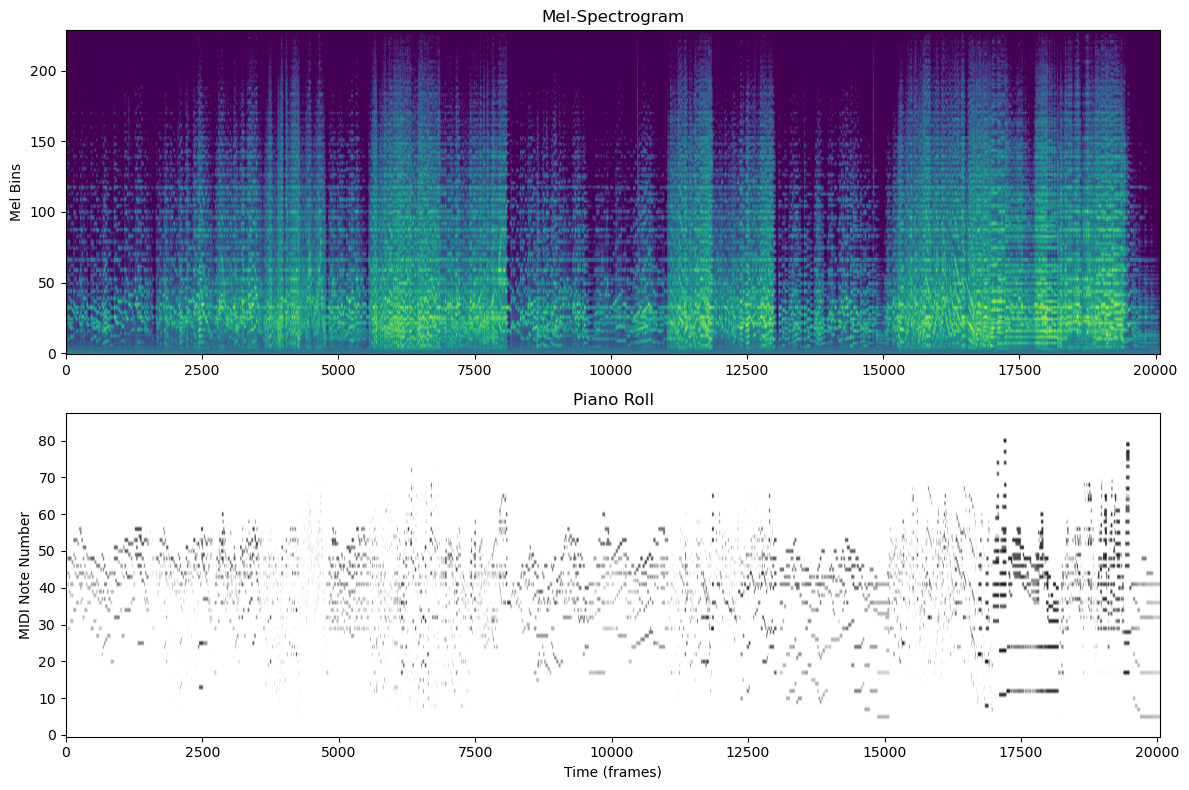

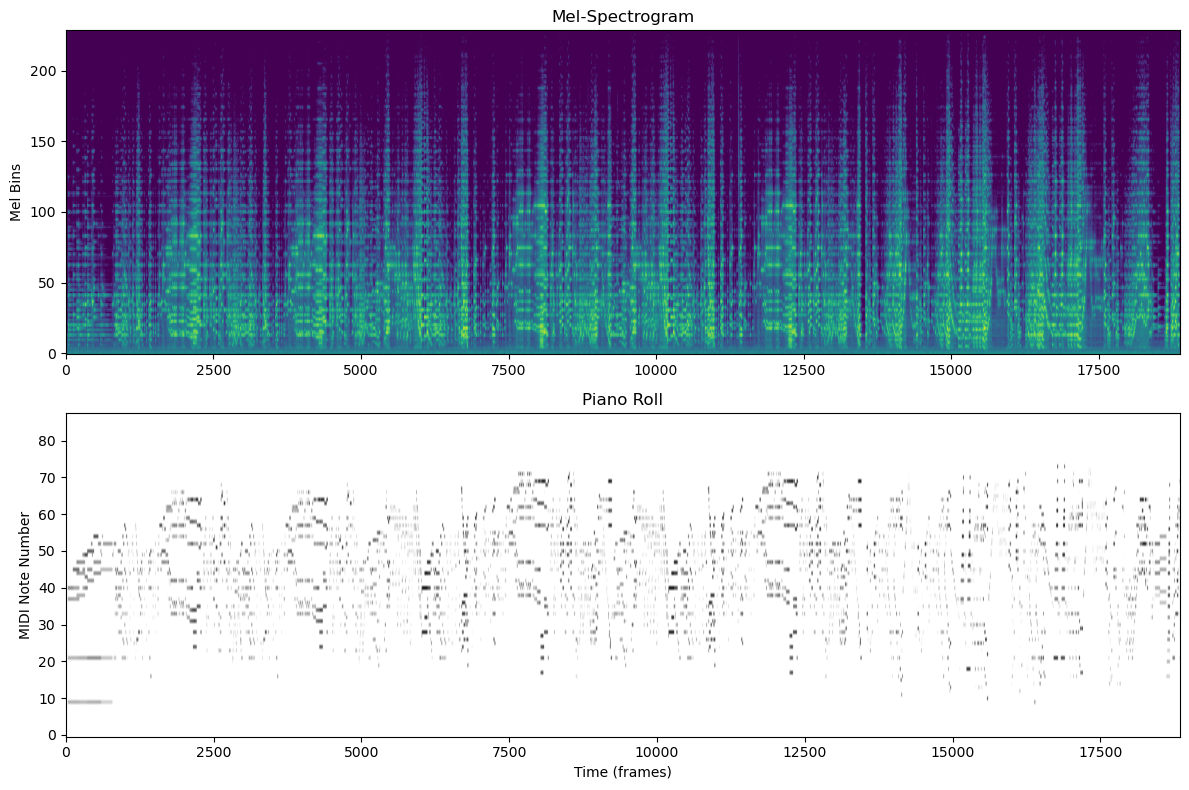

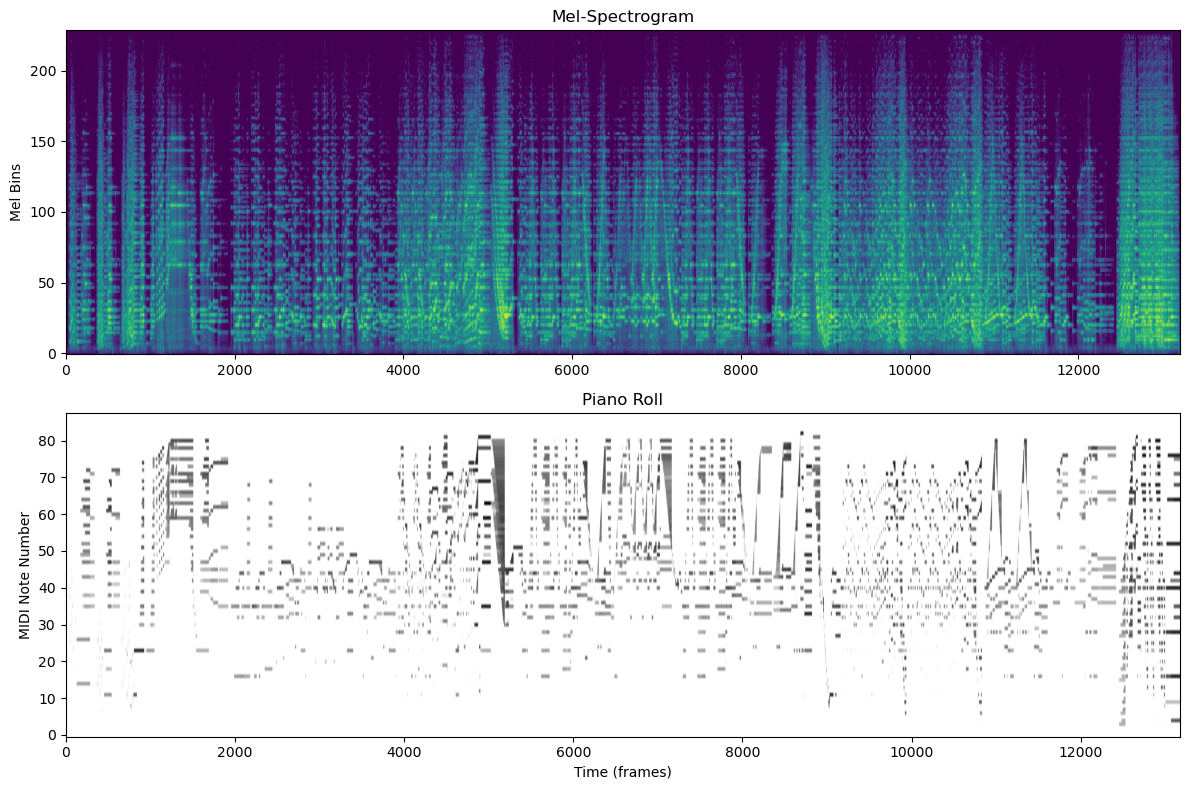

In [6]:
import os
import numpy as np
import librosa
import pretty_midi
import matplotlib.pyplot as plt

# Directories containing the preprocessed data
mel_output_dir = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/preprocessed_mel_spectrograms_v2"
piano_roll_output_dir = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/preprocessed_piano_rolls_v2"

# Function to verify shapes
def verify_shapes(mel_dir, piano_roll_dir):
    mel_files = [f for f in os.listdir(mel_dir) if f.endswith("_mel.npy")]
    piano_roll_files = [f for f in os.listdir(piano_roll_dir) if f.endswith("_roll.npy")]

    issues = []

    for mel_file in mel_files:
        piano_roll_file = mel_file.replace("_mel.npy", "_roll.npy")

        # Load Mel-spectrogram and piano roll files
        mel_spec = np.load(os.path.join(mel_dir, mel_file))
        piano_roll = np.load(os.path.join(piano_roll_dir, piano_roll_file))

        # Check shapes
        mel_shape = mel_spec.shape
        piano_roll_shape = piano_roll.shape

        if mel_shape[1] != piano_roll_shape[1]:
            issues.append((mel_file, mel_shape, piano_roll_file, piano_roll_shape))

    if issues:
        print(f"Issues found in {len(issues)} files:")
        for issue in issues:
            print(f"Mel file: {issue[0]} (shape: {issue[1]}) | Piano roll file: {issue[2]} (shape: {issue[3]})")
    else:
        print("All files have consistent shapes.")

# Function to visualize samples
def visualize_sample(mel_file, piano_roll_file):
    mel_spec = np.load(mel_file)
    piano_roll = np.load(piano_roll_file)
    
    fig, axs = plt.subplots(2, 1, figsize=(12, 8))
    
    # Visualize Mel-Spectrogram
    axs[0].imshow(mel_spec, aspect='auto', origin='lower', cmap='viridis')
    axs[0].set_title('Mel-Spectrogram')
    axs[0].set_ylabel('Mel Bins')
    
    # Visualize Piano Roll
    axs[1].imshow(piano_roll, aspect='auto', origin='lower', cmap='gray_r')
    axs[1].set_title('Piano Roll')
    axs[1].set_xlabel('Time (frames)')
    axs[1].set_ylabel('MIDI Note Number')
    
    plt.tight_layout()
    plt.show()

# Verify random samples for visualization
def verify_random_samples(mel_dir, piano_roll_dir, num_samples=3):
    mel_files = [f for f in os.listdir(mel_dir) if f.endswith("_mel.npy")]
    for mel_file in np.random.choice(mel_files, num_samples):
        piano_roll_file = mel_file.replace("_mel.npy", "_roll.npy")
        mel_path = os.path.join(mel_dir, mel_file)
        piano_roll_path = os.path.join(piano_roll_dir, piano_roll_file)
        
        if os.path.exists(piano_roll_path):
            visualize_sample(mel_path, piano_roll_path)
        else:
            print(f"Missing corresponding piano roll for {mel_file}")

# Running all verifications
def run_verifications():
    # Verify shapes
    verify_shapes(mel_output_dir, piano_roll_output_dir)
    
    # Verify random samples
    verify_random_samples(mel_output_dir, piano_roll_output_dir)

# Execute the verifications
run_verifications()


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Directory containing preprocessed piano rolls
piano_roll_dir = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/preprocessed_piano_rolls"

# Count occurrences of each note across all piano rolls
note_occurrences = np.zeros(88)  # For 88 piano keys (A0 to C8)
co_occurrence_matrix = np.zeros((88, 88))  # For pairwise co-occurrence

for file in os.listdir(piano_roll_dir):
    if file.endswith(".npy"):
        piano_roll = np.load(os.path.join(piano_roll_dir, file))
        
        # Add note occurrences
        note_occurrences += np.sum(piano_roll, axis=1)  # Sum across time frames
        
        # Add co-occurrence (note pairs active in the same frame)
        co_occurrence_matrix += np.dot(piano_roll, piano_roll.T)

# Plot note occurrences
plt.figure(figsize=(12, 6))
plt.bar(range(88), note_occurrences)
plt.title("Note Occurrences (A0 to C8)")
plt.xlabel("Notes (A0 = 0, C8 = 87)")
plt.ylabel("Frequency")
plt.show()

# Normalize co-occurrence matrix for visualization
co_occurrence_matrix /= co_occurrence_matrix.max()  # Normalize values to [0, 1]

plt.figure(figsize=(10, 8))
plt.imshow(co_occurrence_matrix, cmap="hot", interpolation="nearest")
plt.title("Note Pair Co-Occurrence Matrix")
plt.colorbar(label="Normalized Co-Occurrence")
plt.xlabel("Notes (A0 to C8)")
plt.ylabel("Notes (A0 to C8)")
plt.show()


KeyboardInterrupt: 

In [12]:
import os
import numpy as np
import librosa
import pretty_midi
from tqdm import tqdm
from scipy.ndimage import zoom
import matplotlib.pyplot as plt

# Directory containing the subfolder for the year 2004
base_dir = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004"

# Output directories for preprocessed data
mel_output_dir = os.path.join(base_dir, "preprocessed_mel_spectrograms")
piano_roll_output_dir = os.path.join(base_dir, "preprocessed_piano_rolls")

# Function to delete old files in the output directories
def clean_output_directory(directory):
    if os.path.exists(directory):
        for file in os.listdir(directory):
            file_path = os.path.join(directory, file)
            os.remove(file_path)
        print(f"Cleaned directory: {directory}")
    else:
        os.makedirs(directory)
        print(f"Created directory: {directory}")

clean_output_directory(mel_output_dir)
clean_output_directory(piano_roll_output_dir)

# Function to compute and save Mel spectrograms
def audio_to_mel_spectrogram(audio_path, output_dir, n_mels=229, sr=16000, fft_window=2048, hop_length=512):
    try:
        y, sr = librosa.load(audio_path, sr=sr)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=fft_window, hop_length=hop_length, n_mels=n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to decibels
        
        # Save Mel spectrogram as .npy file
        file_name = os.path.basename(audio_path).replace(".wav", "_mel.npy")
        output_path = os.path.join(output_dir, file_name)
        np.save(output_path, mel_spec_db)
        return mel_spec_db
    except Exception as e:
        print(f"Error processing audio file {audio_path}: {e}")
        return None

# Function to convert and save MIDI to piano roll
def midi_to_piano_roll(midi_path, output_dir, hop_length=512, sr=16000):
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_path)
        time_step = hop_length / sr  # Frame duration in seconds
        piano_roll = midi_data.get_piano_roll(fs=1/time_step)[21:109]  # Extract 88 piano keys (A0 to C8)
        
        # Dynamic velocity threshold to filter out noise
        velocity_threshold = np.percentile(piano_roll[piano_roll > 0], 10)  # e.g., 10th percentile
        piano_roll = (piano_roll > velocity_threshold).astype(np.float32)
        
        # Save Piano roll as .npy file
        file_name = os.path.basename(midi_path).replace(".midi", "_roll.npy").replace(".mid", "_roll.npy")
        output_path = os.path.join(output_dir, file_name)
        np.save(output_path, piano_roll)
        return piano_roll
    except Exception as e:
        print(f"Error processing MIDI file {midi_path}: {e}")
        return None

# Function to dynamically align Mel spectrogram and piano roll
def align_mel_and_piano_roll(mel_spec, piano_roll, hop_length=512, sr=16000):
    mel_frames = mel_spec.shape[1]
    piano_roll_frames = piano_roll.shape[1]

    # Calculate durations and log for debugging
    mel_duration = mel_frames * hop_length / sr
    piano_roll_duration = piano_roll_frames * (hop_length / sr)
    print(f"Mel duration: {mel_duration:.5f}s, Piano roll duration: {piano_roll_duration:.5f}s")

    # Align frame counts using interpolation
    if mel_frames != piano_roll_frames:
        mel_spec = zoom(mel_spec, (1, piano_roll_frames / mel_frames), order=1)
        piano_roll = zoom(piano_roll, (1, mel_frames / piano_roll_frames), order=1)

    return mel_spec, piano_roll

# Recursively process and align all .wav and corresponding .mid/.midi files in the 2004 subfolder
def preprocess_and_align_files(base_dir, mel_output_dir, piano_roll_output_dir):
    for root, _, files in os.walk(base_dir):
        audio_files = [f for f in files if f.endswith(".wav")]
        midi_files = [f for f in files if f.endswith(".mid") or f.endswith(".midi")]

        with tqdm(total=len(audio_files), desc=f"Processing in {root}", unit="file") as pbar:
            for audio_file in audio_files:
                audio_path = os.path.join(root, audio_file)
                
                # Find corresponding MIDI file
                midi_file_mid = audio_file.replace(".wav", ".mid")
                midi_file_midi = audio_file.replace(".wav", ".midi")
                midi_path = None
                if midi_file_mid in midi_files:
                    midi_path = os.path.join(root, midi_file_mid)
                elif midi_file_midi in midi_files:
                    midi_path = os.path.join(root, midi_file_midi)

                if midi_path:
                    # Process Mel spectrogram and piano roll
                    mel_spec = audio_to_mel_spectrogram(audio_path, mel_output_dir)
                    piano_roll = midi_to_piano_roll(midi_path, piano_roll_output_dir)

                    if mel_spec is not None and piano_roll is not None:
                        # Align and save the synchronized outputs
                        mel_spec_aligned, piano_roll_aligned = align_mel_and_piano_roll(mel_spec, piano_roll)
                        
                        # Save aligned files
                        mel_file_name = os.path.basename(audio_path).replace(".wav", "_mel.npy")
                        piano_roll_file_name = os.path.basename(midi_path).replace(".mid", "_roll.npy").replace(".midi", "_roll.npy")
                        np.save(os.path.join(mel_output_dir, mel_file_name), mel_spec_aligned)
                        np.save(os.path.join(piano_roll_output_dir, piano_roll_file_name), piano_roll_aligned)
                else:
                    print(f"No corresponding MIDI file found for {audio_file}")
                    with open("missing_midi_files.log", "a") as log_file:
                        log_file.write(f"No MIDI file for {audio_file}\n")

                # Update progress bar
                pbar.update(1)

# Execute preprocessing for the 2004 subfolder
preprocess_and_align_files(base_dir, mel_output_dir, piano_roll_output_dir)

print("Data preprocessing complete!")

Cleaned directory: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004/preprocessed_mel_spectrograms
Cleaned directory: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004/preprocessed_piano_rolls


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:   0%| | 0/132 

Mel duration: 969.63200s, Piano roll duration: 968.99200s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:   1%| | 1/132 

Mel duration: 552.67200s, Piano roll duration: 551.77600s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:   2%| | 2/132 

Mel duration: 267.45600s, Piano roll duration: 267.42400s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:   3%| | 4/132 

Mel duration: 194.59200s, Piano roll duration: 194.08000s
Mel duration: 339.26400s, Piano roll duration: 338.24000s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:   4%| | 5/132 

Mel duration: 312.67200s, Piano roll duration: 312.64000s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:   5%| | 6/132 

Mel duration: 260.44800s, Piano roll duration: 259.96800s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:   5%| | 7/132 

Mel duration: 1410.36800s, Piano roll duration: 1409.34400s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:   6%| | 8/132 

Mel duration: 328.51200s, Piano roll duration: 327.68000s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:   7%| | 9/132 

Mel duration: 686.65600s, Piano roll duration: 685.56800s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:   8%| | 10/132

Mel duration: 622.62400s, Piano roll duration: 621.56800s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:   8%| | 11/132

Mel duration: 478.56000s, Piano roll duration: 477.69600s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:   9%| | 12/132

Mel duration: 833.31200s, Piano roll duration: 832.38400s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  10%| | 13/132

Mel duration: 995.52000s, Piano roll duration: 995.16800s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  11%| | 14/132

Mel duration: 303.64800s, Piano roll duration: 303.58400s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  11%| | 15/132

Mel duration: 663.32800s, Piano roll duration: 662.30400s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  12%| | 16/132

Mel duration: 661.72800s, Piano roll duration: 661.02400s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  13%|▏| 17/132

Mel duration: 1140.22400s, Piano roll duration: 1139.16800s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  14%|▏| 18/132

Mel duration: 1404.28800s, Piano roll duration: 1403.26400s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  14%|▏| 19/132

Mel duration: 348.32000s, Piano roll duration: 347.71200s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  15%|▏| 20/132

Mel duration: 372.16000s, Piano roll duration: 371.42400s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  17%|▏| 22/132

Mel duration: 137.85600s, Piano roll duration: 137.05600s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  17%|▏| 23/132

Mel duration: 135.45600s, Piano roll duration: 134.43200s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  18%|▏| 24/132

Mel duration: 246.43200s, Piano roll duration: 246.20800s
Mel duration: 565.95200s, Piano roll duration: 564.96000s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  20%|▏| 26/132

Mel duration: 231.93600s, Piano roll duration: 231.87200s
Mel duration: 330.40000s, Piano roll duration: 330.30400s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  20%|▏| 27/132

Mel duration: 546.11200s, Piano roll duration: 545.05600s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  22%|▏| 29/132

Mel duration: 218.94400s, Piano roll duration: 217.92000s
Mel duration: 296.25600s, Piano roll duration: 295.23200s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  23%|▏| 30/132

Mel duration: 261.37600s, Piano roll duration: 260.38400s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  24%|▏| 32/132

Mel duration: 237.18400s, Piano roll duration: 237.05600s
Mel duration: 343.20000s, Piano roll duration: 342.97600s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  25%|▎| 33/132

Mel duration: 1197.72800s, Piano roll duration: 1196.86400s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  26%|▎| 34/132

Mel duration: 977.02400s, Piano roll duration: 976.16000s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  27%|▎| 35/132

Mel duration: 518.01600s, Piano roll duration: 516.96000s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  27%|▎| 36/132

Mel duration: 312.73600s, Piano roll duration: 311.71200s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  28%|▎| 37/132

Mel duration: 700.86400s, Piano roll duration: 700.83200s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  29%|▎| 38/132

Mel duration: 706.88000s, Piano roll duration: 706.56000s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  30%|▎| 39/132

Mel duration: 1204.89600s, Piano roll duration: 1204.38400s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  30%|▎| 40/132

Mel duration: 1480.83200s, Piano roll duration: 1480.16000s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  31%|▎| 41/132

Mel duration: 605.53600s, Piano roll duration: 604.44800s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  32%|▎| 42/132

Mel duration: 793.15200s, Piano roll duration: 792.48000s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  33%|▎| 43/132

Mel duration: 631.42400s, Piano roll duration: 630.65600s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  34%|▎| 45/132

Mel duration: 131.61600s, Piano roll duration: 131.16800s
Mel duration: 805.76000s, Piano roll duration: 804.70400s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  35%|▎| 46/132

Mel duration: 361.05600s, Piano roll duration: 360.96000s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  36%|▎| 47/132

Mel duration: 1006.08000s, Piano roll duration: 1005.05600s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  36%|▎| 48/132

Mel duration: 364.57600s, Piano roll duration: 363.71200s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  37%|▎| 49/132

Mel duration: 293.53600s, Piano roll duration: 292.48000s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  38%|▍| 50/132

Mel duration: 734.56000s, Piano roll duration: 733.66400s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  39%|▍| 52/132

Mel duration: 197.21600s, Piano roll duration: 196.83200s
Mel duration: 1704.86400s, Piano roll duration: 1703.96800s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  40%|▍| 53/132

Mel duration: 510.91200s, Piano roll duration: 510.88000s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  41%|▍| 54/132

Mel duration: 532.32000s, Piano roll duration: 531.29600s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  42%|▍| 55/132

Mel duration: 650.43200s, Piano roll duration: 649.44000s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  42%|▍| 56/132

Mel duration: 421.47200s, Piano roll duration: 420.44800s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  43%|▍| 57/132

Mel duration: 1025.05600s, Piano roll duration: 1024.99200s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  44%|▍| 58/132

Mel duration: 1959.39200s, Piano roll duration: 1958.33600s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  45%|▍| 59/132

Mel duration: 1300.41600s, Piano roll duration: 1300.09600s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  45%|▍| 60/132

Mel duration: 2399.96800s, Piano roll duration: 2398.84800s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  46%|▍| 61/132

Mel duration: 751.42400s, Piano roll duration: 750.40000s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  47%|▍| 62/132

Mel duration: 692.73600s, Piano roll duration: 692.64000s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  48%|▍| 63/132

Mel duration: 494.14400s, Piano roll duration: 493.15200s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  48%|▍| 64/132

Mel duration: 525.69600s, Piano roll duration: 525.63200s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  50%|▌| 66/132

Mel duration: 156.00000s, Piano roll duration: 155.00800s
Mel duration: 747.00800s, Piano roll duration: 745.98400s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  51%|▌| 67/132

Mel duration: 721.12000s, Piano roll duration: 720.06400s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  52%|▌| 68/132

Mel duration: 769.18400s, Piano roll duration: 768.12800s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  52%|▌| 69/132

Mel duration: 1257.63200s, Piano roll duration: 1257.56800s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  54%|▌| 71/132

Mel duration: 204.06400s, Piano roll duration: 203.36000s
Mel duration: 707.39200s, Piano roll duration: 707.29600s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  55%|▌| 72/132

Mel duration: 1315.71200s, Piano roll duration: 1314.62400s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  56%|▌| 74/132

Mel duration: 169.79200s, Piano roll duration: 169.08800s
Mel duration: 287.55200s, Piano roll duration: 287.52000s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  57%|▌| 75/132

Mel duration: 454.59200s, Piano roll duration: 453.56800s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  58%|▌| 77/132

Mel duration: 159.20000s, Piano roll duration: 158.17600s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  59%|▌| 78/132

Mel duration: 204.73600s, Piano roll duration: 203.77600s
Mel duration: 317.85600s, Piano roll duration: 316.86400s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  60%|▌| 79/132

Mel duration: 638.97600s, Piano roll duration: 637.92000s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  61%|▌| 80/132

Mel duration: 1444.92800s, Piano roll duration: 1443.77600s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  62%|▌| 82/132

Mel duration: 225.31200s, Piano roll duration: 225.12000s
Mel duration: 689.40800s, Piano roll duration: 688.32000s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  63%|▋| 83/132

Mel duration: 458.08000s, Piano roll duration: 457.02400s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  64%|▋| 84/132

Mel duration: 1304.96000s, Piano roll duration: 1304.76800s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  64%|▋| 85/132

Mel duration: 310.49600s, Piano roll duration: 310.46400s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  65%|▋| 86/132

Mel duration: 535.71200s, Piano roll duration: 534.65600s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  66%|▋| 87/132

Mel duration: 570.27200s, Piano roll duration: 569.56800s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  67%|▋| 88/132

Mel duration: 1450.04800s, Piano roll duration: 1448.92800s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  67%|▋| 89/132

Mel duration: 273.69600s, Piano roll duration: 273.66400s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  68%|▋| 90/132

Mel duration: 1120.16000s, Piano roll duration: 1119.00800s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  69%|▋| 91/132

Mel duration: 1065.88800s, Piano roll duration: 1064.76800s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  70%|▋| 93/132

Mel duration: 246.65600s, Piano roll duration: 245.79200s
Mel duration: 1168.60800s, Piano roll duration: 1168.28800s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  71%|▋| 94/132

Mel duration: 241.95200s, Piano roll duration: 241.47200s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  73%|▋| 96/132

Mel duration: 116.38400s, Piano roll duration: 115.48800s
Mel duration: 397.12000s, Piano roll duration: 396.22400s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  73%|▋| 97/132

Mel duration: 902.33600s, Piano roll duration: 902.27200s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  74%|▋| 98/132

Mel duration: 595.74400s, Piano roll duration: 595.68000s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  75%|▊| 99/132

Mel duration: 682.43200s, Piano roll duration: 682.36800s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  76%|▊| 100/13

Mel duration: 351.64800s, Piano roll duration: 351.61600s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  77%|▊| 101/13

Mel duration: 250.62400s, Piano roll duration: 250.52800s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  77%|▊| 102/13

Mel duration: 443.90400s, Piano roll duration: 443.04000s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  78%|▊| 103/13

Mel duration: 1443.20000s, Piano roll duration: 1442.04800s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  79%|▊| 104/13

Mel duration: 917.31200s, Piano roll duration: 917.24800s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  80%|▊| 105/13

Mel duration: 572.48000s, Piano roll duration: 572.44800s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  81%|▊| 107/13

Mel duration: 241.02400s, Piano roll duration: 240.99200s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  82%|▊| 108/13

Mel duration: 208.28800s, Piano roll duration: 208.22400s
Mel duration: 490.24000s, Piano roll duration: 489.21600s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  83%|▊| 109/13

Mel duration: 749.21600s, Piano roll duration: 749.18400s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  83%|▊| 110/13

Mel duration: 273.40800s, Piano roll duration: 272.44800s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  84%|▊| 111/13

Mel duration: 417.92000s, Piano roll duration: 417.88800s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  85%|▊| 112/13

Mel duration: 2103.42400s, Piano roll duration: 2102.46400s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  86%|▊| 113/13

Mel duration: 225.88800s, Piano roll duration: 225.79200s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  86%|▊| 114/13

Mel duration: 508.96000s, Piano roll duration: 508.64000s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  88%|▉| 116/13

Mel duration: 211.04000s, Piano roll duration: 211.00800s
Mel duration: 452.83200s, Piano roll duration: 452.80000s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  89%|▉| 118/13

Mel duration: 189.95200s, Piano roll duration: 189.88800s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  90%|▉| 119/13

Mel duration: 142.84800s, Piano roll duration: 141.82400s
Mel duration: 465.34400s, Piano roll duration: 465.31200s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  91%|▉| 120/13

Mel duration: 706.75200s, Piano roll duration: 705.76000s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  92%|▉| 121/13

Mel duration: 754.78400s, Piano roll duration: 754.72000s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  92%|▉| 122/13

Mel duration: 433.44000s, Piano roll duration: 433.12000s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  93%|▉| 123/13

Mel duration: 686.94400s, Piano roll duration: 685.82400s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  94%|▉| 124/13

Mel duration: 873.82400s, Piano roll duration: 872.76800s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  95%|▉| 125/13

Mel duration: 497.08800s, Piano roll duration: 497.05600s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  95%|▉| 126/13

Mel duration: 782.78400s, Piano roll duration: 781.72800s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  96%|▉| 127/13

Mel duration: 1978.01600s, Piano roll duration: 1976.99200s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  97%|▉| 128/13

Mel duration: 463.93600s, Piano roll duration: 463.87200s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  98%|▉| 129/13

Mel duration: 466.30400s, Piano roll duration: 466.24000s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  99%|▉| 131/13

Mel duration: 153.76000s, Piano roll duration: 152.96000s
Mel duration: 548.83200s, Piano roll duration: 547.77600s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004: 100%|█| 132/13
Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004/preprocessed_mel_spectrograms: 0file [00:00, ?file/s]
Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004/preprocessed_piano_rolls: 0file [00:00, ?file/s]

Data preprocessing complete!


In [37]:
import os
import numpy as np
from tqdm import tqdm
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import librosa

# Directories for preprocessed Mel spectrograms and piano rolls
mel_output_dir = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004/preprocessed_mel_spectrograms_debug"
piano_roll_output_dir = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004/preprocessed_piano_rolls_debug"

# Log file for comprehensive validation
log_file_path = "detailed_data_preprocessing_validation.log"

# Function to extract onsets from Mel spectrogram
def extract_mel_onsets(mel_spec, sr=16000, hop_length=512):
    onset_env = librosa.onset.onset_strength(S=mel_spec, sr=sr, hop_length=hop_length)
    onsets = librosa.onset.onset_detect(onset_envelope=onset_env, sr=sr, hop_length=hop_length)
    return onsets

# Function to extract onsets from piano roll
def extract_piano_roll_onsets(piano_roll):
    return np.where(np.diff(np.any(piano_roll, axis=0).astype(int)) > 0)[0]

# Function to validate data preprocessing
def validate_data_comprehensive(mel_dir, piano_roll_dir, log_file, mismatch_threshold=0.1, onset_tolerance=3):
    discrepancies = []
    
    mel_files = [f for f in os.listdir(mel_dir) if f.endswith("_mel.npy")]
    piano_roll_files = [f for f in os.listdir(piano_roll_dir) if f.endswith("_roll.npy")]

    with tqdm(total=len(mel_files), desc="Validating data preprocessing", unit="file") as pbar:
        for mel_file in mel_files:
            try:
                # Extract matching piano roll file name
                piano_roll_file = mel_file.replace("_mel.npy", "_roll.npy")
                
                if piano_roll_file in piano_roll_files:
                    # Load Mel spectrogram and piano roll
                    mel_path = os.path.join(mel_dir, mel_file)
                    piano_roll_path = os.path.join(piano_roll_dir, piano_roll_file)
                    mel_spec = np.load(mel_path)
                    piano_roll = np.load(piano_roll_path)

                    # Step 1: Frame Count Validation
                    if mel_spec.shape[1] != piano_roll.shape[1]:
                        discrepancies.append(f"Frame mismatch: {mel_file} (Mel frames: {mel_spec.shape[1]}) vs {piano_roll_file} (Piano roll frames: {piano_roll.shape[1]})")

                    # Step 2: Dynamic Time Warping (DTW) Validation
                    mel_energy = mel_spec.sum(axis=0)  # Summing across frequency bins
                    piano_roll_energy = piano_roll.sum(axis=0)  # Summing across keys
                    distance, _ = fastdtw(mel_energy, piano_roll_energy, dist=euclidean)
                    normalized_distance = distance / max(len(mel_energy), len(piano_roll_energy))
                    if normalized_distance > mismatch_threshold:
                        discrepancies.append(f"Synchronization mismatch: {mel_file} vs {piano_roll_file} (DTW Distance: {normalized_distance:.4f})")

                    # Step 3: Onset Detection Validation
                    mel_onsets = extract_mel_onsets(mel_spec)
                    piano_roll_onsets = extract_piano_roll_onsets(piano_roll)
                    onset_mismatches = sum(
                        np.min(np.abs(mel_onsets[:, None] - piano_roll_onsets[None, :]), axis=1) > onset_tolerance
                    )
                    if onset_mismatches > 0:
                        discrepancies.append(f"Onset mismatch: {mel_file} vs {piano_roll_file} (Onset mismatches: {onset_mismatches})")

                else:
                    discrepancies.append(f"Missing piano roll for: {mel_file}")
            except Exception as e:
                discrepancies.append(f"Error processing file {mel_file}: {e}")
            
            # Update progress bar
            pbar.update(1)

    # Step 4: Write discrepancies to log file
    with open(log_file, "w") as log:
        for entry in discrepancies:
            log.write(entry + "\n")
    
    if discrepancies:
        print(f"Validation complete with {len(discrepancies)} issues found. Check {log_file} for details.")
    else:
        print("Validation complete. All files passed the checks successfully!")

# Execute validation
validate_data_comprehensive(mel_output_dir, piano_roll_output_dir, log_file_path)


Validating data preprocessing: 100%|██████████| 10/10 [01:04<00:00,  6.48s/file]

Validation complete with 30 issues found. Check detailed_data_preprocessing_validation.log for details.


In [1]:
import os
import numpy as np
import librosa
import pretty_midi
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set up directories for your MAESTRO v3 dataset
base_dir = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0"
output_dir = os.path.join(base_dir, "preprocessed")
mel_dir = os.path.join(output_dir, "mel_specs")
piano_roll_dir = os.path.join(output_dir, "piano_rolls")
verification_dir = os.path.join(output_dir, "verification")

# Create output directories
os.makedirs(mel_dir, exist_ok=True)
os.makedirs(piano_roll_dir, exist_ok=True)
os.makedirs(verification_dir, exist_ok=True)

# Parameters matching the paper
sr = 16000
n_mels = 229
hop_length = 512
n_fft = 2048
segment_length = 20  # 20 second segments as mentioned in the paper

def process_audio_file(audio_path, midi_path, file_id):
    # Load audio
    y, _ = librosa.load(audio_path, sr=sr)
    
    # Compute total duration and number of segments
    total_duration = len(y) / sr
    num_segments = int(np.floor(total_duration / segment_length))
    
    # Load MIDI
    midi_data = pretty_midi.PrettyMIDI(midi_path)
    
    segments_info = []
    
    for segment_idx in range(num_segments):
        # Calculate segment start and end in samples
        start_sample = segment_idx * segment_length * sr
        end_sample = (segment_idx + 1) * segment_length * sr
        
        # Extract audio segment
        y_segment = y[start_sample:end_sample]
        
        # Compute mel spectrogram with exact parameters from the paper
        mel_spec = librosa.feature.melspectrogram(
            y=y_segment, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
        )
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        # Get number of frames in mel spectrogram
        n_frames = mel_spec.shape[1]
        
        # Calculate segment start and end time in seconds
        start_time = segment_idx * segment_length
        end_time = (segment_idx + 1) * segment_length
        
        # Create piano roll with EXACTLY the same number of frames as mel spectrogram
        frames_per_second = n_frames / segment_length
        piano_roll = np.zeros((88, n_frames))  # 88 keys (A0-C8)
        
        # Fill in the piano roll
        for instrument in midi_data.instruments:
            if not instrument.is_drum:  # Skip drum tracks if any
                for note in instrument.notes:
                    # Only include notes that fall within our segment
                    if note.start < end_time and note.end > start_time:
                        # Check if note is in piano range (A0-C8 = MIDI 21-108)
                        if 21 <= note.pitch <= 108:
                            # Adjust note times to be relative to segment start
                            rel_start = max(0, note.start - start_time)
                            rel_end = min(segment_length, note.end - start_time)
                            
                            # Convert to frame indices - ensure exact frame alignment
                            start_frame = int(rel_start * frames_per_second)
                            end_frame = int(rel_end * frames_per_second)
                            
                            # Ensure we stay within bounds
                            start_frame = min(start_frame, n_frames - 1)
                            end_frame = min(end_frame, n_frames)
                            
                            # Map MIDI pitch to piano roll index (A0 = 21 maps to index 0)
                            piano_idx = note.pitch - 21
                            
                            # Set the piano roll values - use velocity if available
                            velocity = min(note.velocity / 127.0, 1.0)  # Normalize to [0,1]
                            piano_roll[piano_idx, start_frame:end_frame] = velocity if velocity > 0 else 1.0
        
        # Double-check that shapes match exactly
        assert mel_spec_db.shape[1] == piano_roll.shape[1], \
            f"Frame count mismatch: mel={mel_spec_db.shape[1]}, piano={piano_roll.shape[1]}"
        
        # Save the processed data
        segment_id = f"{file_id}_seg{segment_idx:03d}"
        np.save(os.path.join(mel_dir, f"{segment_id}_mel.npy"), mel_spec_db)
        np.save(os.path.join(piano_roll_dir, f"{segment_id}_roll.npy"), piano_roll)
        
        # Store segment info for later
        segments_info.append({
            'id': segment_id,
            'mel_shape': mel_spec_db.shape,
            'roll_shape': piano_roll.shape,
            'start_time': start_time,
            'end_time': end_time
        })
        
        # Create verification plot for the first and last segment of each file
        if segment_idx == 0 or segment_idx == num_segments - 1:
            create_verification_plot(mel_spec_db, piano_roll, segment_id)
    
    return segments_info

def create_verification_plot(mel_spec, piano_roll, segment_id):
    """Create visualization to verify alignment"""
    plt.figure(figsize=(15, 10))
    
    # Plot mel spectrogram
    plt.subplot(2, 1, 1)
    librosa.display.specshow(
        mel_spec, 
        y_axis='mel', 
        x_axis='time', 
        sr=sr, 
        hop_length=hop_length
    )
    plt.title(f'Mel Spectrogram - {segment_id}')
    plt.colorbar(format='%+2.0f dB')
    
    # Plot piano roll
    plt.subplot(2, 1, 2)
    librosa.display.specshow(
        piano_roll, 
        y_axis='linear', 
        x_axis='time', 
        sr=sr, 
        hop_length=hop_length
    )
    plt.yticks(np.arange(0, 88, 12), 
               ['A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7'])
    plt.title(f'Piano Roll - {segment_id}')
    plt.colorbar()
    
    # Save the plot
    plt.tight_layout()
    plt.savefig(os.path.join(verification_dir, f"{segment_id}_verification.png"))
    plt.close()

def process_dataset(year=None, max_files=None):
    """Process files from the dataset
    
    Args:
        year: If provided, only process files from this year
        max_files: If provided, limit processing to this many files
    """
    all_segments = []
    file_count = 0
    
    # Walk through the dataset directory
    for root, dirs, files in os.walk(base_dir):
        # Skip non-year directories and check for year filter
        current_dir = os.path.basename(root)
        if not current_dir.isdigit() or (year and current_dir != str(year)):
            continue
            
        # Find audio files
        audio_files = [f for f in files if f.endswith('.wav')]
        
        # Apply max_files limit if specified
        if max_files and file_count >= max_files:
            break
            
        for audio_file in tqdm(audio_files, desc=f"Processing {current_dir}"):
            # Check for max files limit
            if max_files and file_count >= max_files:
                break
                
            # Find matching MIDI file
            midi_file = audio_file.replace('.wav', '.midi')
            if midi_file not in files:
                midi_file = audio_file.replace('.wav', '.mid')
                if midi_file not in files:
                    print(f"No matching MIDI file for {audio_file}")
                    continue
            
            # Full paths
            audio_path = os.path.join(root, audio_file)
            midi_path = os.path.join(root, midi_file)
            
            # Process file
            file_id = f"{current_dir}_{os.path.splitext(audio_file)[0]}"
            segments_info = process_audio_file(audio_path, midi_path, file_id)
            
            all_segments.extend(segments_info)
            file_count += 1
            
            print(f"Processed {file_id}: {len(segments_info)} segments")
    
    # Save dataset metadata
    metadata = {
        'total_files': file_count,
        'total_segments': len(all_segments),
        'segments': all_segments
    }
    
    np.save(os.path.join(output_dir, 'dataset_metadata.npy'), metadata)
    
    print(f"Total files processed: {file_count}")
    print(f"Total segments generated: {len(all_segments)}")
    
    return metadata

# Process just the 2004 data with a limit of 5 files for testing
metadata = process_dataset(year=2004, max_files=5)

# Verify a random segment (optional)
if len(metadata['segments']) > 0:
    import random
    random_segment = random.choice(metadata['segments'])
    segment_id = random_segment['id']
    
    # Load the saved data
    mel = np.load(os.path.join(mel_dir, f"{segment_id}_mel.npy"))
    roll = np.load(os.path.join(piano_roll_dir, f"{segment_id}_roll.npy"))
    
    print(f"Verification for segment {segment_id}:")
    print(f"Mel shape: {mel.shape}, Piano roll shape: {roll.shape}")
    print(f"Frames match: {mel.shape[1] == roll.shape[1]}")

Processing 2004:   1%|▏                       | 1/132 [00:32<1:12:02, 33.00s/it]

Processed 2004_MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav: 48 segments


Processing 2004:   2%|▍                         | 2/132 [00:49<50:01, 23.08s/it]

Processed 2004_MIDI-Unprocessed_SMF_12_01_2004_01-05_ORIG_MID--AUDIO_12_R1_2004_07_Track07_wav: 27 segments


Processing 2004:   2%|▌                         | 3/132 [00:59<37:24, 17.40s/it]

Processed 2004_MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav: 13 segments


Processing 2004:   3%|▊                         | 4/132 [01:05<27:17, 12.79s/it]

Processed 2004_MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_08_Track08_wav: 9 segments


Processing 2004:   4%|▉                         | 5/132 [01:12<30:50, 14.57s/it]

Processed 2004_MIDI-Unprocessed_SMF_12_01_2004_01-05_ORIG_MID--AUDIO_12_R1_2004_08_Track08_wav: 16 segments


Total files processed: 5
Total segments generated: 113
Verification for segment 2004_MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav_seg012:
Mel shape: (229, 626), Piano roll shape: (88, 626)
Frames match: True


In [28]:
import os

# Path to the log file
log_file_path = "detailed_data_preprocessing_validation.log"

# Function to read and analyze the log file
def analyze_log_file(log_path):
    if not os.path.exists(log_path):
        print(f"Log file not found: {log_path}")
        return

    with open(log_path, "r") as log_file:
        log_lines = log_file.readlines()
    
    # Categorize log entries
    frame_mismatches = [line for line in log_lines if "Frame mismatch" in line]
    sync_mismatches = [line for line in log_lines if "Synchronization mismatch" in line]
    onset_mismatches = [line for line in log_lines if "Onset mismatch" in line]
    missing_files = [line for line in log_lines if "Missing piano roll" in line]
    errors = [line for line in log_lines if "Error processing file" in line]

    # Print summary
    print(f"Total discrepancies: {len(log_lines)}")
    print(f"Frame mismatches: {len(frame_mismatches)}")
    print(f"Synchronization mismatches (DTW): {len(sync_mismatches)}")
    print(f"Onset mismatches: {len(onset_mismatches)}")
    print(f"Missing piano roll files: {len(missing_files)}")
    print(f"Errors during processing: {len(errors)}")
    
    # Optional: Print detailed entries
    if len(log_lines) > 0:
        print("\nDetailed log entries:")
        for line in log_lines[:10]:  # Limit to the first 10 entries for brevity
            print(line.strip())

# Execute the log analysis
analyze_log_file(log_file_path)


Total discrepancies: 10
Frame mismatches: 0
Synchronization mismatches (DTW): 5
Onset mismatches: 5
Missing piano roll files: 0
Errors during processing: 0

Detailed log entries:
Synchronization mismatch: MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav_mel.npy vs MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav_roll.npy (DTW Distance: 13461.6374)
Onset mismatch: MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav_mel.npy vs MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav_roll.npy (Onset mismatches: 4107)
Synchronization mismatch: MIDI-Unprocessed_SMF_12_01_2004_01-05_ORIG_MID--AUDIO_12_R1_2004_07_Track07_wav_mel.npy vs MIDI-Unprocessed_SMF_12_01_2004_01-05_ORIG_MID--AUDIO_12_R1_2004_07_Track07_wav_roll.npy (DTW Distance: 13785.6246)
Onset mismatch: MIDI-Unprocessed_SMF_12_01_2004_01-05_ORIG_MID--AUDIO_12_R1_2004_07_Track07_wav_mel.npy vs MIDI-Unprocessed_SMF_12_01_

Cleaned output directory: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004/preprocessed_mel_spectrograms_debug
Cleaned output directory: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004/preprocessed_piano_rolls_debug


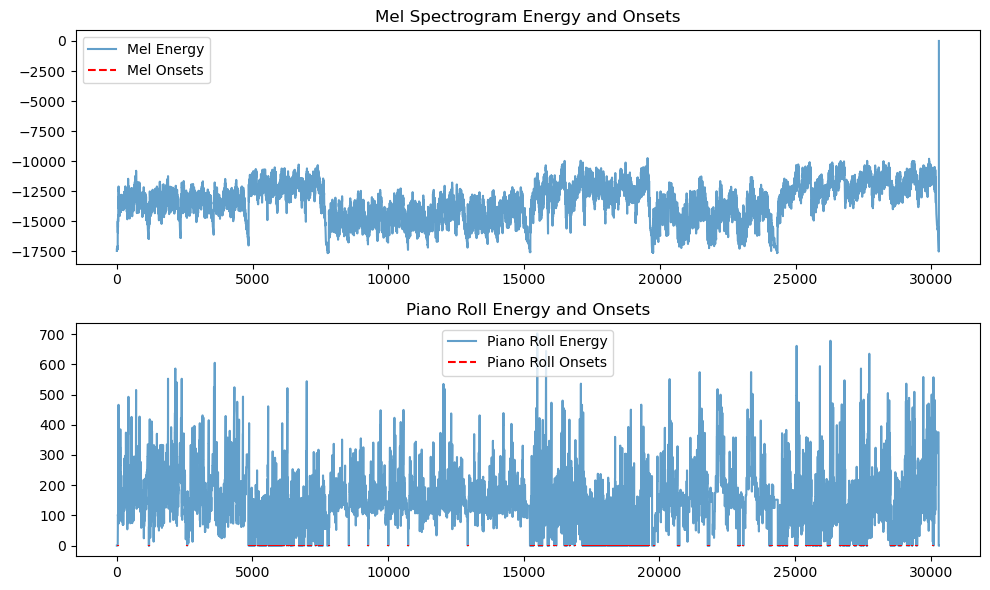

Processed file 1: MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav.wav


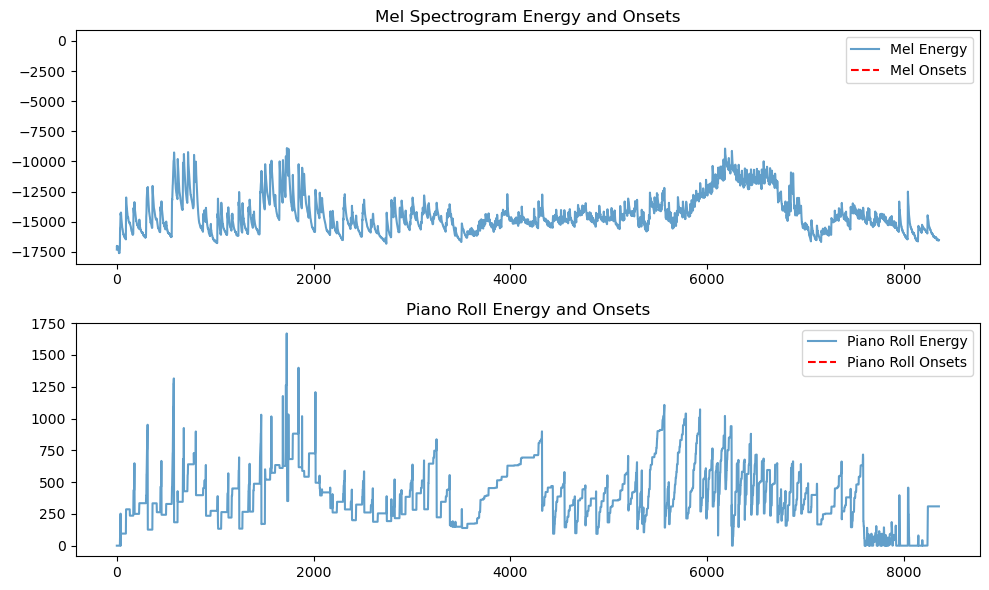

Processed file 2: MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav.wav


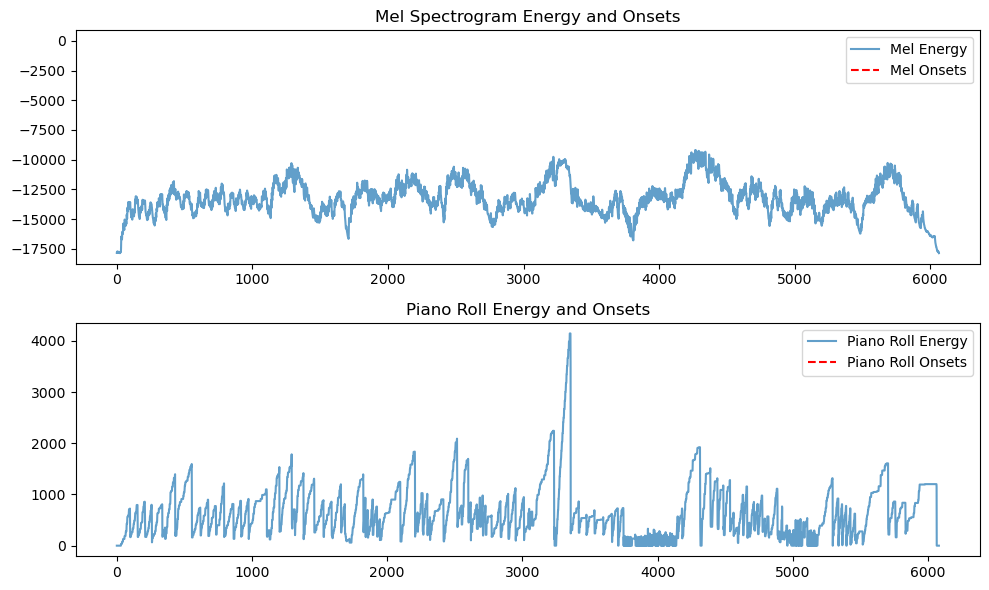

Processed file 3: MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_08_Track08_wav.wav


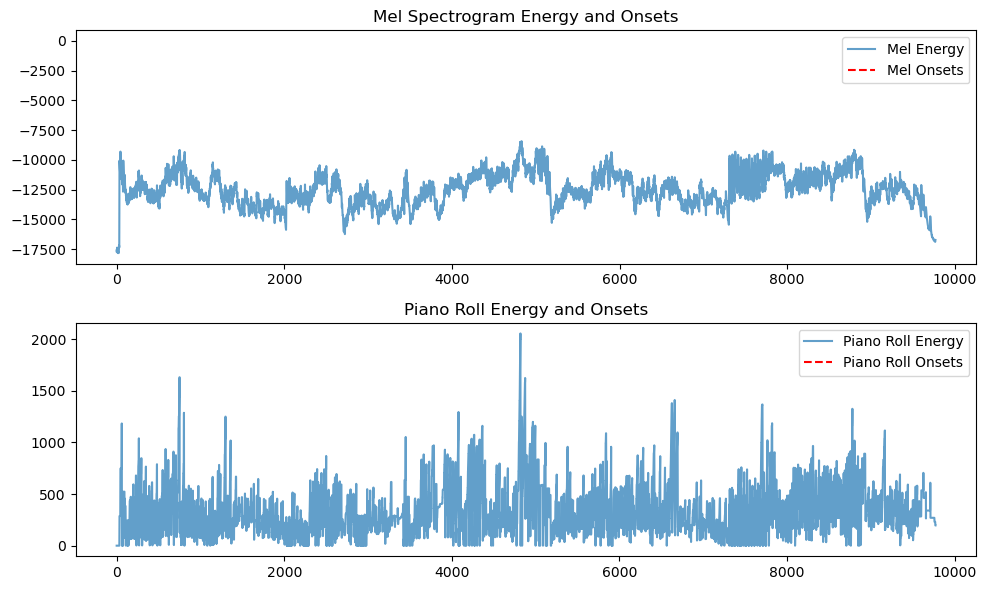

Processed file 4: MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_10_Track10_wav.wav


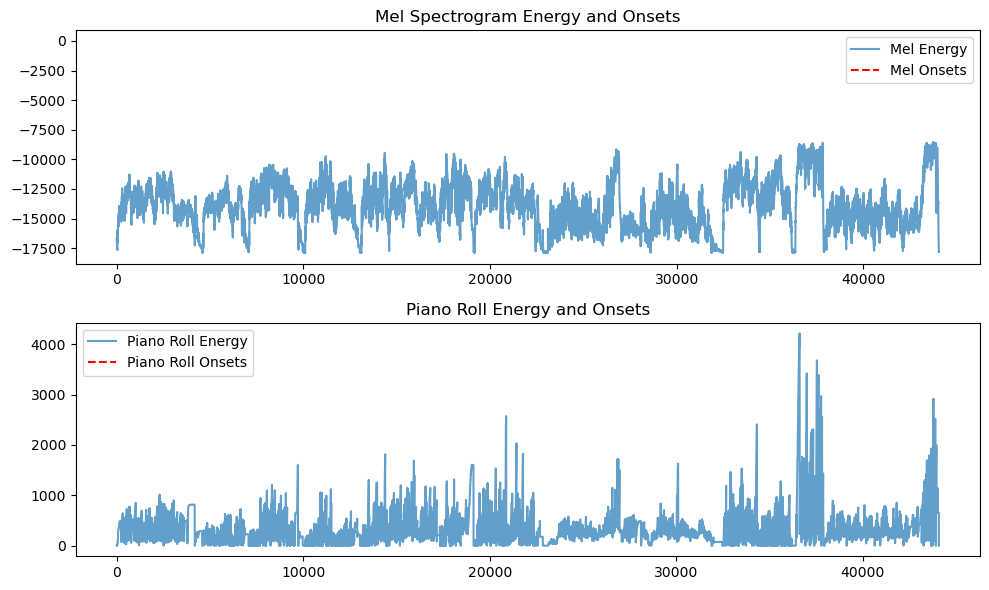

Processed file 5: MIDI-Unprocessed_SMF_05_R1_2004_01_ORIG_MID--AUDIO_05_R1_2004_02_Track02_wav.wav
Processing and debugging for the first 5 files completed!


In [36]:
import os
import numpy as np
import librosa
import pretty_midi
from tqdm import tqdm
from scipy.ndimage import zoom
import matplotlib.pyplot as plt

# Base directory for the year 2004
base_dir = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004"

# Output directories for preprocessed data
mel_output_dir = os.path.join(base_dir, "preprocessed_mel_spectrograms_debug")
piano_roll_output_dir = os.path.join(base_dir, "preprocessed_piano_rolls_debug")

# Create or clean output directories
def prepare_output_directory(directory):
    if os.path.exists(directory):
        for file in os.listdir(directory):
            file_path = os.path.join(directory, file)
            os.remove(file_path)
        print(f"Cleaned output directory: {directory}")
    else:
        os.makedirs(directory)
        print(f"Created output directory: {directory}")

prepare_output_directory(mel_output_dir)
prepare_output_directory(piano_roll_output_dir)

# Function to process audio and save Mel spectrogram
def process_audio_to_mel(audio_path, output_dir, sr=16000, n_mels=229, fft_window=2048, hop_length=512):
    try:
        y, sr = librosa.load(audio_path, sr=sr)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=fft_window, hop_length=hop_length, n_mels=n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to dB
        
        output_file = os.path.join(output_dir, os.path.basename(audio_path).replace(".wav", "_mel.npy"))
        np.save(output_file, mel_spec_db)
        return mel_spec_db
    except Exception as e:
        print(f"Error processing audio file {audio_path}: {e}")
        return None

# Function to process MIDI and save piano roll
def process_midi_to_piano_roll(midi_path, output_dir, sr=16000, hop_length=512):
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_path)
        time_step = hop_length / sr  # Frame duration in seconds
        piano_roll = midi_data.get_piano_roll(fs=1/time_step)[21:109]  # 88 keys (A0 to C8)
        
        # Save piano roll as is (no velocity threshold applied for debugging)
        output_file = os.path.join(output_dir, os.path.basename(midi_path).replace(".midi", "_roll.npy").replace(".mid", "_roll.npy"))
        np.save(output_file, piano_roll)
        return piano_roll
    except Exception as e:
        print(f"Error processing MIDI file {midi_path}: {e}")
        return None

# Function to align Mel spectrogram and piano roll
def align_mel_and_piano_roll(mel_spec, piano_roll, hop_length=512, sr=16000):
    mel_frames = mel_spec.shape[1]
    piano_roll_frames = piano_roll.shape[1]

    if mel_frames != piano_roll_frames:
        mel_spec = zoom(mel_spec, (1, piano_roll_frames / mel_frames), order=1)
        piano_roll = zoom(piano_roll, (1, mel_frames / piano_roll_frames), order=1)

    return mel_spec, piano_roll

# Debugging visualization
def visualize_alignment(mel_energy, piano_roll_energy, mel_onsets, piano_roll_onsets):
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(mel_energy, label="Mel Energy", alpha=0.7)
    plt.vlines(mel_onsets, ymin=0, ymax=1, colors='red', linestyle='--', label="Mel Onsets")
    plt.legend()
    plt.title("Mel Spectrogram Energy and Onsets")

    plt.subplot(2, 1, 2)
    plt.plot(piano_roll_energy, label="Piano Roll Energy", alpha=0.7)
    plt.vlines(piano_roll_onsets, ymin=0, ymax=1, colors='red', linestyle='--', label="Piano Roll Onsets")
    plt.legend()
    plt.title("Piano Roll Energy and Onsets")
    plt.tight_layout()
    plt.show()

# Process first 5 files
def process_first_5_files(base_dir, mel_output_dir, piano_roll_output_dir):
    processed_count = 0
    for root, _, files in os.walk(base_dir):
        audio_files = [f for f in sorted(files) if f.endswith(".wav")]

        for audio_file in audio_files:
            if processed_count >= 5:  # Strict limit to 5 files
                break

            audio_path = os.path.join(root, audio_file)
            midi_path = os.path.join(root, audio_file.replace(".wav", ".mid"))

            if not os.path.exists(midi_path):
                midi_path = os.path.join(root, audio_file.replace(".wav", ".midi"))

            if os.path.exists(midi_path):
                # Process Mel spectrogram and piano roll
                mel_spec = process_audio_to_mel(audio_path, mel_output_dir)
                piano_roll = process_midi_to_piano_roll(midi_path, piano_roll_output_dir)

                if mel_spec is not None and piano_roll is not None:
                    # Align Mel spectrogram and piano roll
                    mel_aligned, piano_roll_aligned = align_mel_and_piano_roll(mel_spec, piano_roll)

                    # Save aligned outputs
                    mel_output_path = os.path.join(mel_output_dir, audio_file.replace(".wav", "_aligned_mel.npy"))
                    piano_roll_output_path = os.path.join(piano_roll_output_dir, audio_file.replace(".wav", "_aligned_roll.npy"))
                    np.save(mel_output_path, mel_aligned)
                    np.save(piano_roll_output_path, piano_roll_aligned)

                    # Visualize alignment for debugging
                    mel_energy = mel_aligned.sum(axis=0)
                    piano_roll_energy = piano_roll_aligned.sum(axis=0)
                    mel_onsets = librosa.onset.onset_detect(onset_envelope=mel_energy, sr=16000, hop_length=512)
                    piano_roll_onsets = np.where(np.diff(np.any(piano_roll_aligned, axis=0).astype(int)) > 0)[0]

                    visualize_alignment(mel_energy, piano_roll_energy, mel_onsets, piano_roll_onsets)

                    processed_count += 1
                    print(f"Processed file {processed_count}: {audio_file}")
            else:
                print(f"No corresponding MIDI file found for {audio_file}")

# Execute the script
process_first_5_files(base_dir, mel_output_dir, piano_roll_output_dir)

print("Processing and debugging for the first 5 files completed!")

Visualizing: 0file [00:00, ?file/s]/tmp/ipykernel_30865/2117598272.py:30: RuntimeWarning: divide by zero encountered in true_divide
  mel_energy = mel_energy / np.max(mel_energy)  # Normalize to [0, 1]
/tmp/ipykernel_30865/2117598272.py:30: RuntimeWarning: invalid value encountered in true_divide
  mel_energy = mel_energy / np.max(mel_energy)  # Normalize to [0, 1]


Debugging pair: MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav_mel.npy vs MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav_roll.npy


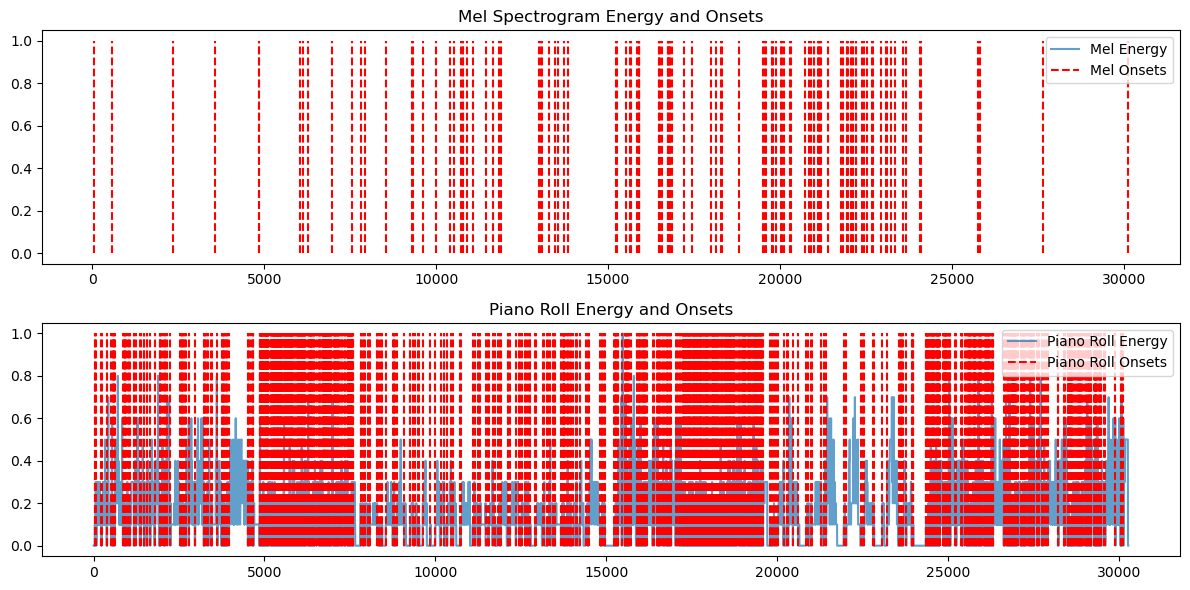

Visualizing: 1file [00:00,  1.36file/s]

Debugging pair: MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav_mel.npy vs MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav_roll.npy


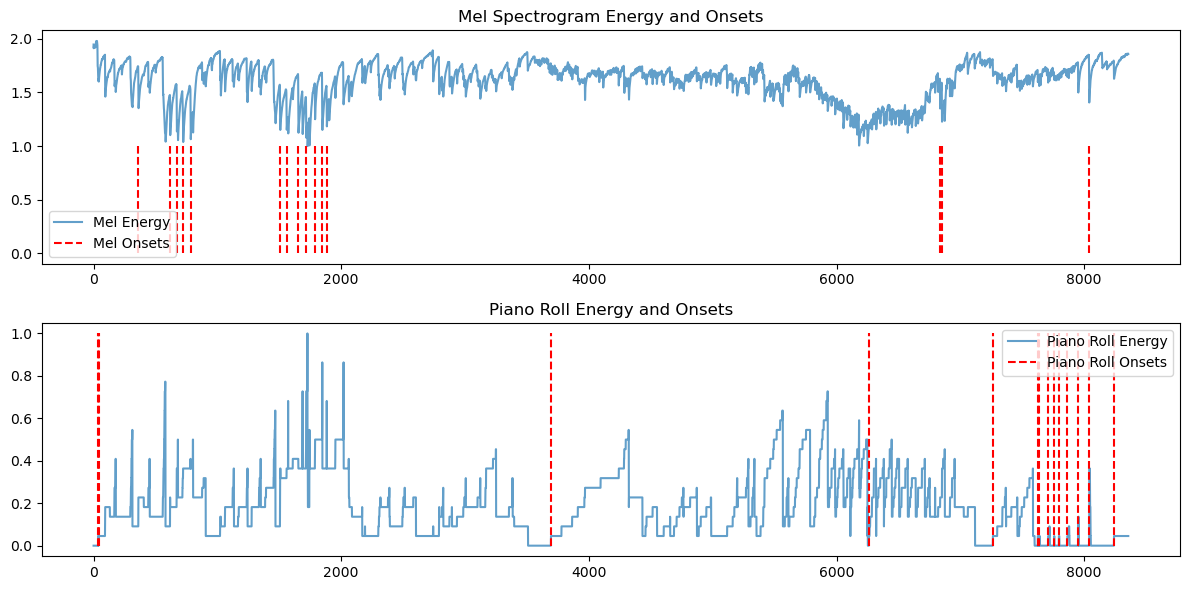

Visualizing: 2file [00:01,  1.87file/s]

Debugging pair: MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_08_Track08_wav_mel.npy vs MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_08_Track08_wav_roll.npy


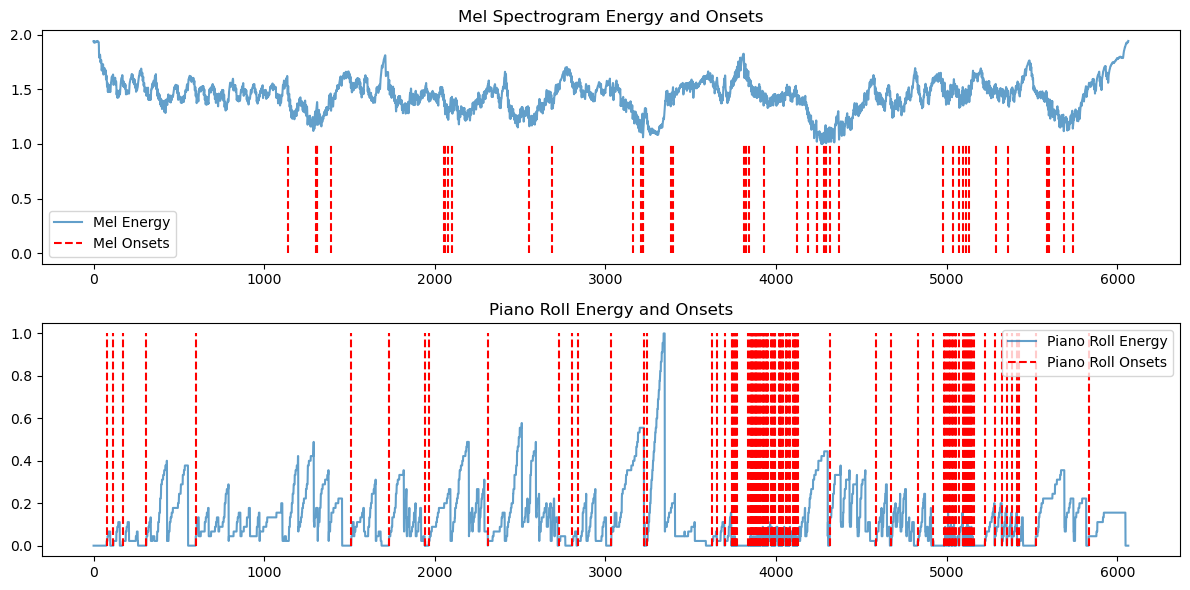

Visualizing: 3file [00:01,  1.95file/s]


In [26]:
import os
import numpy as np
import librosa
import pretty_midi
import matplotlib.pyplot as plt
from tqdm import tqdm

# Paths to the preprocessed files
mel_dir = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004/preprocessed_mel_spectrograms"
piano_roll_dir = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004/preprocessed_piano_rolls"

# Function to extract onsets from Mel spectrogram
def extract_mel_onsets(mel_spec, sr=16000, hop_length=512):
    onset_env = librosa.onset.onset_strength(S=mel_spec, sr=sr, hop_length=hop_length, aggregate=np.median)
    mel_onsets = librosa.onset.onset_detect(onset_envelope=onset_env, sr=sr, hop_length=hop_length, delta=0.4, backtrack=True)
    return mel_onsets

# Function to extract onsets from piano roll
def extract_piano_roll_onsets(piano_roll):
    return np.where(np.diff(np.any(piano_roll, axis=0).astype(int)) > 0)[0]

# Function to visualize Mel and Piano Roll energy and onsets
def plot_energy_and_onsets(mel_file, piano_roll_file):
    # Load Mel spectrogram and piano roll
    mel_spec = np.load(mel_file)
    piano_roll = np.load(piano_roll_file)

    # Normalize energy patterns
    mel_energy = mel_spec.sum(axis=0)
    mel_energy = mel_energy / np.max(mel_energy)  # Normalize to [0, 1]
    piano_roll_energy = piano_roll.sum(axis=0)
    piano_roll_energy = piano_roll_energy / np.max(piano_roll_energy)  # Normalize to [0, 1]

    # Extract onsets
    mel_onsets = extract_mel_onsets(mel_spec)
    piano_roll_onsets = extract_piano_roll_onsets(piano_roll)

    # Plot the energy and onsets
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(mel_energy, label="Mel Energy", alpha=0.7)
    plt.vlines(mel_onsets, 0, 1, colors="r", linestyle="--", label="Mel Onsets")
    plt.legend()
    plt.title("Mel Spectrogram Energy and Onsets")

    plt.subplot(2, 1, 2)
    plt.plot(piano_roll_energy, label="Piano Roll Energy", alpha=0.7)
    plt.vlines(piano_roll_onsets, 0, 1, colors="r", linestyle="--", label="Piano Roll Onsets")
    plt.legend()
    plt.title("Piano Roll Energy and Onsets")

    plt.tight_layout()
    plt.show()

# Pick two or three files from the first batch to debug
def debug_visualize(mel_dir, piano_roll_dir):
    mel_files = sorted([os.path.join(mel_dir, f) for f in os.listdir(mel_dir) if f.endswith("_mel.npy")])
    piano_roll_files = sorted([os.path.join(piano_roll_dir, f) for f in os.listdir(piano_roll_dir) if f.endswith("_roll.npy")])

    # Match Mel and Piano Roll pairs
    for mel_file, piano_roll_file in tqdm(zip(mel_files[:3], piano_roll_files[:3]), desc="Visualizing", unit="file"):
        print(f"Debugging pair: {os.path.basename(mel_file)} vs {os.path.basename(piano_roll_file)}")
        plot_energy_and_onsets(mel_file, piano_roll_file)

# Run visualization on the first 3 files
debug_visualize(mel_dir, piano_roll_dir)

In [20]:
import os
import numpy as np
import librosa
import pretty_midi
from tqdm import tqdm
from scipy.ndimage import zoom

# Directory containing the subfolder for the year 2004
base_dir = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004"

# Output directories for preprocessed data
mel_output_dir = os.path.join(base_dir, "preprocessed_mel_spectrograms")
piano_roll_output_dir = os.path.join(base_dir, "preprocessed_piano_rolls")

# Function to delete old files in the output directories
def clean_output_directory(directory):
    if os.path.exists(directory):
        for file in os.listdir(directory):
            file_path = os.path.join(directory, file)
            os.remove(file_path)
        print(f"Cleaned directory: {directory}")
    else:
        os.makedirs(directory)
        print(f"Created directory: {directory}")

clean_output_directory(mel_output_dir)
clean_output_directory(piano_roll_output_dir)

# Function to compute and save Mel spectrograms
def audio_to_mel_spectrogram(audio_path, output_dir, n_mels=229, sr=16000, fft_window=2048, hop_length=512):
    try:
        y, sr = librosa.load(audio_path, sr=sr)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=fft_window, hop_length=hop_length, n_mels=n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to decibels
        
        # Save Mel spectrogram as .npy file
        file_name = os.path.basename(audio_path).replace(".wav", "_mel.npy")
        output_path = os.path.join(output_dir, file_name)
        np.save(output_path, mel_spec_db)
        return mel_spec_db
    except Exception as e:
        print(f"Error processing audio file {audio_path}: {e}")
        return None

# Function to convert and save MIDI to piano roll
def midi_to_piano_roll(midi_path, output_dir, hop_length=512, sr=16000):
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_path)
        time_step = hop_length / sr  # Frame duration in seconds
        piano_roll = midi_data.get_piano_roll(fs=1/time_step)[21:109]  # Extract 88 piano keys (A0 to C8)
        
        # Dynamic velocity threshold to filter out noise
        velocity_threshold = np.percentile(piano_roll[piano_roll > 0], 30)  # Use higher threshold (e.g., 30th percentile)
        piano_roll = (piano_roll > velocity_threshold).astype(np.float32)
        
        # Save Piano roll as .npy file
        file_name = os.path.basename(midi_path).replace(".midi", "_roll.npy").replace(".mid", "_roll.npy")
        output_path = os.path.join(output_dir, file_name)
        np.save(output_path, piano_roll)
        return piano_roll
    except Exception as e:
        print(f"Error processing MIDI file {midi_path}: {e}")
        return None

# Function to dynamically align Mel spectrogram and piano roll
def align_mel_and_piano_roll(mel_spec, piano_roll, hop_length=512, sr=16000):
    mel_frames = mel_spec.shape[1]
    piano_roll_frames = piano_roll.shape[1]

    # Calculate durations and log for debugging
    mel_duration = mel_frames * hop_length / sr
    piano_roll_duration = piano_roll_frames * (hop_length / sr)
    print(f"Mel duration: {mel_duration:.5f}s, Piano roll duration: {piano_roll_duration:.5f}s")

    # Align frame counts using interpolation
    if mel_frames != piano_roll_frames:
        mel_spec = zoom(mel_spec, (1, piano_roll_frames / mel_frames), order=1)
        piano_roll = zoom(piano_roll, (1, mel_frames / piano_roll_frames), order=1)

    return mel_spec, piano_roll

# Process and align only the first 5 .wav and corresponding .mid/.midi files
def preprocess_and_align_first_5_files(base_dir, mel_output_dir, piano_roll_output_dir):
    processed_count = 0
    for root, _, files in os.walk(base_dir):
        audio_files = [f for f in files if f.endswith(".wav")]
        midi_files = [f for f in files if f.endswith(".mid") or f.endswith(".midi")]

        with tqdm(total=min(5, len(audio_files)), desc=f"Processing in {root}", unit="file") as pbar:
            for audio_file in audio_files:
                if processed_count >= 5:  # Limit to 5 files
                    break

                audio_path = os.path.join(root, audio_file)
                
                # Find corresponding MIDI file
                midi_file_mid = audio_file.replace(".wav", ".mid")
                midi_file_midi = audio_file.replace(".wav", ".midi")
                midi_path = None
                if midi_file_mid in midi_files:
                    midi_path = os.path.join(root, midi_file_mid)
                elif midi_file_midi in midi_files:
                    midi_path = os.path.join(root, midi_file_midi)

                if midi_path:
                    # Process Mel spectrogram and piano roll
                    mel_spec = audio_to_mel_spectrogram(audio_path, mel_output_dir)
                    piano_roll = midi_to_piano_roll(midi_path, piano_roll_output_dir)

                    if mel_spec is not None and piano_roll is not None:
                        # Align and save the synchronized outputs
                        mel_spec_aligned, piano_roll_aligned = align_mel_and_piano_roll(mel_spec, piano_roll)
                        
                        # Save aligned files
                        mel_file_name = os.path.basename(audio_path).replace(".wav", "_mel.npy")
                        piano_roll_file_name = os.path.basename(midi_path).replace(".mid", "_roll.npy").replace(".midi", "_roll.npy")
                        np.save(os.path.join(mel_output_dir, mel_file_name), mel_spec_aligned)
                        np.save(os.path.join(piano_roll_output_dir, piano_roll_file_name), piano_roll_aligned)

                        processed_count += 1  # Increment processed count
                else:
                    print(f"No corresponding MIDI file found for {audio_file}")
                    with open("missing_midi_files.log", "a") as log_file:
                        log_file.write(f"No MIDI file for {audio_file}\n")

                # Update progress bar
                pbar.update(1)

# Execute preprocessing for the first 5 files in the 2004 subfolder
preprocess_and_align_first_5_files(base_dir, mel_output_dir, piano_roll_output_dir)

print("Data preprocessing for first 5 files complete!")

Cleaned directory: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004/preprocessed_mel_spectrograms
Cleaned directory: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004/preprocessed_piano_rolls


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:   0%| | 0/5 [0

Mel duration: 969.63200s, Piano roll duration: 968.99200s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  20%|▏| 1/5 [0

Mel duration: 552.67200s, Piano roll duration: 551.77600s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  40%|▍| 2/5 [0

Mel duration: 267.45600s, Piano roll duration: 267.42400s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  80%|▊| 4/5 [0

Mel duration: 194.59200s, Piano roll duration: 194.08000s
Mel duration: 339.26400s, Piano roll duration: 338.24000s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004: 100%|█| 5/5 [0
Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004/preprocessed_mel_spectrograms: 0file [00:00, ?file/s]
Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004/preprocessed_piano_rolls: 0file [00:00, ?file/s]

Data preprocessing for first 5 files complete!


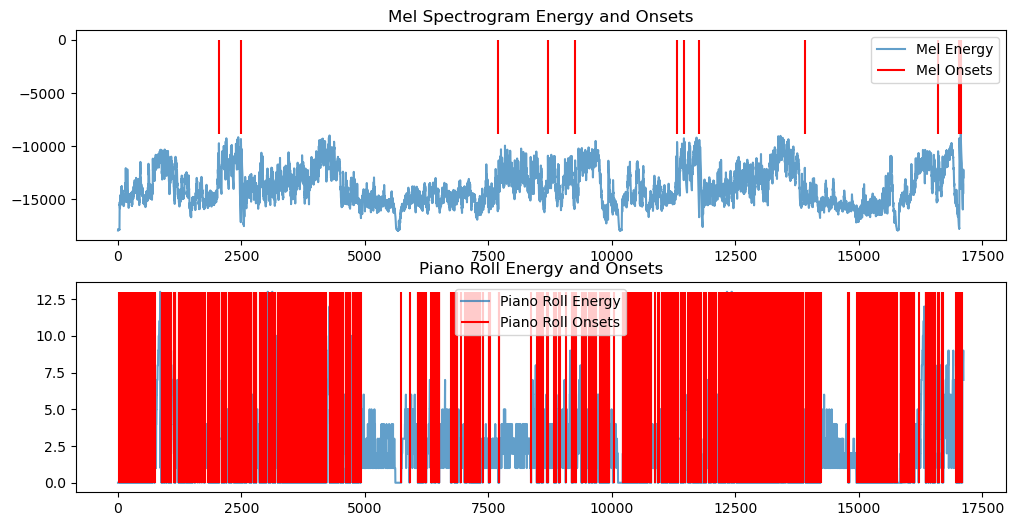

In [15]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt

# Paths to specific Mel spectrogram and piano roll files
mel_file_path = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004/preprocessed_mel_spectrograms/MIDI-Unprocessed_XP_22_R2_2004_01_ORIG_MID--AUDIO_22_R2_2004_04_Track04_wav_mel.npy"

piano_roll_file_path = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004/preprocessed_piano_rolls/MIDI-Unprocessed_XP_22_R2_2004_01_ORIG_MID--AUDIO_22_R2_2004_04_Track04_wav_roll.npy"

# Function to extract onsets from Mel spectrogram
def extract_mel_onsets(mel_spec, sr=16000, hop_length=512):
    onset_env = librosa.onset.onset_strength(S=mel_spec, sr=sr, hop_length=hop_length, aggregate=np.median)
    onsets = librosa.onset.onset_detect(onset_envelope=onset_env, sr=sr, hop_length=hop_length, backtrack=True, pre_max=10, post_max=10, delta=0.3)
    return onsets

# Function to extract onsets from piano roll
def extract_piano_roll_onsets(piano_roll):
    return np.where(np.diff(np.any(piano_roll, axis=0).astype(int)) > 0)[0]

# Function to plot energy and onsets
def plot_energy_and_onsets(mel_spec, piano_roll, mel_onsets, piano_roll_onsets):
    mel_energy = mel_spec.sum(axis=0)
    piano_roll_energy = piano_roll.sum(axis=0)
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(mel_energy, label="Mel Energy", alpha=0.7)
    plt.vlines(mel_onsets, 0, np.max(mel_energy), colors="r", label="Mel Onsets")
    plt.legend()
    plt.title("Mel Spectrogram Energy and Onsets")
    plt.subplot(2, 1, 2)
    plt.plot(piano_roll_energy, label="Piano Roll Energy", alpha=0.7)
    plt.vlines(piano_roll_onsets, 0, np.max(piano_roll_energy), colors="r", label="Piano Roll Onsets")
    plt.legend()
    plt.title("Piano Roll Energy and Onsets")
    plt.show()

# Load Mel spectrogram and piano roll
mel_spec = np.load(mel_file_path)
piano_roll = np.load(piano_roll_file_path)

# Normalize energy patterns
mel_energy = mel_spec.sum(axis=0)
mel_energy = mel_energy / np.max(mel_energy)  # Normalize to [0, 1]
piano_roll_energy = piano_roll.sum(axis=0)
piano_roll_energy = piano_roll_energy / np.max(piano_roll_energy)  # Normalize to [0, 1]

# Extract onsets
mel_onsets = extract_mel_onsets(mel_spec)
piano_roll_onsets = extract_piano_roll_onsets(piano_roll)

# Plot energy and onsets
plot_energy_and_onsets(mel_spec, piano_roll, mel_onsets, piano_roll_onsets)

In [7]:
import os
import numpy as np

# Directories for preprocessed Mel spectrograms and piano rolls
mel_output_dir = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/preprocessed_mel_spectrograms"
piano_roll_output_dir = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/preprocessed_piano_rolls"

# Directory to save the aligned versions
aligned_mel_dir = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms"
aligned_piano_roll_dir = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls"

# Create directories if they don't exist
os.makedirs(aligned_mel_dir, exist_ok=True)
os.makedirs(aligned_piano_roll_dir, exist_ok=True)

# Function to align Mel spectrogram and piano roll
def align_and_save(mel_file, piano_roll_file):
    try:
        # Load Mel spectrogram and piano roll
        mel_spec = np.load(mel_file)
        piano_roll = np.load(piano_roll_file)
        
        # Find the minimum number of time frames
        min_frames = min(mel_spec.shape[1], piano_roll.shape[1])
        
        # Trim both to the same number of time frames
        mel_spec_aligned = mel_spec[:, :min_frames]
        piano_roll_aligned = piano_roll[:, :min_frames]
        
        # Save the aligned versions
        mel_filename = os.path.basename(mel_file)
        piano_roll_filename = os.path.basename(piano_roll_file)
        
        aligned_mel_path = os.path.join(aligned_mel_dir, mel_filename)
        aligned_piano_roll_path = os.path.join(aligned_piano_roll_dir, piano_roll_filename)
        
        np.save(aligned_mel_path, mel_spec_aligned)
        np.save(aligned_piano_roll_path, piano_roll_aligned)
        
        print(f"Aligned and saved: {aligned_mel_path} and {aligned_piano_roll_path}")
        
        # Return shapes for verification
        return mel_spec_aligned.shape, piano_roll_aligned.shape
    except Exception as e:
        print(f"Error aligning {mel_file} and {piano_roll_file}: {e}")
        return None, None

# List all preprocessed files and align
mel_files = sorted([f for f in os.listdir(mel_output_dir) if f.endswith(".npy")])
piano_roll_files = sorted([f for f in os.listdir(piano_roll_output_dir) if f.endswith(".npy")])

# Ensure alignment is done for corresponding file pairs
for mel_file, piano_roll_file in zip(mel_files, piano_roll_files):
    mel_file_path = os.path.join(mel_output_dir, mel_file)
    piano_roll_file_path = os.path.join(piano_roll_output_dir, piano_roll_file)
    
    mel_shape, piano_roll_shape = align_and_save(mel_file_path, piano_roll_file_path)
    
    if mel_shape and piano_roll_shape:
        print(f"Aligned Shapes - Mel: {mel_shape}, Piano Roll: {piano_roll_shape}")
        if mel_shape[1] != piano_roll_shape[1]:
            print("Warning: Alignment failed!")
    else:
        print("Skipping due to error.")

print("Alignment and saving complete!")


Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--1_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--1_roll.npy
Aligned Shapes - Mel: (229, 4271), Piano Roll: (88, 4271)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--2_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--2_roll.npy
Aligned Shapes - Mel: (229, 4653), Piano Roll: (88, 4653)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--3_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--3_ro

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_05_R1_2014_wav--8_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_05_R1_2014_wav--8_roll.npy
Aligned Shapes - Mel: (229, 32303), Piano Roll: (88, 32303)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-UNPROCESSED_04-07-08-10-12-15-17_R2_2014_MID--AUDIO_04_R2_2014_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-UNPROCESSED_04-07-08-10-12-15-17_R2_2014_MID--AUDIO_04_R2_2014_wav_roll.npy
Aligned Shapes - Mel: (229, 69190), Piano Roll: (88, 69190)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-UNPROCESSED_04-07-08-10-12-15-17_R2_2014_MID--AUDIO_07_R2_2014_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-UNPROCESSED_04-07

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-UNPROCESSED_06-08_R1_2014_MID--AUDIO_08_R1_2014_wav--2_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-UNPROCESSED_06-08_R1_2014_MID--AUDIO_08_R1_2014_wav--2_roll.npy
Aligned Shapes - Mel: (229, 76983), Piano Roll: (88, 76983)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-UNPROCESSED_09-10_R1_2014_MID--AUDIO_09_R1_2014_wav--1_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-UNPROCESSED_09-10_R1_2014_MID--AUDIO_09_R1_2014_wav--1_roll.npy
Aligned Shapes - Mel: (229, 24727), Piano Roll: (88, 24727)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-UNPROCESSED_09-10_R1_2014_MID--AUDIO_09_R1_2014_wav--2_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-UNPROCESSED_09-10_R1_2014_MID--AUDIO_09_R1_2014_wav--

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-UNPROCESSED_14-15_R1_2014_MID--AUDIO_15_R1_2014_wav--3_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-UNPROCESSED_14-15_R1_2014_MID--AUDIO_15_R1_2014_wav--3_roll.npy
Aligned Shapes - Mel: (229, 11425), Piano Roll: (88, 11425)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-UNPROCESSED_14-15_R1_2014_MID--AUDIO_15_R1_2014_wav--4_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-UNPROCESSED_14-15_R1_2014_MID--AUDIO_15_R1_2014_wav--4_roll.npy
Aligned Shapes - Mel: (229, 9997), Piano Roll: (88, 9997)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-UNPROCESSED_14-15_R1_2014_MID--AUDIO_15_R1_2014_wav--5_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-UNPROCESSED_14-15_R1_2014_MID--AUDIO_15_R1_2014_wav--5_

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-UNPROCESSED_19-21_R3_2014_MID--AUDIO_21_R3_2014_wav--2_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-UNPROCESSED_19-21_R3_2014_MID--AUDIO_21_R3_2014_wav--2_roll.npy
Aligned Shapes - Mel: (229, 6450), Piano Roll: (88, 6450)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-UNPROCESSED_21-22_R1_2014_MID--AUDIO_21_R1_2014_wav--1_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-UNPROCESSED_21-22_R1_2014_MID--AUDIO_21_R1_2014_wav--1_roll.npy
Aligned Shapes - Mel: (229, 3483), Piano Roll: (88, 3483)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-UNPROCESSED_21-22_R1_2014_MID--AUDIO_21_R1_2014_wav--2_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-UNPROCESSED_21-22_R1_2014_MID--AUDIO_21_R1_2014_wav--2_ro

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_01_R1_2011_MID--AUDIO_R1-D1_03_Track03_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_01_R1_2011_MID--AUDIO_R1-D1_03_Track03_wav_roll.npy
Aligned Shapes - Mel: (229, 5369), Piano Roll: (88, 5369)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_01_R1_2011_MID--AUDIO_R1-D1_04_Track04_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_01_R1_2011_MID--AUDIO_R1-D1_04_Track04_wav_roll.npy
Aligned Shapes - Mel: (229, 10208), Piano Roll: (88, 10208)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_01_R1_2011_MID--AUDIO_R1-D1_05_Track05_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_01_R1_2011_MID--AUDIO_R1-D1_05_Track05_wav_

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_02_R2_2008_01-05_ORIG_MID--AUDIO_02_R2_2008_wav--1_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_02_R2_2008_01-05_ORIG_MID--AUDIO_02_R2_2008_wav--1_roll.npy
Aligned Shapes - Mel: (229, 6980), Piano Roll: (88, 6980)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_02_R2_2008_01-05_ORIG_MID--AUDIO_02_R2_2008_wav--3_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_02_R2_2008_01-05_ORIG_MID--AUDIO_02_R2_2008_wav--3_roll.npy
Aligned Shapes - Mel: (229, 7615), Piano Roll: (88, 7615)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_02_R2_2008_01-05_ORIG_MID--AUDIO_02_R2_2008_wav--4_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_02_R2

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_03_R1_2011_MID--AUDIO_R1-D1_16_Track16_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_03_R1_2011_MID--AUDIO_R1-D1_16_Track16_wav_roll.npy
Aligned Shapes - Mel: (229, 6422), Piano Roll: (88, 6422)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_03_R1_2011_MID--AUDIO_R1-D1_17_Track17_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_03_R1_2011_MID--AUDIO_R1-D1_17_Track17_wav_roll.npy
Aligned Shapes - Mel: (229, 3640), Piano Roll: (88, 3640)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_03_R1_2011_MID--AUDIO_R1-D1_18_Track18_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_03_R1_2011_MID--AUDIO_R1-D1_18_Track18_wav_ro

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_042_PIANO042_MID--AUDIO-split_07-06-17_Piano-e_1-02_wav--3_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_042_PIANO042_MID--AUDIO-split_07-06-17_Piano-e_1-02_wav--3_roll.npy
Aligned Shapes - Mel: (229, 11014), Piano Roll: (88, 11014)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_043_PIANO043_MID--AUDIO-split_07-06-17_Piano-e_1-03_wav--1_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_043_PIANO043_MID--AUDIO-split_07-06-17_Piano-e_1-03_wav--1_roll.npy
Aligned Shapes - Mel: (229, 12056), Piano Roll: (88, 12056)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_043_PIANO043_MID--AUDIO-split_07-06-17_Piano-e_1-03_wav--2_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_048_PIANO048_MID--AUDIO-split_07-06-17_Piano-e_2-05_wav--4_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_048_PIANO048_MID--AUDIO-split_07-06-17_Piano-e_2-05_wav--4_roll.npy
Aligned Shapes - Mel: (229, 19562), Piano Roll: (88, 19562)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_049_PIANO049_MID--AUDIO-split_07-06-17_Piano-e_2-06_wav--1_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_049_PIANO049_MID--AUDIO-split_07-06-17_Piano-e_2-06_wav--1_roll.npy
Aligned Shapes - Mel: (229, 7218), Piano Roll: (88, 7218)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_049_PIANO049_MID--AUDIO-split_07-06-17_Piano-e_2-06_wav--2_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_04_R2_2008_01-04_ORIG_MID--AUDIO_04_R2_2008_wav--3_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_04_R2_2008_01-04_ORIG_MID--AUDIO_04_R2_2008_wav--3_roll.npy
Aligned Shapes - Mel: (229, 12599), Piano Roll: (88, 12599)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_04_R2_2008_01-04_ORIG_MID--AUDIO_04_R2_2008_wav--4_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_04_R2_2008_01-04_ORIG_MID--AUDIO_04_R2_2008_wav--4_roll.npy
Aligned Shapes - Mel: (229, 24907), Piano Roll: (88, 24907)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_04_R2_2011_MID--AUDIO_R2-D2_02_Track02_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_04_R2_201

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_051_PIANO051_MID--AUDIO-split_07-06-17_Piano-e_3-02_wav--4_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_051_PIANO051_MID--AUDIO-split_07-06-17_Piano-e_3-02_wav--4_roll.npy
Aligned Shapes - Mel: (229, 20052), Piano Roll: (88, 20052)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_051_PIANO051_MID--AUDIO-split_07-06-17_Piano-e_3-02_wav--5_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_051_PIANO051_MID--AUDIO-split_07-06-17_Piano-e_3-02_wav--5_roll.npy
Aligned Shapes - Mel: (229, 7237), Piano Roll: (88, 7237)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_052_PIANO052_MID--AUDIO-split_07-06-17_Piano-e_3-03_wav--1_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_057_PIANO057_MID--AUDIO-split_07-07-17_Piano-e_1-07_wav--2_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_057_PIANO057_MID--AUDIO-split_07-07-17_Piano-e_1-07_wav--2_roll.npy
Aligned Shapes - Mel: (229, 12043), Piano Roll: (88, 12043)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_057_PIANO057_MID--AUDIO-split_07-07-17_Piano-e_1-07_wav--3_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_057_PIANO057_MID--AUDIO-split_07-07-17_Piano-e_1-07_wav--3_roll.npy
Aligned Shapes - Mel: (229, 9458), Piano Roll: (88, 9458)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_057_PIANO057_MID--AUDIO-split_07-07-17_Piano-e_1-07_wav--4_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_05_R1_2009_03-05_ORIG_MID--AUDIO_05_R1_2009_05_R1_2009_03_WAV_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_05_R1_2009_03-05_ORIG_MID--AUDIO_05_R1_2009_05_R1_2009_03_WAV_roll.npy
Aligned Shapes - Mel: (229, 59183), Piano Roll: (88, 59183)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_05_R1_2011_MID--AUDIO_R1-D2_08_Track08_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_05_R1_2011_MID--AUDIO_R1-D2_08_Track08_wav_roll.npy
Aligned Shapes - Mel: (229, 3558), Piano Roll: (88, 3558)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_05_R1_2011_MID--AUDIO_R1-D2_09_Track09_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_05_R1

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_065_PIANO065_MID--AUDIO-split_07-07-17_Piano-e_3-01_wav--2_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_065_PIANO065_MID--AUDIO-split_07-07-17_Piano-e_3-01_wav--2_roll.npy
Aligned Shapes - Mel: (229, 14076), Piano Roll: (88, 14076)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_065_PIANO065_MID--AUDIO-split_07-07-17_Piano-e_3-01_wav--3_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_065_PIANO065_MID--AUDIO-split_07-07-17_Piano-e_3-01_wav--3_roll.npy
Aligned Shapes - Mel: (229, 8358), Piano Roll: (88, 8358)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-split_07-07-17_Piano-e_3-02_wav--1_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_06_R1_2009_03-07_ORIG_MID--AUDIO_06_R1_2009_06_R1_2009_06_WAV_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_06_R1_2009_03-07_ORIG_MID--AUDIO_06_R1_2009_06_R1_2009_06_WAV_roll.npy
Aligned Shapes - Mel: (229, 23964), Piano Roll: (88, 23964)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_06_R1_2009_03-07_ORIG_MID--AUDIO_06_R1_2009_06_R1_2009_07_WAV_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_06_R1_2009_03-07_ORIG_MID--AUDIO_06_R1_2009_06_R1_2009_07_WAV_roll.npy
Aligned Shapes - Mel: (229, 17720), Piano Roll: (88, 17720)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_06_R1_2011_MID--AUDIO_R1-D2_14_Track14_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/al

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_072_PIANO072_MID--AUDIO-split_07-08-17_Piano-e_1-06_wav--1_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_072_PIANO072_MID--AUDIO-split_07-08-17_Piano-e_1-06_wav--1_roll.npy
Aligned Shapes - Mel: (229, 20951), Piano Roll: (88, 20951)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_072_PIANO072_MID--AUDIO-split_07-08-17_Piano-e_1-06_wav--2_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_072_PIANO072_MID--AUDIO-split_07-08-17_Piano-e_1-06_wav--2_roll.npy
Aligned Shapes - Mel: (229, 11772), Piano Roll: (88, 11772)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_072_PIANO072_MID--AUDIO-split_07-08-17_Piano-e_1-06_wav--3_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_07_R1_2006_01-04_ORIG_MID--AUDIO_07_R1_2006_03_Track03_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_07_R1_2006_01-04_ORIG_MID--AUDIO_07_R1_2006_03_Track03_wav_roll.npy
Aligned Shapes - Mel: (229, 45110), Piano Roll: (88, 45110)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_07_R1_2006_01-04_ORIG_MID--AUDIO_07_R1_2006_04_Track04_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_07_R1_2006_01-04_ORIG_MID--AUDIO_07_R1_2006_04_Track04_wav_roll.npy
Aligned Shapes - Mel: (229, 31117), Piano Roll: (88, 31117)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_07_R1_2008_01-04_ORIG_MID--AUDIO_07_R1_2008_wav--1_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligne

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_07_R2_2009_01_ORIG_MID--AUDIO_07_R2_2009_07_R2_2009_01_WAV_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_07_R2_2009_01_ORIG_MID--AUDIO_07_R2_2009_07_R2_2009_01_WAV_roll.npy
Aligned Shapes - Mel: (229, 15036), Piano Roll: (88, 15036)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_07_R2_2009_01_ORIG_MID--AUDIO_07_R2_2009_07_R2_2009_02_WAV_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_07_R2_2009_01_ORIG_MID--AUDIO_07_R2_2009_07_R2_2009_02_WAV_roll.npy
Aligned Shapes - Mel: (229, 14810), Piano Roll: (88, 14810)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_07_R2_2009_01_ORIG_MID--AUDIO_07_R2_2009_07_R2_2009_03_WAV_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_08_R1_2006_01-04_ORIG_MID--AUDIO_08_R1_2006_Disk1_01_Track01_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_08_R1_2006_01-04_ORIG_MID--AUDIO_08_R1_2006_Disk1_01_Track01_wav_roll.npy
Aligned Shapes - Mel: (229, 17453), Piano Roll: (88, 17453)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_08_R1_2006_01-04_ORIG_MID--AUDIO_08_R1_2006_Disk1_02_Track02_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_08_R1_2006_01-04_ORIG_MID--AUDIO_08_R1_2006_Disk1_02_Track02_wav_roll.npy
Aligned Shapes - Mel: (229, 17453), Piano Roll: (88, 17453)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_08_R1_2006_01-04_ORIG_MID--AUDIO_08_R1_2006_Disk1_03_Track03_wav_mel.npy and /nfsshare/selv

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_08_R2_2008_01-04_ORIG_MID--AUDIO_08_R2_2008_wav--4_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_08_R2_2008_01-04_ORIG_MID--AUDIO_08_R2_2008_wav--4_roll.npy
Aligned Shapes - Mel: (229, 8204), Piano Roll: (88, 8204)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_08_R2_2009_01_ORIG_MID--AUDIO_08_R2_2009_08_R2_2009_01_WAV_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_08_R2_2009_01_ORIG_MID--AUDIO_08_R2_2009_08_R2_2009_01_WAV_roll.npy
Aligned Shapes - Mel: (229, 24231), Piano Roll: (88, 24231)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_08_R2_2009_01_ORIG_MID--AUDIO_08_R2_2009_08_R2_2009_02_WAV_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_ro

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_09_R1_2011_MID--AUDIO_R1-D3_12_Track12_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_09_R1_2011_MID--AUDIO_R1-D3_12_Track12_wav_roll.npy
Aligned Shapes - Mel: (229, 10862), Piano Roll: (88, 10862)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_09_R1_2011_MID--AUDIO_R1-D3_13_Track13_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_09_R1_2011_MID--AUDIO_R1-D3_13_Track13_wav_roll.npy
Aligned Shapes - Mel: (229, 8716), Piano Roll: (88, 8716)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_09_R1_2011_MID--AUDIO_R1-D3_14_Track14_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_09_R1_2011_MID--AUDIO_R1-D3_14_Track14_wav_

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_10_R1_2006_01-04_ORIG_MID--AUDIO_10_R1_2006_02_Track02_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_10_R1_2006_01-04_ORIG_MID--AUDIO_10_R1_2006_02_Track02_wav_roll.npy
Aligned Shapes - Mel: (229, 43936), Piano Roll: (88, 43936)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_10_R1_2006_01-04_ORIG_MID--AUDIO_10_R1_2006_03_Track03_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_10_R1_2006_01-04_ORIG_MID--AUDIO_10_R1_2006_03_Track03_wav_roll.npy
Aligned Shapes - Mel: (229, 39472), Piano Roll: (88, 39472)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_10_R1_2006_01-04_ORIG_MID--AUDIO_10_R1_2006_05_Track05_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_10_R2_2011_MID--AUDIO_R2-D3_10_Track10_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_10_R2_2011_MID--AUDIO_R2-D3_10_Track10_wav_roll.npy
Aligned Shapes - Mel: (229, 21756), Piano Roll: (88, 21756)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_10_R2_2011_MID--AUDIO_R2-D3_11_Track11_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_10_R2_2011_MID--AUDIO_R2-D3_11_Track11_wav_roll.npy
Aligned Shapes - Mel: (229, 13262), Piano Roll: (88, 13262)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_10_R3_2008_01-05_ORIG_MID--AUDIO_10_R3_2008_wav--1_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_10_R3_2008_01-05_ORIG_MID--AUDIO_

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_11_R1_2011_MID--AUDIO_R1-D4_07_Track07_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_11_R1_2011_MID--AUDIO_R1-D4_07_Track07_wav_roll.npy
Aligned Shapes - Mel: (229, 9332), Piano Roll: (88, 9332)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_11_R1_2011_MID--AUDIO_R1-D4_08_Track08_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_11_R1_2011_MID--AUDIO_R1-D4_08_Track08_wav_roll.npy
Aligned Shapes - Mel: (229, 16253), Piano Roll: (88, 16253)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_11_R1_2011_MID--AUDIO_R1-D4_09_Track09_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_11_R1_2011_MID--AUDIO_R1-D4_09_Track09_wav_

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_12_R1_2008_01-04_ORIG_MID--AUDIO_12_R1_2008_wav--4_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_12_R1_2008_01-04_ORIG_MID--AUDIO_12_R1_2008_wav--4_roll.npy
Aligned Shapes - Mel: (229, 20992), Piano Roll: (88, 20992)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_12_R1_2009_01-02_ORIG_MID--AUDIO_12_R1_2009_12_R1_2009_01_WAV_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_12_R1_2009_01-02_ORIG_MID--AUDIO_12_R1_2009_12_R1_2009_01_WAV_roll.npy
Aligned Shapes - Mel: (229, 26789), Piano Roll: (88, 26789)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_12_R1_2009_03-05_ORIG_MID--AUDIO_12_R1_2009_12_R1_2009_03_WAV_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/align

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_12_R3_2011_MID--AUDIO_R3-D4_03_Track03_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_12_R3_2011_MID--AUDIO_R3-D4_03_Track03_wav_roll.npy
Aligned Shapes - Mel: (229, 19649), Piano Roll: (88, 19649)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_12_R3_2011_MID--AUDIO_R3-D4_04_Track04_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_12_R3_2011_MID--AUDIO_R3-D4_04_Track04_wav_roll.npy
Aligned Shapes - Mel: (229, 18192), Piano Roll: (88, 18192)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_12_R3_2011_MID--AUDIO_R3-D4_07_Track07_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_12_R3_2011_MID--AUDIO_R3-D4_07_Track07_wa

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_14_R1_2008_01-05_ORIG_MID--AUDIO_14_R1_2008_wav--1_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_14_R1_2008_01-05_ORIG_MID--AUDIO_14_R1_2008_wav--1_roll.npy
Aligned Shapes - Mel: (229, 7201), Piano Roll: (88, 7201)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_14_R1_2008_01-05_ORIG_MID--AUDIO_14_R1_2008_wav--2_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_14_R1_2008_01-05_ORIG_MID--AUDIO_14_R1_2008_wav--2_roll.npy
Aligned Shapes - Mel: (229, 8358), Piano Roll: (88, 8358)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_14_R1_2008_01-05_ORIG_MID--AUDIO_14_R1_2008_wav--3_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_14_R1

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_15_R1_2009_03-06_ORIG_MID--AUDIO_15_R1_2009_15_R1_2009_03_WAV_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_15_R1_2009_03-06_ORIG_MID--AUDIO_15_R1_2009_15_R1_2009_03_WAV_roll.npy
Aligned Shapes - Mel: (229, 28915), Piano Roll: (88, 28915)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_15_R1_2009_03-06_ORIG_MID--AUDIO_15_R1_2009_15_R1_2009_05_WAV_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_15_R1_2009_03-06_ORIG_MID--AUDIO_15_R1_2009_15_R1_2009_05_WAV_roll.npy
Aligned Shapes - Mel: (229, 11927), Piano Roll: (88, 11927)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_15_R1_2009_03-06_ORIG_MID--AUDIO_15_R1_2009_15_R1_2009_06_WAV_mel.npy and /nfsshare/selva/maestro-v3.0.

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_16_R1_2011_MID--AUDIO_R1-D6_14_Track14_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_16_R1_2011_MID--AUDIO_R1-D6_14_Track14_wav_roll.npy
Aligned Shapes - Mel: (229, 12482), Piano Roll: (88, 12482)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_16_R1_2011_MID--AUDIO_R1-D6_15_Track15_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_16_R1_2011_MID--AUDIO_R1-D6_15_Track15_wav_roll.npy
Aligned Shapes - Mel: (229, 11232), Piano Roll: (88, 11232)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_16_R2_2006_01_ORIG_MID--AUDIO_16_R2_2006_01_Track01_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_16_R2_2006_01_ORIG_MID--AUDI

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_17_R1_2009_04_ORIG_MID--AUDIO_17_R1_2009_17_R1_2009_04_WAV_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_17_R1_2009_04_ORIG_MID--AUDIO_17_R1_2009_17_R1_2009_04_WAV_roll.npy
Aligned Shapes - Mel: (229, 82126), Piano Roll: (88, 82126)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_17_R1_2011_MID--AUDIO_R1-D7_02_Track02_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_17_R1_2011_MID--AUDIO_R1-D7_02_Track02_wav_roll.npy
Aligned Shapes - Mel: (229, 4904), Piano Roll: (88, 4904)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_17_R1_2011_MID--AUDIO_R1-D7_03_Track03_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_17_R1_2011_

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_18_R1_2006_01-05_ORIG_MID--AUDIO_18_R1_2006_02_Track02_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_18_R1_2006_01-05_ORIG_MID--AUDIO_18_R1_2006_02_Track02_wav_roll.npy
Aligned Shapes - Mel: (229, 7634), Piano Roll: (88, 7634)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_18_R1_2006_01-05_ORIG_MID--AUDIO_18_R1_2006_03_Track03_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_18_R1_2006_01-05_ORIG_MID--AUDIO_18_R1_2006_03_Track03_wav_roll.npy
Aligned Shapes - Mel: (229, 16092), Piano Roll: (88, 16092)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_18_R1_2006_01-05_ORIG_MID--AUDIO_18_R1_2006_04_Track04_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_19_R1_2011_MID--AUDIO_R1-D7_12_Track12_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_19_R1_2011_MID--AUDIO_R1-D7_12_Track12_wav_roll.npy
Aligned Shapes - Mel: (229, 9882), Piano Roll: (88, 9882)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_19_R1_2011_MID--AUDIO_R1-D7_13_Track13_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_19_R1_2011_MID--AUDIO_R1-D7_13_Track13_wav_roll.npy
Aligned Shapes - Mel: (229, 14112), Piano Roll: (88, 14112)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_19_R1_2011_MID--AUDIO_R1-D7_14_Track14_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_19_R1_2011_MID--AUDIO_R1-D7_14_Track14_wav_

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_21_R1_2011_MID--AUDIO_R1-D8_08_Track08_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_21_R1_2011_MID--AUDIO_R1-D8_08_Track08_wav_roll.npy
Aligned Shapes - Mel: (229, 17791), Piano Roll: (88, 17791)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_21_R1_2011_MID--AUDIO_R1-D8_09_Track09_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_21_R1_2011_MID--AUDIO_R1-D8_09_Track09_wav_roll.npy
Aligned Shapes - Mel: (229, 3879), Piano Roll: (88, 3879)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_21_R1_2011_MID--AUDIO_R1-D8_10_Track10_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_21_R1_2011_MID--AUDIO_R1-D8_10_Track10_wav_

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_22_R3_2011_MID--AUDIO_R3-D7_09_Track09_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_22_R3_2011_MID--AUDIO_R3-D7_09_Track09_wav_roll.npy
Aligned Shapes - Mel: (229, 12611), Piano Roll: (88, 12611)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_23_R1_2006_01-05_ORIG_MID--AUDIO_23_R1_2006_02_Track02_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_23_R1_2006_01-05_ORIG_MID--AUDIO_23_R1_2006_02_Track02_wav_roll.npy
Aligned Shapes - Mel: (229, 25983), Piano Roll: (88, 25983)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_23_R1_2006_01-05_ORIG_MID--AUDIO_23_R1_2006_04_Track04_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unpro

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_24_R1_2011_MID--AUDIO_R1-D9_10_Track10_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_24_R1_2011_MID--AUDIO_R1-D9_10_Track10_wav_roll.npy
Aligned Shapes - Mel: (229, 4604), Piano Roll: (88, 4604)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_24_R1_2011_MID--AUDIO_R1-D9_11_Track11_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_24_R1_2011_MID--AUDIO_R1-D9_11_Track11_wav_roll.npy
Aligned Shapes - Mel: (229, 3900), Piano Roll: (88, 3900)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_25_R1_2011_MID--AUDIO_R1-D9_14_Track14_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_25_R1_2011_MID--AUDIO_R1-D9_14_Track14_wav_ro

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_02_R1_2015_wav--3_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_02_R1_2015_wav--3_roll.npy
Aligned Shapes - Mel: (229, 15202), Piano Roll: (88, 15202)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_02_R1_2015_wav--4_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_02_R1_2015_wav--4_roll.npy
Aligned Shapes - Mel: (229, 5415), Piano Roll: (88, 5415)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_02_R1_2015_wav--5_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_R1_D1-1-8_mid--AUD

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_07_R1_2015_wav--1_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_07_R1_2015_wav--1_roll.npy
Aligned Shapes - Mel: (229, 8662), Piano Roll: (88, 8662)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_07_R1_2015_wav--2_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_07_R1_2015_wav--2_roll.npy
Aligned Shapes - Mel: (229, 15159), Piano Roll: (88, 15159)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_07_R1_2015_wav--3_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_R1_D1-1-8_mid--AUD

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_12_R1_2015_wav--5_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_12_R1_2015_wav--5_roll.npy
Aligned Shapes - Mel: (229, 8212), Piano Roll: (88, 8212)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_13_R1_2015_wav--1_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_13_R1_2015_wav--1_roll.npy
Aligned Shapes - Mel: (229, 5456), Piano Roll: (88, 5456)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_13_R1_2015_wav--2_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_R1_D2-13-20_

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_18_R1_2015_wav--3_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_18_R1_2015_wav--3_roll.npy
Aligned Shapes - Mel: (229, 18718), Piano Roll: (88, 18718)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_18_R1_2015_wav--4_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_18_R1_2015_wav--4_roll.npy
Aligned Shapes - Mel: (229, 17047), Piano Roll: (88, 17047)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_19_R1_2015_wav--1_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_R1_D2-

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_06_R2_2015_wav--4_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_06_R2_2015_wav--4_roll.npy
Aligned Shapes - Mel: (229, 16751), Piano Roll: (88, 16751)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_07_R2_2015_wav--1_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_07_R2_2015_wav--1_roll.npy
Aligned Shapes - Mel: (229, 24098), Piano Roll: (88, 24098)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_07_R2_2015_wav--2_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_R2_D2-19-21-22_mid--AUDIO-from_mp3_19_R2_2015_wav--3_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_R2_D2-19-21-22_mid--AUDIO-from_mp3_19_R2_2015_wav--3_roll.npy
Aligned Shapes - Mel: (229, 11510), Piano Roll: (88, 11510)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_R2_D2-19-21-22_mid--AUDIO-from_mp3_21_R2_2015_wav--1_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_R2_D2-19-21-22_mid--AUDIO-from_mp3_21_R2_2015_wav--1_roll.npy
Aligned Shapes - Mel: (229, 21458), Piano Roll: (88, 21458)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_R2_D2-19-21-22_mid--AUDIO-from_mp3_21_R2_2015_wav--2_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unp

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_Recital13-15_MID--AUDIO_13_R1_2018_wav--1_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_Recital13-15_MID--AUDIO_13_R1_2018_wav--1_roll.npy
Aligned Shapes - Mel: (229, 33483), Piano Roll: (88, 33483)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_Recital13-15_MID--AUDIO_13_R1_2018_wav--2_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_Recital13-15_MID--AUDIO_13_R1_2018_wav--2_roll.npy
Aligned Shapes - Mel: (229, 47756), Piano Roll: (88, 47756)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_Recital13-15_MID--AUDIO_13_R1_2018_wav--3_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_Recital13-15_MID--AUDIO_13_R1_2018_wav--3_roll

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_Recital17-19_MID--AUDIO_19_R1_2018_wav--5_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_Recital17-19_MID--AUDIO_19_R1_2018_wav--5_roll.npy
Aligned Shapes - Mel: (229, 7628), Piano Roll: (88, 7628)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_Recital17-19_MID--AUDIO_19_R1_2018_wav--6_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_Recital17-19_MID--AUDIO_19_R1_2018_wav--6_roll.npy
Aligned Shapes - Mel: (229, 21892), Piano Roll: (88, 21892)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_Recital20_MID--AUDIO_20_R1_2018_wav--3_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_Recital20_MID--AUDIO_20_R1_2018_wav--3_roll.npy
Ali

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_Recital9-11_MID--AUDIO_09_R1_2018_wav--3_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_Recital9-11_MID--AUDIO_09_R1_2018_wav--3_roll.npy
Aligned Shapes - Mel: (229, 9558), Piano Roll: (88, 9558)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_Recital9-11_MID--AUDIO_09_R1_2018_wav--4_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_Recital9-11_MID--AUDIO_09_R1_2018_wav--4_roll.npy
Aligned Shapes - Mel: (229, 8459), Piano Roll: (88, 8459)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_Recital9-11_MID--AUDIO_09_R1_2018_wav--5_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_Recital9-11_MID--AUDIO_09_R1_2018_wav--5_roll.npy
Align

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_SMF_12_01_2004_01-05_ORIG_MID--AUDIO_12_R1_2004_03_Track03_wav--1_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_SMF_12_01_2004_01-05_ORIG_MID--AUDIO_12_R1_2004_03_Track03_wav--1_roll.npy
Aligned Shapes - Mel: (229, 35599), Piano Roll: (88, 35599)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_SMF_12_01_2004_01-05_ORIG_MID--AUDIO_12_R1_2004_07_Track07_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_SMF_12_01_2004_01-05_ORIG_MID--AUDIO_12_R1_2004_07_Track07_wav_roll.npy
Aligned Shapes - Mel: (229, 17243), Piano Roll: (88, 17243)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_SMF_12_01_2004_01-05_ORIG_MID--AUDIO_12_R1_2004_08_Track08_wav_mel.npy and /nfsshare/selva/ma

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_SMF_17_R1_2004_01-03_ORIG_MID--AUDIO_17_R1_2004_02_Track02_wav--1_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_SMF_17_R1_2004_01-03_ORIG_MID--AUDIO_17_R1_2004_02_Track02_wav--1_roll.npy
Aligned Shapes - Mel: (229, 10718), Piano Roll: (88, 10718)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_SMF_17_R1_2004_01-03_ORIG_MID--AUDIO_17_R1_2004_02_Track02_wav--2_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_SMF_17_R1_2004_01-03_ORIG_MID--AUDIO_17_R1_2004_02_Track02_wav--2_roll.npy
Aligned Shapes - Mel: (229, 11607), Piano Roll: (88, 11607)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_SMF_17_R1_2004_01-03_ORIG_MID--AUDIO_17_R1_2004_03_Track03_wav_mel.npy and /nfsshare/se

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_Schubert7-9_MID--AUDIO_11_R2_2018_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_Schubert7-9_MID--AUDIO_11_R2_2018_wav_roll.npy
Aligned Shapes - Mel: (229, 50983), Piano Roll: (88, 50983)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_Schubert7-9_MID--AUDIO_15_R2_2018_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_Schubert7-9_MID--AUDIO_15_R2_2018_wav_roll.npy
Aligned Shapes - Mel: (229, 65042), Piano Roll: (88, 65042)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_Schubert7-9_MID--AUDIO_16_R2_2018_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_Schubert7-9_MID--AUDIO_16_R2_2018_wav_roll.npy
Aligned Shapes - Me

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_XP_06_R2_2004_01_ORIG_MID--AUDIO_06_R2_2004_03_Track03_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_XP_06_R2_2004_01_ORIG_MID--AUDIO_06_R2_2004_03_Track03_wav_roll.npy
Aligned Shapes - Mel: (229, 23312), Piano Roll: (88, 23312)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_XP_08_R1_2004_01-02_ORIG_MID--AUDIO_08_R1_2004_01_Track01_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_XP_08_R1_2004_01-02_ORIG_MID--AUDIO_08_R1_2004_01_Track01_wav_roll.npy
Aligned Shapes - Mel: (229, 22502), Piano Roll: (88, 22502)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_XP_08_R1_2004_01-02_ORIG_MID--AUDIO_08_R1_2004_02_Track02_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maes

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_XP_14_R1_2004_01-03_ORIG_MID--AUDIO_14_R1_2004_01_Track01_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_XP_14_R1_2004_01-03_ORIG_MID--AUDIO_14_R1_2004_01_Track01_wav_roll.npy
Aligned Shapes - Mel: (229, 8552), Piano Roll: (88, 8552)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_XP_14_R1_2004_01-03_ORIG_MID--AUDIO_14_R1_2004_03_Track03_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_XP_14_R1_2004_01-03_ORIG_MID--AUDIO_14_R1_2004_03_Track03_wav_roll.npy
Aligned Shapes - Mel: (229, 33274), Piano Roll: (88, 33274)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_XP_14_R1_2004_04_ORIG_MID--AUDIO_14_R1_2004_04_Track04_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/mae

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_XP_17_R2_2004_01_ORIG_MID--AUDIO_17_R2_2004_02_Track02_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_XP_17_R2_2004_01_ORIG_MID--AUDIO_17_R2_2004_02_Track02_wav_roll.npy
Aligned Shapes - Mel: (229, 13059), Piano Roll: (88, 13059)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_XP_17_R2_2004_01_ORIG_MID--AUDIO_17_R2_2004_03_Track03_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_XP_17_R2_2004_01_ORIG_MID--AUDIO_17_R2_2004_03_Track03_wav_roll.npy
Aligned Shapes - Mel: (229, 7056), Piano Roll: (88, 7056)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_XP_17_R2_2004_01_ORIG_MID--AUDIO_17_R2_2004_04_Track04_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_XP_22_R2_2004_01_ORIG_MID--AUDIO_22_R2_2004_01_Track01_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_XP_22_R2_2004_01_ORIG_MID--AUDIO_22_R2_2004_01_Track01_wav_roll.npy
Aligned Shapes - Mel: (229, 14496), Piano Roll: (88, 14496)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_XP_22_R2_2004_01_ORIG_MID--AUDIO_22_R2_2004_02_Track02_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-Unprocessed_XP_22_R2_2004_01_ORIG_MID--AUDIO_22_R2_2004_02_Track02_wav_roll.npy
Aligned Shapes - Mel: (229, 14570), Piano Roll: (88, 14570)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-Unprocessed_XP_22_R2_2004_01_ORIG_MID--AUDIO_22_R2_2004_03_Track03_wav_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_04_R1_2013_wav--2_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_04_R1_2013_wav--2_roll.npy
Aligned Shapes - Mel: (229, 9110), Piano Roll: (88, 9110)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_04_R1_2013_wav--3_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_04_R1_2013_wav--3_roll.npy
Aligned Shapes - Mel: (229, 8200), Piano Roll: (88, 8200)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_04_R1_2013_wav--4_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_04_R1_2013_wav--4_roll.npy
Aligned Shapes - 

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_03_R2_2013_wav--1_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_03_R2_2013_wav--1_roll.npy
Aligned Shapes - Mel: (229, 20808), Piano Roll: (88, 20808)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_03_R2_2013_wav--2_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_03_R2_2013_wav--2_roll.npy
Aligned Shapes - Mel: (229, 8396), Piano Roll: (88, 8396)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_04_R2_2013_wav--1_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_04_R2_2013_wav--1_roll.npy
Aligned Shapes 

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/ORIG-MIDI_02_7_6_13_Group__MID--AUDIO_08_R1_2013_wav--1_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/ORIG-MIDI_02_7_6_13_Group__MID--AUDIO_08_R1_2013_wav--1_roll.npy
Aligned Shapes - Mel: (229, 4908), Piano Roll: (88, 4908)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/ORIG-MIDI_02_7_6_13_Group__MID--AUDIO_08_R1_2013_wav--2_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/ORIG-MIDI_02_7_6_13_Group__MID--AUDIO_08_R1_2013_wav--2_roll.npy
Aligned Shapes - Mel: (229, 10651), Piano Roll: (88, 10651)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/ORIG-MIDI_02_7_6_13_Group__MID--AUDIO_08_R1_2013_wav--3_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/ORIG-MIDI_02_7_6_13_Group__MID--AUDIO_08_R1_2013_wav--3_roll.npy
Aligned Shapes 

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/ORIG-MIDI_02_7_8_13_Group__MID--AUDIO_08_R2_2013_wav--2_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/ORIG-MIDI_02_7_8_13_Group__MID--AUDIO_08_R2_2013_wav--2_roll.npy
Aligned Shapes - Mel: (229, 6066), Piano Roll: (88, 6066)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/ORIG-MIDI_02_7_8_13_Group__MID--AUDIO_08_R2_2013_wav--3_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/ORIG-MIDI_02_7_8_13_Group__MID--AUDIO_08_R2_2013_wav--3_roll.npy
Aligned Shapes - Mel: (229, 12173), Piano Roll: (88, 12173)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/ORIG-MIDI_02_7_8_13_Group__MID--AUDIO_11_R2_2013_wav--1_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/ORIG-MIDI_02_7_8_13_Group__MID--AUDIO_11_R2_2013_wav--1_roll.npy
Aligned Shapes 

Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/ORIG-MIDI_03_7_6_13_Group__MID--AUDIO_10_R1_2013_wav--4_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/ORIG-MIDI_03_7_6_13_Group__MID--AUDIO_10_R1_2013_wav--4_roll.npy
Aligned Shapes - Mel: (229, 17349), Piano Roll: (88, 17349)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/ORIG-MIDI_03_7_8_13_Group__MID--AUDIO_15_R2_2013_wav--1_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/ORIG-MIDI_03_7_8_13_Group__MID--AUDIO_15_R2_2013_wav--1_roll.npy
Aligned Shapes - Mel: (229, 17940), Piano Roll: (88, 17940)
Aligned and saved: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/ORIG-MIDI_03_7_8_13_Group__MID--AUDIO_15_R2_2013_wav--2_mel.npy and /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/ORIG-MIDI_03_7_8_13_Group__MID--AUDIO_15_R2_2013_wav--2_roll.npy
Aligned Shape

In [16]:
import os
import numpy as np
import librosa
import pretty_midi
from tqdm import tqdm
from scipy.ndimage import zoom

# Directory containing the subfolder for the year 2004
base_dir = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004"

# Output directories for preprocessed data
mel_output_dir = os.path.join(base_dir, "preprocessed_mel_spectrograms")
piano_roll_output_dir = os.path.join(base_dir, "preprocessed_piano_rolls")

# Function to delete old files in the output directories
def clean_output_directory(directory):
    if os.path.exists(directory):
        for file in os.listdir(directory):
            file_path = os.path.join(directory, file)
            os.remove(file_path)
        print(f"Cleaned directory: {directory}")
    else:
        os.makedirs(directory)
        print(f"Created directory: {directory}")

clean_output_directory(mel_output_dir)
clean_output_directory(piano_roll_output_dir)

# Function to compute and save Mel spectrograms
def audio_to_mel_spectrogram(audio_path, output_dir, n_mels=229, sr=16000, fft_window=2048, hop_length=512):
    try:
        y, sr = librosa.load(audio_path, sr=sr)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=fft_window, hop_length=hop_length, n_mels=n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to decibels
        
        # Save Mel spectrogram as .npy file
        file_name = os.path.basename(audio_path).replace(".wav", "_mel.npy")
        output_path = os.path.join(output_dir, file_name)
        np.save(output_path, mel_spec_db)
        return mel_spec_db
    except Exception as e:
        print(f"Error processing audio file {audio_path}: {e}")
        return None

# Function to convert and save MIDI to piano roll
def midi_to_piano_roll(midi_path, output_dir, hop_length=512, sr=16000):
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_path)
        time_step = hop_length / sr  # Frame duration in seconds
        piano_roll = midi_data.get_piano_roll(fs=1/time_step)[21:109]  # Extract 88 piano keys (A0 to C8)
        
        # Dynamic velocity threshold to filter out noise
        velocity_threshold = np.percentile(piano_roll[piano_roll > 0], 20)  # Use higher threshold (e.g., 20th percentile)
        piano_roll = (piano_roll > velocity_threshold).astype(np.float32)
        
        # Save Piano roll as .npy file
        file_name = os.path.basename(midi_path).replace(".midi", "_roll.npy").replace(".mid", "_roll.npy")
        output_path = os.path.join(output_dir, file_name)
        np.save(output_path, piano_roll)
        return piano_roll
    except Exception as e:
        print(f"Error processing MIDI file {midi_path}: {e}")
        return None

# Function to dynamically align Mel spectrogram and piano roll
def align_mel_and_piano_roll(mel_spec, piano_roll, hop_length=512, sr=16000):
    mel_frames = mel_spec.shape[1]
    piano_roll_frames = piano_roll.shape[1]

    # Calculate durations and log for debugging
    mel_duration = mel_frames * hop_length / sr
    piano_roll_duration = piano_roll_frames * (hop_length / sr)
    print(f"Mel duration: {mel_duration:.5f}s, Piano roll duration: {piano_roll_duration:.5f}s")

    # Align frame counts using interpolation
    if mel_frames != piano_roll_frames:
        mel_spec = zoom(mel_spec, (1, piano_roll_frames / mel_frames), order=1)
        piano_roll = zoom(piano_roll, (1, mel_frames / piano_roll_frames), order=1)

    return mel_spec, piano_roll

# Process and align only the first 10 .wav and corresponding .mid/.midi files
def preprocess_and_align_first_10_files(base_dir, mel_output_dir, piano_roll_output_dir):
    processed_count = 0
    for root, _, files in os.walk(base_dir):
        audio_files = [f for f in files if f.endswith(".wav")]
        midi_files = [f for f in files if f.endswith(".mid") or f.endswith(".midi")]

        with tqdm(total=min(10, len(audio_files)), desc=f"Processing in {root}", unit="file") as pbar:
            for audio_file in audio_files:
                if processed_count >= 10:  # Limit to 10 files
                    break

                audio_path = os.path.join(root, audio_file)
                
                # Find corresponding MIDI file
                midi_file_mid = audio_file.replace(".wav", ".mid")
                midi_file_midi = audio_file.replace(".wav", ".midi")
                midi_path = None
                if midi_file_mid in midi_files:
                    midi_path = os.path.join(root, midi_file_mid)
                elif midi_file_midi in midi_files:
                    midi_path = os.path.join(root, midi_file_midi)

                if midi_path:
                    # Process Mel spectrogram and piano roll
                    mel_spec = audio_to_mel_spectrogram(audio_path, mel_output_dir)
                    piano_roll = midi_to_piano_roll(midi_path, piano_roll_output_dir)

                    if mel_spec is not None and piano_roll is not None:
                        # Align and save the synchronized outputs
                        mel_spec_aligned, piano_roll_aligned = align_mel_and_piano_roll(mel_spec, piano_roll)
                        
                        # Save aligned files
                        mel_file_name = os.path.basename(audio_path).replace(".wav", "_mel.npy")
                        piano_roll_file_name = os.path.basename(midi_path).replace(".mid", "_roll.npy").replace(".midi", "_roll.npy")
                        np.save(os.path.join(mel_output_dir, mel_file_name), mel_spec_aligned)
                        np.save(os.path.join(piano_roll_output_dir, piano_roll_file_name), piano_roll_aligned)

                        processed_count += 1  # Increment processed count
                else:
                    print(f"No corresponding MIDI file found for {audio_file}")
                    with open("missing_midi_files.log", "a") as log_file:
                        log_file.write(f"No MIDI file for {audio_file}\n")

                # Update progress bar
                pbar.update(1)

# Execute preprocessing for the first 10 files in the 2004 subfolder
preprocess_and_align_first_10_files(base_dir, mel_output_dir, piano_roll_output_dir)

print("Data preprocessing for first 10 files complete!")

Cleaned directory: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004/preprocessed_mel_spectrograms
Cleaned directory: /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004/preprocessed_piano_rolls


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:   0%| | 0/10 [

Mel duration: 969.63200s, Piano roll duration: 968.99200s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  10%| | 1/10 [

Mel duration: 552.67200s, Piano roll duration: 551.77600s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  20%|▏| 2/10 [

Mel duration: 267.45600s, Piano roll duration: 267.42400s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  40%|▍| 4/10 [

Mel duration: 194.59200s, Piano roll duration: 194.08000s
Mel duration: 339.26400s, Piano roll duration: 338.24000s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  50%|▌| 5/10 [

Mel duration: 312.67200s, Piano roll duration: 312.64000s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  60%|▌| 6/10 [

Mel duration: 260.44800s, Piano roll duration: 259.96800s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  70%|▋| 7/10 [

Mel duration: 1410.36800s, Piano roll duration: 1409.34400s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  80%|▊| 8/10 [

Mel duration: 328.51200s, Piano roll duration: 327.68000s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004:  90%|▉| 9/10 [

Mel duration: 686.65600s, Piano roll duration: 685.56800s


Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004: 100%|█| 10/10 
Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004/preprocessed_mel_spectrograms: 0file [00:00, ?file/s]
Processing in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2004/preprocessed_piano_rolls: 0file [00:00, ?file/s]

Data preprocessing for first 10 files complete!


In [8]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt

# Directories for aligned Mel spectrograms and piano rolls
mel_dir = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms"
piano_roll_dir = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls"

# Function to compare audio activity and piano roll activation
def check_synchronization(mel_file, piano_roll_file, hop_length=512, sr=16000):
    try:
        # Load Mel spectrogram and piano roll
        mel_spec = np.load(mel_file)
        piano_roll = np.load(piano_roll_file)

        # Check frame counts
        mel_frames = mel_spec.shape[1]
        piano_roll_frames = piano_roll.shape[1]
        if mel_frames != piano_roll_frames:
            print(f"Frame mismatch: {os.path.basename(mel_file)}")
            return False

        # Summarize energy levels in the Mel spectrogram
        mel_energy = np.sum(mel_spec, axis=0)
        mel_activity = mel_energy > np.percentile(mel_energy, 10)  # Mark as active if above 10th percentile

        # Summarize note activations in the piano roll
        piano_roll_activity = np.sum(piano_roll, axis=0) > 0  # Frame is active if any note is on

        # Compare activity levels
        if not np.array_equal(mel_activity, piano_roll_activity):
            print(f"Activity mismatch detected: {os.path.basename(mel_file)}")
            return False

        # Optionally visualize for further validation
        plt.figure(figsize=(12, 4))
        plt.plot(mel_activity, label="Mel Activity", color="blue")
        plt.plot(piano_roll_activity, label="Piano Roll Activity", color="orange", alpha=0.7)
        plt.title("Activity Comparison")
        plt.legend()
        plt.show()

        print(f"Synchronization verified: {os.path.basename(mel_file)}")
        return True
    except Exception as e:
        print(f"Error processing {mel_file} and {piano_roll_file}: {e}")
        return False

# Iterate through all aligned files to validate synchronization
mel_files = sorted([f for f in os.listdir(mel_dir) if f.endswith(".npy")])
piano_roll_files = sorted([f for f in os.listdir(piano_roll_dir) if f.endswith(".npy")])

all_synced = True
for mel_file, piano_roll_file in zip(mel_files, piano_roll_files):
    mel_path = os.path.join(mel_dir, mel_file)
    piano_roll_path = os.path.join(piano_roll_dir, piano_roll_file)
    synced = check_synchronization(mel_path, piano_roll_path)
    if not synced:
        all_synced = False

if all_synced:
    print("All files are synchronized perfectly!")
else:
    print("Some files have synchronization issues. Check the logs for details.")


Activity mismatch detected: MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--1_mel.npy
Activity mismatch detected: MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--2_mel.npy
Activity mismatch detected: MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--3_mel.npy
Activity mismatch detected: MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--5_mel.npy
Activity mismatch detected: MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014_wav--1_mel.npy
Activity mismatch detected: MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014_wav--2_mel.npy
Activity mismatch detected: MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014_wav--4_mel.npy
Activity mismatch detected: MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014_wav--5_mel.npy
Activity mismatch detected: MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_03_R1_2014_wav--2_mel.npy
Activity mismatch detected: MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_03_R1_2014_wav--3_mel.npy
Activity mismatch detected: MIDI-UNPROCE

Activity mismatch detected: MIDI-UNPROCESSED_19-20-21_R2_2014_MID--AUDIO_20_R2_2014_wav_mel.npy
Activity mismatch detected: MIDI-UNPROCESSED_19-20-21_R2_2014_MID--AUDIO_21_R2_2014_wav_mel.npy
Activity mismatch detected: MIDI-UNPROCESSED_19-20_R1_2014_MID--AUDIO_19_R1_2014_wav--1_mel.npy
Activity mismatch detected: MIDI-UNPROCESSED_19-20_R1_2014_MID--AUDIO_19_R1_2014_wav--2_mel.npy
Activity mismatch detected: MIDI-UNPROCESSED_19-20_R1_2014_MID--AUDIO_19_R1_2014_wav--8_mel.npy
Activity mismatch detected: MIDI-UNPROCESSED_19-20_R1_2014_MID--AUDIO_20_R1_2014_wav--1_mel.npy
Activity mismatch detected: MIDI-UNPROCESSED_19-20_R1_2014_MID--AUDIO_20_R1_2014_wav--2_mel.npy
Activity mismatch detected: MIDI-UNPROCESSED_19-21_R3_2014_MID--AUDIO_21_R3_2014_wav--1_mel.npy
Activity mismatch detected: MIDI-UNPROCESSED_19-21_R3_2014_MID--AUDIO_21_R3_2014_wav--2_mel.npy
Activity mismatch detected: MIDI-UNPROCESSED_21-22_R1_2014_MID--AUDIO_21_R1_2014_wav--1_mel.npy
Activity mismatch detected: MIDI-UNPROCE

KeyboardInterrupt: 

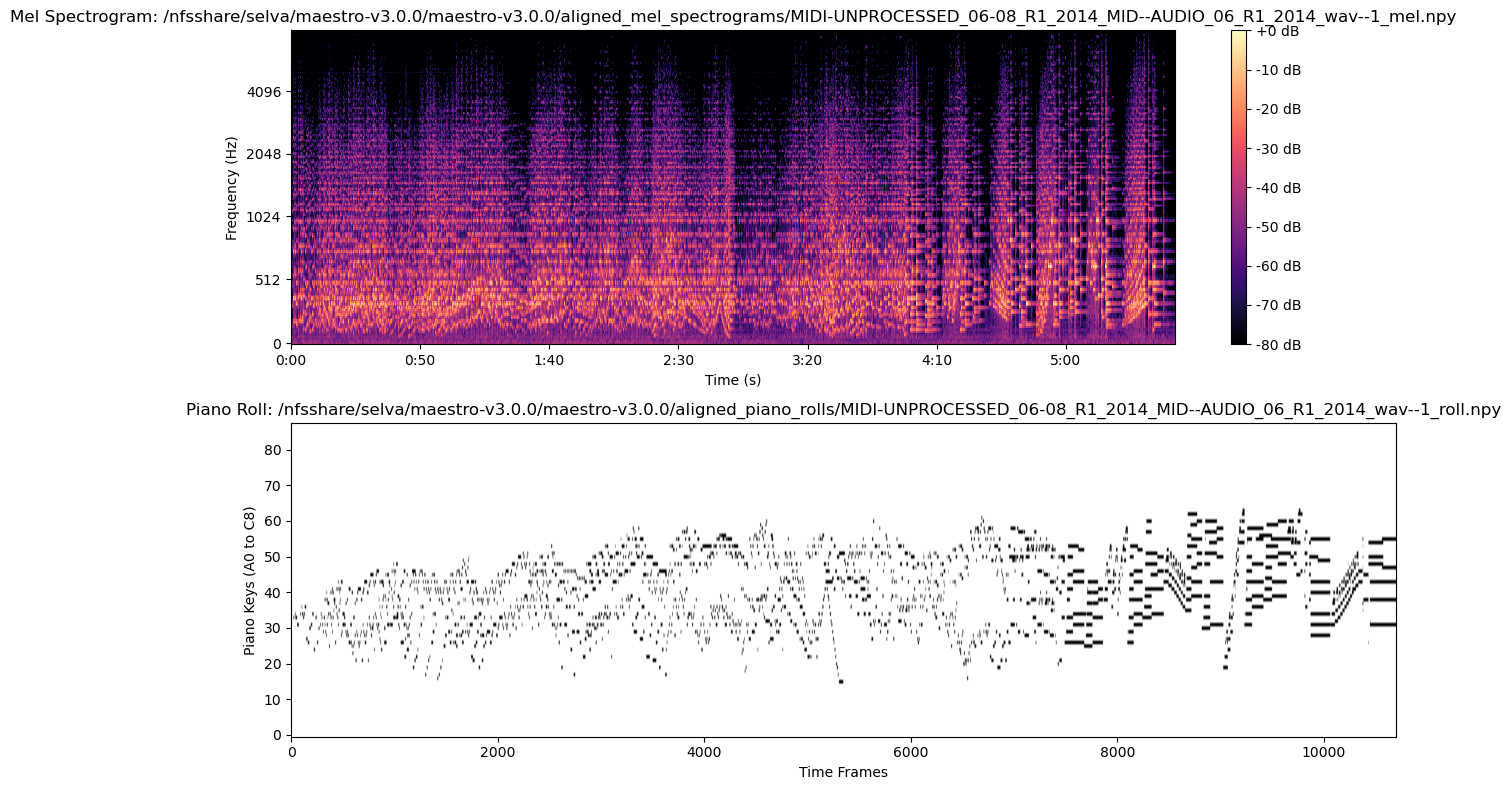

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

# Function to visualize Mel spectrogram and piano roll
def visualize_mismatch(mel_file, piano_roll_file):
    try:
        # Load data
        mel_spec = np.load(mel_file)
        piano_roll = np.load(piano_roll_file)

        # Plot Mel spectrogram
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 1, 1)
        plt.title(f"Mel Spectrogram: {mel_file}")
        librosa.display.specshow(mel_spec, sr=16000, hop_length=512, x_axis="time", y_axis="mel", cmap="magma")
        plt.colorbar(format="%+2.0f dB")
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (Hz)")

        # Plot piano roll
        plt.subplot(2, 1, 2)
        plt.title(f"Piano Roll: {piano_roll_file}")
        plt.imshow(piano_roll, aspect="auto", origin="lower", cmap="gray_r")
        plt.xlabel("Time Frames")
        plt.ylabel("Piano Keys (A0 to C8)")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error visualizing files: {e}")

# Example usage
mel_file = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-UNPROCESSED_06-08_R1_2014_MID--AUDIO_06_R1_2014_wav--1_mel.npy"  # Replace with actual mismatched file path
piano_roll_file = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-UNPROCESSED_06-08_R1_2014_MID--AUDIO_06_R1_2014_wav--1_roll.npy"  # Replace with actual mismatched file path
visualize_mismatch(mel_file, piano_roll_file)


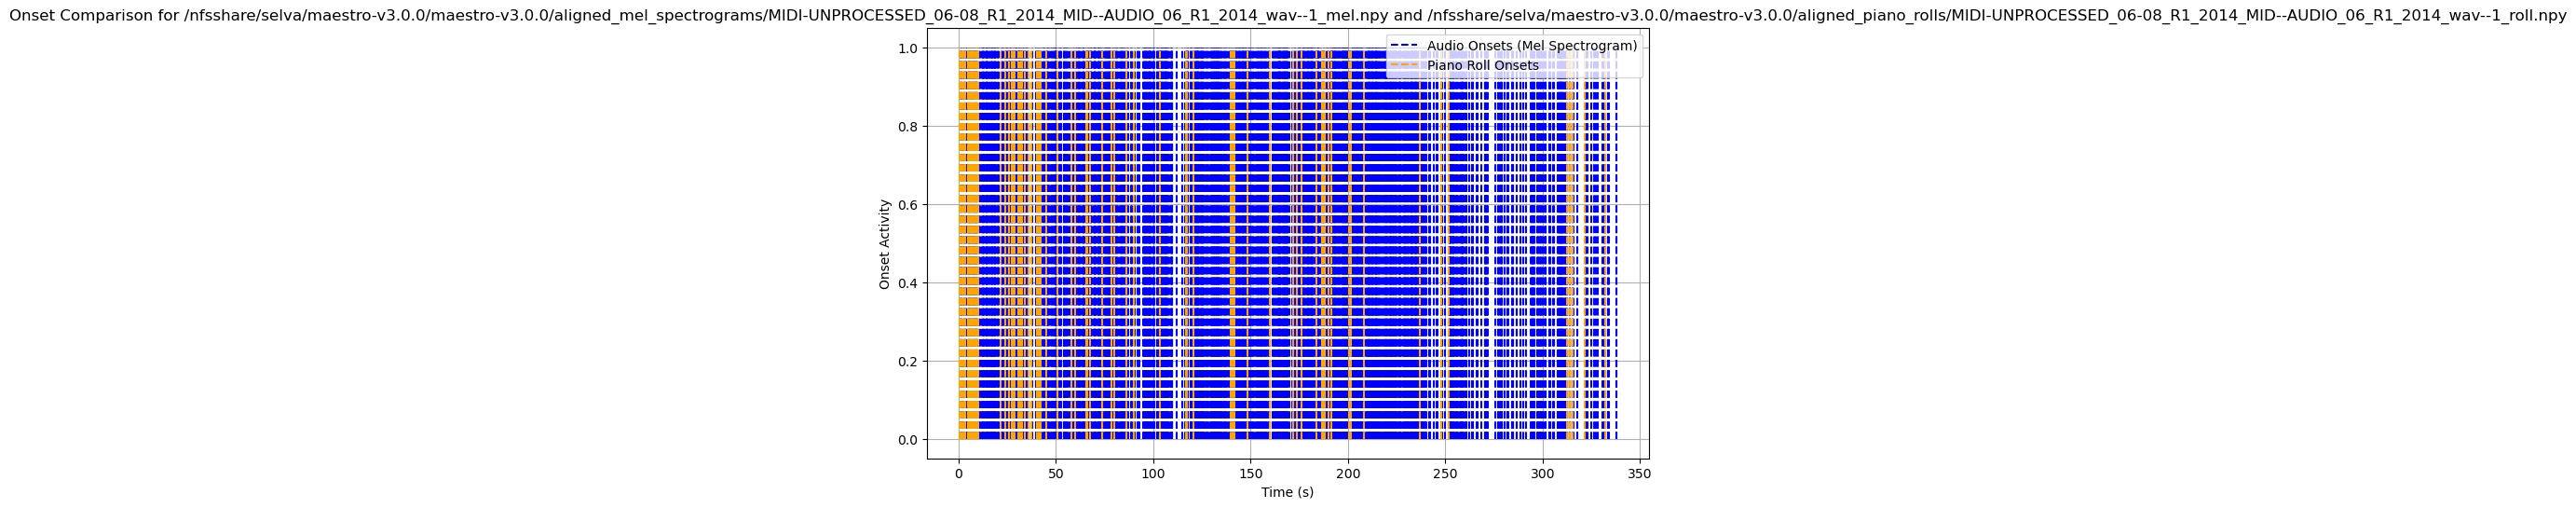

In [11]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import librosa.display

# Function to extract audio onsets using librosa
def extract_audio_onsets(audio_path, sr=16000, hop_length=512):
    y, sr = librosa.load(audio_path, sr=sr)
    onset_frames = librosa.onset.onset_detect(y=y, sr=sr, hop_length=hop_length)
    onset_times = librosa.frames_to_time(onset_frames, sr=sr, hop_length=hop_length)
    return onset_times, onset_frames

# Function to extract note onsets from the piano roll
def extract_piano_roll_onsets(piano_roll, hop_length=512, sr=16000):
    time_step = hop_length / sr  # Frame duration in seconds
    active_frames = np.sum(piano_roll, axis=0) > 0  # Identify active frames
    onset_frames = np.where(np.diff(active_frames.astype(int)) == 1)[0]  # Onset happens when frames go from 0 to 1
    onset_times = onset_frames * time_step
    return onset_times, onset_frames

# Visualization function
def visualize_onsets(audio_onsets, piano_roll_onsets, mel_file, piano_roll_file, audio_path):
    # Plot the comparison of onsets
    plt.figure(figsize=(10, 6))
    
    # Plot audio onsets
    plt.vlines(audio_onsets, ymin=0, ymax=1, color="blue", linestyle="--", label="Audio Onsets (Mel Spectrogram)")
    # Plot piano roll onsets
    plt.vlines(piano_roll_onsets, ymin=0, ymax=1, color="orange", linestyle="--", label="Piano Roll Onsets")
    plt.legend()
    plt.title(f"Onset Comparison for {mel_file} and {piano_roll_file}")
    plt.xlabel("Time (s)")
    plt.ylabel("Onset Activity")
    plt.grid()
    plt.show()

# Example usage
mel_file = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_mel_spectrograms/MIDI-UNPROCESSED_06-08_R1_2014_MID--AUDIO_06_R1_2014_wav--1_mel.npy"  # Replace with actual mismatched mel file
piano_roll_file = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/aligned_piano_rolls/MIDI-UNPROCESSED_06-08_R1_2014_MID--AUDIO_06_R1_2014_wav--1_roll.npy"  # Replace with actual mismatched piano roll file
audio_path = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/2014/MIDI-UNPROCESSED_06-08_R1_2014_MID--AUDIO_06_R1_2014_wav--1.wav"  # Path to the original audio file

# Load Mel spectrogram and piano roll
mel_spec = np.load(mel_file)
piano_roll = np.load(piano_roll_file)

# Extract onsets
audio_onsets, audio_onset_frames = extract_audio_onsets(audio_path)
piano_roll_onsets, piano_roll_onset_frames = extract_piano_roll_onsets(piano_roll)

# Visualize onsets
visualize_onsets(audio_onsets, piano_roll_onsets, mel_file, piano_roll_file, audio_path)
